In [346]:
## You need to change the project ID to match your GCP
PROJECT_ID = "halogen-rarity-312520"

In [347]:
import os
from google.colab import auth

#sets dateset
DATASET_PROJECT_ID = 'amsterdamumcdb-data'
DATASET_ID = 'ams102'
LOCATION = 'eu'

#all libraries check this environment variable, so set it:
os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID

auth.authenticate_user()
print('Authenticated')

Authenticated


In [348]:
from google.cloud.bigquery import magics
from google.cloud import bigquery

#sets the default query job configuration
def_config = bigquery.job.QueryJobConfig(default_dataset=DATASET_PROJECT_ID + "." + DATASET_ID)

#sets client options job configuration
client_options = {}
client_options['location'] = LOCATION

In [349]:
import pandas as pd
import numpy as np
import re

In [350]:
# For decision tree
!pip install graphviz
!pip install pydotplus

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [351]:
# For Cox model
!pip install lifelines

from lifelines import CoxPHFitter

In [352]:
#get the amsterdamumcdb package from PiPy repository for use in Colab
!pip install amsterdamumcdb
import amsterdamumcdb as adb
dictionary = adb.get_dictionary()

In [353]:
pd.set_option('display.max_rows', 100)

In [354]:
config_gbq = {'query': 
          {'defaultDataset': {
              "datasetId": DATASET_ID, 
              "projectId": DATASET_PROJECT_ID
              },
           'Location': LOCATION}
           }

In [355]:
diagnoses_sql = '''
WITH diagnoses AS (
    SELECT admissionid,
        item, 
        value as diagnosis,
        CASE
            WHEN itemid IN (
                --SURGICAL
                13116, --D_Thoraxchirurgie_CABG en Klepchirurgie
                16671, --DMC_Thoraxchirurgie_CABG en Klepchirurgie
                13117, --D_Thoraxchirurgie_Cardio anders
                16672, --DMC_Thoraxchirurgie_Cardio anders
                13118, --D_Thoraxchirurgie_Aorta chirurgie
                16670, --DMC_Thoraxchirurgie_Aorta chirurgie
                13119, --D_Thoraxchirurgie_Pulmonale chirurgie
                16673, --DMC_Thoraxchirurgie_Pulmonale chirurgie

                --Not surgical: 13141, --D_Algemene chirurgie_Algemeen   
                --Not surgical: 16642, --DMC_Algemene chirurgie_Algemeen
                13121, --D_Algemene chirurgie_Buikchirurgie
                16643, --DMC_Algemene chirurgie_Buikchirurgie
                13123, --D_Algemene chirurgie_Endocrinologische chirurgie
                16644, --DMC_Algemene chirurgie_Endocrinologische chirurgie
                13145, --D_Algemene chirurgie_KNO/Overige
                16645, --DMC_Algemene chirurgie_KNO/Overige
                13125, --D_Algemene chirurgie_Orthopedische chirurgie
                16646, --DMC_Algemene chirurgie_Orthopedische chirurgie
                13122, --D_Algemene chirurgie_Transplantatie chirurgie
                16647, --DMC_Algemene chirurgie_Transplantatie chirurgie
                13124, --D_Algemene chirurgie_Trauma
                16648, --DMC_Algemene chirurgie_Trauma
                13126, --D_Algemene chirurgie_Urogenitaal
                16649, --DMC_Algemene chirurgie_Urogenitaal
                13120, --D_Algemene chirurgie_Vaatchirurgie
                16650, --DMC_Algemene chirurgie_Vaatchirurgie

                13128, --D_Neurochirurgie _Vasculair chirurgisch
                16661, --DMC_Neurochirurgie _Vasculair chirurgisch
                13129, --D_Neurochirurgie _Tumor chirurgie
                16660, --DMC_Neurochirurgie _Tumor chirurgie
                13130, --D_Neurochirurgie_Overige
                16662, --DMC_Neurochirurgie_Overige

                18596, --Apache II Operatief  Gastr-intenstinaal
                18597, --Apache II Operatief Cardiovasculair
                18598, --Apache II Operatief Hematologisch
                18599, --Apache II Operatief Metabolisme
                18600, --Apache II Operatief Neurologisch
                18601, --Apache II Operatief Renaal
                18602, --Apache II Operatief Respiratoir

                17008, --APACHEIV Post-operative cardiovascular
                17009, --APACHEIV Post-operative gastro-intestinal
                17010, --APACHEIV Post-operative genitourinary
                17011, --APACHEIV Post-operative hematology
                17012, --APACHEIV Post-operative metabolic
                17013, --APACHEIV Post-operative musculoskeletal /skin
                17014, --APACHEIV Post-operative neurologic
                17015, --APACHEIV Post-operative respiratory
                17016, --APACHEIV Post-operative transplant
                17017 --APACHEIV Post-operative trauma

            ) THEN 1
            WHEN itemid = 18669 AND valueid BETWEEN 1 AND 26 THEN 1 --NICE APACHEII diagnosen
            WHEN itemid = 18671 AND valueid BETWEEN 222 AND 452 THEN 1 --NICE APACHEIV diagnosen
            ELSE 0
        END AS surgical,
        valueid as diagnosis_id,
        CASE 
                WHEN itemid = 18671 THEN 'NICE APACHE IV'
                WHEN itemid = 18669 THEN 'NICE APACHE II'
                WHEN itemid BETWEEN 16998 AND 17017 THEN 'APACHE IV'
                WHEN itemid BETWEEN 18589 AND 18602 THEN 'APACHE II'
                WHEN itemid BETWEEN 13116 AND 13145 THEN 'Legacy ICU'
                WHEN itemid BETWEEN 16642 AND 16673 THEN 'Legacy MCU'
        END AS diagnosis_type,
        ROW_NUMBER() OVER(PARTITION BY admissionid
        ORDER BY 
            CASE --prefer NICE > APACHE IV > II > D
                WHEN itemid = 18671 THEN 6 --NICE APACHEIV diagnosen
                WHEN itemid = 18669 THEN 5 --NICE APACHEII diagnosen                
                WHEN itemid BETWEEN 16998 AND 17017 THEN 4 --APACHE IV diagnosis        
                WHEN itemid BETWEEN 18589 AND 18602 THEN 3 --APACHE II diagnosis
                WHEN itemid BETWEEN 13116 AND 13145 THEN 2 --D diagnosis ICU
                WHEN itemid BETWEEN 16642 AND 16673 THEN 1 --DMC diagnosis Medium Care
            END DESC,
            measuredat DESC) AS rownum
    FROM listitems
    WHERE itemid IN (
        -- Diagnosis - LEVEL 2
        --SURGICAL
        13116, --D_Thoraxchirurgie_CABG en Klepchirurgie
        16671, --DMC_Thoraxchirurgie_CABG en Klepchirurgie
        13117, --D_Thoraxchirurgie_Cardio anders
        16672, --DMC_Thoraxchirurgie_Cardio anders
        13118, --D_Thoraxchirurgie_Aorta chirurgie
        16670, --DMC_Thoraxchirurgie_Aorta chirurgie
        13119, --D_Thoraxchirurgie_Pulmonale chirurgie
        16673, --DMC_Thoraxchirurgie_Pulmonale chirurgie
        
        13141, --D_Algemene chirurgie_Algemeen   
        16642, --DMC_Algemene chirurgie_Algemeen
        13121, --D_Algemene chirurgie_Buikchirurgie
        16643, --DMC_Algemene chirurgie_Buikchirurgie
        13123, --D_Algemene chirurgie_Endocrinologische chirurgie
        16644, --DMC_Algemene chirurgie_Endocrinologische chirurgie
        13145, --D_Algemene chirurgie_KNO/Overige
        16645, --DMC_Algemene chirurgie_KNO/Overige
        13125, --D_Algemene chirurgie_Orthopedische chirurgie
        16646, --DMC_Algemene chirurgie_Orthopedische chirurgie
        13122, --D_Algemene chirurgie_Transplantatie chirurgie
        16647, --DMC_Algemene chirurgie_Transplantatie chirurgie
        13124, --D_Algemene chirurgie_Trauma
        16648, --DMC_Algemene chirurgie_Trauma
        13126, --D_Algemene chirurgie_Urogenitaal
        16649, --DMC_Algemene chirurgie_Urogenitaal
        13120, --D_Algemene chirurgie_Vaatchirurgie
        16650, --DMC_Algemene chirurgie_Vaatchirurgie

        13128, --D_Neurochirurgie _Vasculair chirurgisch
        16661, --DMC_Neurochirurgie _Vasculair chirurgisch
        13129, --D_Neurochirurgie _Tumor chirurgie
        16660, --DMC_Neurochirurgie _Tumor chirurgie
        13130, --D_Neurochirurgie_Overige
        16662, --DMC_Neurochirurgie_Overige
        
        18596, --Apache II Operatief  Gastr-intenstinaal
        18597, --Apache II Operatief Cardiovasculair
        18598, --Apache II Operatief Hematologisch
        18599, --Apache II Operatief Metabolisme
        18600, --Apache II Operatief Neurologisch
        18601, --Apache II Operatief Renaal
        18602, --Apache II Operatief Respiratoir
        
        17008, --APACHEIV Post-operative cardiovascular
        17009, --APACHEIV Post-operative gastro-intestinal
        17010, --APACHEIV Post-operative genitourinary
        17011, --APACHEIV Post-operative hematology
        17012, --APACHEIV Post-operative metabolic
        17013, --APACHEIV Post-operative musculoskeletal /skin
        17014, --APACHEIV Post-operative neurologic
        17015, --APACHEIV Post-operative respiratory
        17016, --APACHEIV Post-operative transplant
        17017, --APACHEIV Post-operative trauma

        --MEDICAL
        13133, --D_Interne Geneeskunde_Cardiovasculair
        16653, --DMC_Interne Geneeskunde_Cardiovasculair
        13134, --D_Interne Geneeskunde_Pulmonaal
        16658, --DMC_Interne Geneeskunde_Pulmonaal
        13135, --D_Interne Geneeskunde_Abdominaal
        16652, --DMC_Interne Geneeskunde_Abdominaal
        13136, --D_Interne Geneeskunde_Infectieziekten
        16655, --DMC_Interne Geneeskunde_Infectieziekten
        13137, --D_Interne Geneeskunde_Metabool
        16656, --DMC_Interne Geneeskunde_Metabool
        13138, --D_Interne Geneeskunde_Renaal
        16659, --DMC_Interne Geneeskunde_Renaal
        13139, --D_Interne Geneeskunde_Hematologisch
        16654, --DMC_Interne Geneeskunde_Hematologisch
        13140, --D_Interne Geneeskunde_Overige
        16657, --DMC_Interne Geneeskunde_Overige

        13131, --D_Neurologie_Vasculair neurologisch
        16664, --DMC_Neurologie_Vasculair neurologisch
        13132, --D_Neurologie_Overige
        16663, --DMC_Neurologie_Overige 
        13127, --D_KNO/Overige
        
        18589, --Apache II Non-Operatief Cardiovasculair
        18590, --Apache II Non-Operatief Gastro-intestinaal
        18591, --Apache II Non-Operatief Hematologisch
        18592, --Apache II Non-Operatief Metabolisme
        18593, --Apache II Non-Operatief Neurologisch
        18594, --Apache II Non-Operatief Renaal
        18595, --Apache II Non-Operatief Respiratoir
        
        16998, --APACHE IV Non-operative cardiovascular
        16999, --APACHE IV Non-operative Gastro-intestinal
        17000, --APACHE IV Non-operative genitourinary
        17001, --APACHEIV  Non-operative haematological
        17002, --APACHEIV  Non-operative metabolic
        17003, --APACHEIV Non-operative musculo-skeletal
        17004, --APACHEIV Non-operative neurologic
        17005, --APACHEIV Non-operative respiratory
        17006, --APACHEIV Non-operative transplant
        17007, --APACHEIV Non-operative trauma
        
        --NICE: surgical/medical combined in same parameter
        18669, --NICE APACHEII diagnosen
        18671 --NICE APACHEIV diagnosen
    )
), sepsis AS (
    SELECT
        admissionid,
        CASE valueid
            WHEN 1 THEN 1 --'Ja'
            WHEN 2 THEN 0 --'Nee'
        END as sepsis_at_admission,
        ROW_NUMBER() OVER(
            PARTITION BY 
                admissionid
            ORDER BY 
                measuredat DESC) AS rownum
    FROM listitems
    WHERE 
        itemid = 15808
), sepsis_antibiotics AS ( --non prophylactic antibiotics
    SELECT
        admissionid,
        CASE 
            WHEN COUNT(*) > 0 THEN 1
            ELSE 0
        END AS sepsis_antibiotics_bool,
        STRING_AGG(DISTINCT item, '; ') AS sepsis_antibiotics_given
    FROM drugitems
    WHERE 
        itemid IN (
            6834, --Amikacine (Amukin)
            6847, --Amoxicilline (Clamoxyl/Flemoxin)
            6871, --Benzylpenicilline (Penicilline)
            6917, --Ceftazidim (Fortum)
            --6919, --Cefotaxim (Claforan) -> prophylaxis
            6948, --Ciprofloxacine (Ciproxin)
            6953, --Rifampicine (Rifadin)
            6958, --Clindamycine (Dalacin)
            7044, --Tobramycine (Obracin)
            --7064, --Vancomycine -> prophylaxis for valve surgery
            7123, --Imipenem (Tienam)
            7185, --Doxycycline (Vibramycine)
            --7187, --Metronidazol (Flagyl) -> often used for GI surgical prophylaxis
            --7208, --Erythromycine (Erythrocine) -> often used for gastroparesis
            7227, --Flucloxacilline (Stafoxil/Floxapen)
            7231, --Fluconazol (Diflucan)
            7232, --Ganciclovir (Cymevene)
            7233, --Flucytosine (Ancotil)
            7235, --Gentamicine (Garamycin)
            7243, --Foscarnet trinatrium (Foscavir)
            7450, --Amfotericine B (Fungizone)
            --7504, --X nader te bepalen --non-stock medication
            8127, --Meropenem (Meronem)
            8229, --Myambutol (ethambutol)
            8374, --Kinine dihydrocloride
            --8375, --Immunoglobuline (Nanogam) -> not anbiotic
            --8394, --Co-Trimoxazol (Bactrimel) -> often prophylactic (unless high dose)
            8547, --Voriconazol(VFEND)
            --9029, --Amoxicilline/Clavulaanzuur (Augmentin) -> often used for ENT surgical prophylaxis
            9030, --Aztreonam (Azactam)
            9047, --Chlooramfenicol
            --9075, --Fusidinezuur (Fucidin) -> prophylaxis
            9128, --Piperacilline (Pipcil)
            9133, --Ceftriaxon (Rocephin)
            --9151, --Cefuroxim (Zinacef) -> often used for GI/transplant surgical prophylaxis
            --9152, --Cefazoline (Kefzol) -> prophylaxis for cardiac surgery
            9458, --Caspofungine
            9542, --Itraconazol (Trisporal)
            --9602, --Tetanusimmunoglobuline -> prophylaxis/not antibiotic
            12398, --Levofloxacine (Tavanic)
            12772, --Amfotericine B lipidencomplex  (Abelcet)
            15739, --Ecalta (Anidulafungine)
            16367, --Research Anidulafungin/placebo
            16368, --Research Caspofungin/placebo
            18675, --Amfotericine B in liposomen (Ambisome )
            19137, --Linezolid (Zyvoxid)
            19764, --Tigecycline (Tygacil)
            19773, --Daptomycine (Cubicin)
            20175 --Colistine
        )
        AND start < 6*60*60*1000 --within 6 hours (to correct for antibiotics administered before ICU)
    GROUP BY admissionid
), other_antibiotics AS ( --'prophylactic' antibiotics that may be used for sepsis
    SELECT
        admissionid,
        CASE 
            WHEN COUNT(*) > 0 THEN 1
            ELSE 0
        END AS other_antibiotics_bool,
        STRING_AGG(DISTINCT item, '; ') AS other_antibiotics_given
    FROM drugitems
    WHERE 
        itemid IN (
            7064, --Vancomycine -> prophylaxis for valve surgery
            7187, --Metronidazol (Flagyl) -> often used for GI surgical prophylaxis
            8394, --Co-Trimoxazol (Bactrimel) -> often prophylactic (unless high dose)
            9029, --Amoxicilline/Clavulaanzuur (Augmentin) -> often used for ENT surgical prophylaxis
            9151, --Cefuroxim (Zinacef) -> often used for GI surgical prophylaxis
            9152 --Cefazoline (Kefzol) -> prophylaxis
        )
        AND start < 24*60*60*1000 --within 24 hours (to correct for antibiotics administered before ICU)
    GROUP BY admissionid    
), cultures AS (
    SELECT
        admissionid,
        CASE 
            WHEN COUNT(*) > 0 THEN 1
            ELSE 0
        END AS sepsis_cultures_bool,
        STRING_AGG(DISTINCT item, '; ') AS sepsis_cultures_drawn
    FROM procedureorderitems
    WHERE 
        itemid IN (
        --8097, --Sputumkweek afnemen -> often used routinely
        --8418, --Urinekweek afnemen
        --8588, --MRSA kweken afnemen 
        9189, --Bloedkweken afnemen
        9190, --Cathetertipkweek afnemen
        --9191, --Drainvochtkweek afnemen
        --9192, --Faeceskweek afnemen -> Clostridium
        --9193, --X-Kweek nader te bepalen
        --9194, --Liquorkweek afnemen
        --9195, --Neuskweek afnemen
        --9197, --Perineumkweek afnemen -> often used routinely
        -9198, --Rectumkweek afnemen -> often used routinely
        9200, --Wondkweek afnemen
        9202, --Ascitesvochtkweek afnemen
        --9203, --Keelkweek afnemen -> often used routinely
        --9204, --SDD-kweken afnemen -> often used routinely
        9205 --Legionella sneltest (urine)
        --1302, --SDD Inventarisatiekweken afnemen -> often used routinely
        --19663, --Research Neuskweek COUrSe
        --19664, --Research Sputumkweek COUrSe
        )
        AND registeredat < 6*60*60*1000 --within 6 hours
    GROUP BY admissionid
)
SELECT 
    admissions.* 
    , diagnosis_type
    , diagnosis, diagnosis_id
    , surgical
    , sepsis_at_admission
    , sepsis_antibiotics_bool
    , sepsis_antibiotics_given
    , other_antibiotics_bool
    , other_antibiotics_given
    , sepsis_cultures_bool
    , sepsis_cultures_drawn
FROM admissions
LEFT JOIN diagnoses on admissions.admissionid = diagnoses.admissionid
LEFT JOIN sepsis on admissions.admissionid = sepsis.admissionid
LEFT JOIN sepsis_antibiotics on admissions.admissionid = sepsis_antibiotics.admissionid
LEFT JOIN other_antibiotics on admissions.admissionid = other_antibiotics.admissionid
LEFT JOIN cultures on admissions.admissionid = cultures.admissionid
WHERE --only last updated record
    (diagnoses.rownum = 1 OR diagnoses.rownum IS NULL) AND 
    (sepsis.rownum = 1 OR sepsis.rownum IS NULL) 
;
'''

In [356]:
af = pd.read_gbq(
    '''
    SELECT
      admissionid
      ,itemid
      --,item
      ,valueid
      --,value
      ,measuredat
      --,registeredat
      --,registeredby
      --,updatedat
      --,updatedby
      --,islabresult
    FROM listitems
    WHERE 
      itemid = 6671	--Hartritme
      AND valueid = 13	--Atr fib
    '''
    , configuration=config_gbq)

In [357]:
# af_inclusion_tf = (af['measuredat'] > 0.5 * 60 * 60 * 1000) & (af['measuredat'] < 5 * 24 * 60 * 60 * 1000)
# af_exclusion_tf = af['measuredat'] < 0

af_inclusion_tf = af['measuredat'] < 5 * 24 * 60 * 60 * 1000
af_exclusion_tf = af['measuredat'] < 0.5 * 60 * 60 * 1000

## Note we will also want to remove all patients who have an AF event before 30 mins if we decide this isn't NOAF
include_admissionid = af.loc[af_inclusion_tf, 'admissionid']
exclude_admissionid = af.loc[af_exclusion_tf, 'admissionid']
include_admissionid = include_admissionid[~include_admissionid.isin(exclude_admissionid)]
include_admissionid.size

48501

In [358]:
admissions_df = pd.read_gbq(diagnoses_sql, configuration = config_gbq)
admissions_df.head()

patientid  admissionid  ...  sepsis_cultures_bool sepsis_cultures_drawn
0        117          130  ...                   NaN                  None
1        570          656  ...                   NaN                  None
2        700          799  ...                   NaN                  None
3        817          941  ...                   NaN                  None
4        951         1098  ...                   NaN                  None

[5 rows x 30 columns]

In [359]:
admissions_df['afib'] = admissions_df['admissionid'].isin(include_admissionid) 
admissions_df['afib'] &= admissions_df['admissioncount'] == 1
admissions_df['afib'].sum()

## patients we assume have AF but not NOAF, by criterion given
admissions_df['previous_afib'] = admissions_df['admissionid'].isin(exclude_admissionid) 
admissions_df['previous_afib'] &= admissions_df['admissioncount'] == 1
admissions_df['previous_afib'].sum()

614

In [360]:
## First AF time
af_times = af.loc[:, ['admissionid', 'measuredat']]
af_times = af_times.loc[af_inclusion_tf, :]
af_times = af_times.loc[~af_exclusion_tf, :]
af_times = af_times.sort_values(by='measuredat')
af_times = af_times.loc[~af_times['admissionid'].duplicated()]
af_times['measuredat'] /= (60*1000)
af_times.rename(columns = {'measuredat': 'afib_time'}, inplace = True)

In [361]:
admissions_df = pd.merge(admissions_df, af_times, on='admissionid', how='left')
admissions_df.loc[admissions_df['afib'] == 0, 'afib_time'] = np.nan
admissions_df['afib_time'].max()

7198.0

In [362]:
admissions_df['outcome_time'] = admissions_df['afib_time'].copy()
admissions_df.loc[admissions_df['outcome_time'].isna(), 'outcome_time'] = \
  admissions_df.loc[admissions_df['outcome_time'].isna(), 'dischargedat'] / (1000*60) # turn into hours
admissions_df.loc[admissions_df['outcome_time'] > 5*24*60, 'outcome_time'] = 5*24*60 + 0.01
admissions_df.head()

patientid  admissionid  ...  afib_time outcome_time
0        117          130  ...      121.0        121.0
1        570          656  ...        NaN       1513.0
2        700          799  ...        NaN       1741.0
3        817          941  ...        NaN       1443.0
4        951         1098  ...        NaN       1250.0

[5 rows x 34 columns]

**Identify cardiothoracic patients**

In [363]:
re_cardiosurg = r'(CABG|AVR|hartchirurgie|heart surgery|Chron. cardiovasculaire ziekte|hartkleppen' + \
r'|cardiovascula|MVP|MVR|mitral|tricuspid|pericard|aortic.*valve|lobectom|segment|thorax|Bentall|aorta-ascendens|aorta-boog' + \
r'|aorta-wortel|aorta-descendens|lung|pneumectomie|bullectom|respiratoir neoplasm|thoracoscop|thoracotom(y|ie)|respirato' + \
r'|vrije wand ruptuur|VSR|ASD|pleurectom|intracardiac|aneurysmectom|congenital defect repair)(?! for esophag)'
re_cardiosurg = r'(CABG|AVR|MVP|MVR|valve)'

In [364]:
# Patients who have CBAG / valve surgery (from cardiology or cardiac surgery)
admissions_df['is_cardiosurg'] = admissions_df['surgical'] == 1
admissions_df['is_cardiosurg'] &= admissions_df['diagnosis'].str.contains(re_cardiosurg, na=False, flags=re.IGNORECASE)
admissions_df['is_cardiosurg'] &= admissions_df['specialty'].isin(['Cardiochirurgie', 'Cardiologie'])

/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


**Identify patients with sepsis**

In [365]:
re_sepsis_surg = r'sepsis|pneumoni|GI perforation|perforation/rupture|infection|abscess|GI Vascular ischemia|diverticular|appendectomy|peritonitis'
re_sepsis_med = r'sepsis|septic|infect|pneumoni|cholangitis|pancr|endocarditis|meningitis|GI perforation|abces|abscess|darm ischaemie|GI vascular|fasciitis' + \
r'|inflammatory|peritonitis'

In [366]:
admissions_df['is_sepsis_surgical'] = admissions_df['surgical'] == 1
admissions_df['is_sepsis_surgical'] &= admissions_df['diagnosis'].str.contains(re_sepsis_surg, na=False, flags=re.IGNORECASE)
admissions_df['is_sepsis_surgical'] &= ~(admissions_df['sepsis_at_admission'] == 0)

# medical admissions with sepsis
admissions_df['is_sepsis'] = (
      (admissions_df['surgical'] == 0) & admissions_df['diagnosis'].str.contains(re_sepsis_med, na=False, flags=re.IGNORECASE)
   ) | (
      admissions_df['sepsis_at_admission'] == 1
   ) | (
      admissions_df['sepsis_antibiotics_bool'] == 1
   ) | (
      (admissions_df['other_antibiotics_bool'] == 1) & (admissions_df['sepsis_cultures_bool'] == 1)
)
admissions_df['is_sepsis'] &= ~(admissions_df['sepsis_at_admission'] == 0)
admissions_df['is_sepsis'] |= admissions_df['is_sepsis_surgical']

In [367]:
## query numbers
ind_all = (admissions_df['admissioncount'] == 1) & (admissions_df['previous_afib'] == 0)
## CABG/valve surgery subset (no previous AF)
print('CABG/valve surgery (no previous AF)')
print((admissions_df['is_cardiosurg'] & ind_all).sum())
## CABG/valve surgery x NOAF subset
print('CABG/valve surgery x NOAF')
print((admissions_df['is_cardiosurg'] & admissions_df['afib'] & ind_all).sum())
## Sepsis subset (no previous AF)
print('Sepsis (no previous AF)')
print((admissions_df['is_sepsis'] & ind_all).sum())
## Sepsis x NOAF subset
print('Sepsis x NOAF')
print((admissions_df['is_sepsis'] & admissions_df['afib'] & ind_all).sum())
print('All')
print(ind_all.sum())

CABG/valve surgery (no previous AF)
4573
CABG/valve surgery x NOAF
429
Sepsis (no previous AF)
2006
Sepsis x NOAF
486
All
19495


#SOFA

This section is mostly copied from https://github.com/AmsterdamUMC/AmsterdamUMCdb/blob/master/concepts/severityscores/sofa.ipynb

However, there are some changes that needed to be made to convert from SQL to GBQ.

In [368]:
#get PaO2/FiO2 ratio
sql_oxy_flow = """
SELECT 
    oxy_dev.admissionid,
    oxy_dev.valueid,
    oxy_dev.value as O2_device,
    oxy_dev.measuredat,
    oxy_flow.value AS O2_flow 
FROM listitems oxy_dev
LEFT JOIN admissions a ON
    oxy_dev.admissionid = a.admissionid
LEFT JOIN numericitems oxy_flow ON
    oxy_dev.admissionid = oxy_flow.admissionid AND
    oxy_dev.measuredat = oxy_flow.measuredat AND
    oxy_flow.itemid IN (
        8845, -- O2 l/min
        10387, --Zuurstof toediening (bloed)
        18587 --Zuurstof toediening
    )
WHERE oxy_dev.itemid = 8189 -- Toedieningsweg (Oxygen device)
    -- measurements within 24 hours of ICU stay:
    AND (oxy_dev.measuredat - a.admittedat) <= 1000*60*60*24 AND (oxy_dev.measuredat - a.admittedat) >= 0 
"""
oxy_flow = pd.read_gbq(sql_oxy_flow, configuration = config_gbq)
#len(gcs.groupby('admissionid').size())
oxy_flow.head()

admissionid  valueid               O2_device  measuredat  O2_flow
0         8001        8                Kinnebak   256500000     13.0
1         2579       17  Non-Rebreathing masker    81000000     11.0
2         2730        8                Kinnebak    74820000     13.0
3          654        1             Diep Nasaal   140400000     20.0
4         5683        3                   Kapje    55200000      9.0

In [369]:
#get PaO2 and FiO2 values
# simultaneously retrieve PaCO2 and the 'nearest' FiO2 from the ventilator or estimated FiO2 based on applied oxygen
# device. Ideally documentation of measurements should be at the same time, but since this is not garanteed allow a window.
#
# in more recent data PaCO2 and PaO2 were documented in kPa instead of mmHg.
sql_sofa_respiration = """
WITH fio2_table AS (
    SELECT n.admissionid,
        n.measuredat,
        l.valueid,
        l.value AS O2_device,
        CASE
            WHEN n.itemid IN (
                --FiO2 settings on respiratory support
                6699, --FiO2 %: setting on Evita ventilator
                12279, --O2 concentratie --measurement by Servo-i/Servo-U ventilator
                12369, --SET %O2: used with BiPap Vision ventilator
                16246 --Zephyros FiO2: Non-invasive ventilation
            ) THEN TRUE
            ELSE FALSE
        END AS ventilatory_support,
        CASE
            WHEN n.itemid IN (
                --FiO2 settings on respiratory support
                6699, --FiO2 %: setting on Evita ventilator
                12279, --O2 concentratie --measurement by Servo-i/Servo-U ventilator
                12369, --SET %O2: used with BiPap Vision ventilator
                16246 --Zephyros FiO2: Non-invasive ventilation
            ) THEN 
                CASE 
                    WHEN NOT n.value IS NULL THEN n.value --use the settings
                    ELSE 0.21
                END
            ELSE -- estimate the FiO2
                CASE
                    WHEN l.valueid IN (
                        2, -- Nasaal
                        7 --O2-bril
                    ) THEN 
                        CASE
                            WHEN n.value >= 1 AND n.value < 2 THEN 0.22
                            WHEN n.value >= 2 AND n.value < 3 THEN 0.25
                            WHEN n.value >= 3 AND n.value < 4 THEN 0.27
                            WHEN n.value >= 4 AND n.value < 5 THEN 0.30
                            WHEN n.value >= 5 THEN 0.35
                            ELSE 0.21
                        END
                    WHEN l.valueid IN (
                        1, --Diep Nasaal
                        3, --Kapje
                        8, --Kinnebak
                        9, --Nebulizer
                        4, --Kunstneus
                        18, --Spreekcanule
                        19 --Spreekklepje
                    ) THEN
                        CASE
                            WHEN n.value >= 1 AND n.value < 2 THEN 0.22 -- not defined by NICE
                            WHEN n.value >= 2 AND n.value < 3 THEN 0.25
                            WHEN n.value >= 3 AND n.value < 4 THEN 0.27
                            WHEN n.value >= 4 AND n.value < 5 THEN 0.30
                            WHEN n.value >= 5 AND n.value < 6 THEN 0.35
                            WHEN n.value >= 6 AND n.value < 7 THEN 0.40
                            WHEN n.value >= 7 AND n.value < 8 THEN 0.45
                            WHEN n.value >= 8 THEN 0.50
                            ELSE 0.21
                        END
                    WHEN l.valueid IN (
                        10, --Waterset
                        11, --Trach.stoma
                        13, --Ambu
                        14, --Guedel
                        15, --DL-tube
                        16, --CPAP
                        17 --Non-Rebreathing masker
                    ) THEN
                        CASE
                            WHEN n.value >= 6 AND n.value < 7 THEN 0.60
                            WHEN n.value >= 7 AND n.value < 8 THEN 0.70
                            WHEN n.value >= 8 AND n.value < 9 THEN 0.80
                            WHEN n.value >= 9 AND n.value < 10 THEN 0.85
                            WHEN n.value >= 10 THEN 0.90
                            ELSE 0.21  
                        END
                    WHEN l.valueid IN (
                        12 --B.Lucht
                    ) THEN 0.21
                ELSE 0.21
            END
        END AS fio2
    FROM numericitems n
    LEFT JOIN admissions a ON
        n.admissionid = a.admissionid
    LEFT JOIN listitems l ON
        n.admissionid = l.admissionid AND
        n.measuredat = l.measuredat AND
        l.itemid = 8189 -- Toedieningsweg (Oxygen device)
    WHERE 
        n.itemid IN (
            --Oxygen Flow settings without respiratory support
            8845, -- O2 l/min
            10387, --Zuurstof toediening (bloed)
            18587, --Zuurstof toediening

            --FiO2 settings on respiratory support
            6699, --FiO2 %: setting on Evita ventilator
            12279, --O2 concentratie --measurement by Servo-i/Servo-U ventilator
            12369, --SET %O2: used with BiPap Vision ventilator
            16246 --Zephyros FiO2: Non-invasive ventilation
        )
    --measurements within 24 hours of ICU stay:
    AND (n.measuredat - a.admittedat) <= 1000*60*60*24 AND (n.measuredat - a.admittedat) >= 0
    AND n.value > 0 --ignore stand by values from Evita ventilator
), 
oxygenation AS (
    SELECT 
        pao2.admissionid,
        CASE pao2.unitid 
            WHEN 152 THEN pao2.value * 7.50061683 -- Conversion: kPa to mmHg
            ELSE pao2.value 
        END AS pao2,
        f.value AS specimen_source,
        CASE 
            WHEN NOT pao2.registeredby LIKE '%Systeem%' THEN TRUE
            ELSE FALSE
        END AS manual_entry,
        (pao2.measuredat - a.admittedat)/(1000*60) AS time,
        fio2_table.fio2,
        fio2_table.ventilatory_support,
        (fio2_table.measuredat - pao2.measuredat)/(60*1000) AS FiO2_time_difference,
        ROW_NUMBER() OVER(
            PARTITION BY pao2.admissionid, pao2.measuredat
            ORDER BY ABS(fio2_table.measuredat - pao2.measuredat)
        ) AS priority --give priority to nearest FiO2 measurement
    FROM numericitems pao2
    LEFT JOIN admissions a ON
        pao2.admissionid = a.admissionid
    LEFT JOIN freetextitems f ON
        pao2.admissionid = f.admissionid AND
        pao2.measuredat = f.measuredat AND
        f.itemid = 11646 --Afname (bloed): source of specimen
    LEFT JOIN numericitems paco2 ON 
        pao2.admissionid = paco2.admissionid AND
        pao2.measuredat = paco2.measuredat AND
        paco2.itemid IN (
            6846, --PCO2
            9990, --pCO2 (bloed)
            21213 --PCO2 (bloed) - kPa
        )
    LEFT JOIN fio2_table ON 
        pao2.admissionid = fio2_table.admissionid AND
        fio2_table.measuredat > pao2.measuredat - 60*60*1000 AND --no earlier than 60 minutes before pao2 measurement
        fio2_table.measuredat < pao2.measuredat + 15*60*1000 --no later than 15 minutes after pao2 measurement
    WHERE 
        pao2.itemid IN (
            7433, --PO2
            9996, --PO2 (bloed)
            21214 --PO2 (bloed) - kPa
        ) 
    --measurements within 24 hours of ICU stay (use 30 minutes before admission to allow for time differences):
    AND (pao2.measuredat - a.admittedat) <= 1000*60*60*24 AND (pao2.measuredat - a.admittedat) >= -(1000*60*30) AND
    (f.value LIKE '%art.%' OR f.value IS NULL)  -- source is arterial or undefined (assume arterial)
)
SELECT * FROM oxygenation
WHERE priority = 1
"""
sofa_respiration = pd.read_gbq(sql_sofa_respiration, configuration = config_gbq)
sofa_respiration.head()

admissionid   pao2  ... FiO2_time_difference  priority
0          364   57.0  ...                -26.0         1
1         2694  105.0  ...                  9.0         1
2         3563   89.0  ...                 -3.0         1
3         5239   77.0  ...                  2.0         1
4         5757   83.0  ...                  6.0         1

[5 rows x 9 columns]

In [370]:
#remove extreme outliers
sofa_respiration.loc[(sofa_respiration['fio2'] > 100), 'fio2'] = np.NaN

#convert FiO2 in % to fraction
sofa_respiration.loc[(sofa_respiration['fio2'] <= 100) & 
                     (sofa_respiration['fio2'] >= 20) , 'fio2'] = sofa_respiration['fio2'] / 100

#remove lower outliers, most likely incorrectly labeled as 'arterial' instead of '(mixed/central) venous'
sofa_respiration.loc[sofa_respiration['pao2'] < 50, 'pao2'] = np.NaN
sofa_respiration = sofa_respiration.dropna(subset=['pao2'])

In [371]:
#get platelets (thrombocytes)
sql_sofa_platelets = """ 
SELECT 
    n.admissionid,
    n.itemid,
    n.item,
    n.value,
    n.registeredby,
    CASE 
        WHEN NOT n.registeredby LIKE '%Systeem%' THEN TRUE
        ELSE FALSE
    END AS manual_entry,
    (n.measuredat - a.admittedat)/(1000*60) AS time
FROM numericitems n
LEFT JOIN admissions a ON
    n.admissionid = a.admissionid
WHERE n.itemid IN (
    9964, --Thrombo's (bloed)
    6797, --Thrombocyten
    10409, --Thrombo's citr. bloed (bloed)
    14252 --Thrombo CD61 (bloed)
    )
--measurements within 24 hours of ICU stay (use 30 minutes before admission to allow for time differences):
AND (n.measuredat - a.admittedat) <= 1000*60*60*24 AND (n.measuredat - a.admittedat) >= -(1000*60*30)    
"""
sofa_platelets = pd.read_gbq(sql_sofa_platelets, configuration = config_gbq)
sofa_platelets.head()

admissionid  itemid               item  ...  registeredby manual_entry    time
0        13911    9964  Thrombo's (bloed)  ...       Systeem        False  1128.0
1        14485    9964  Thrombo's (bloed)  ...       Systeem        False   657.0
2        11891    9964  Thrombo's (bloed)  ...       Systeem        False   906.0
3        11891    9964  Thrombo's (bloed)  ...       Systeem        False  1115.0
4          728    9964  Thrombo's (bloed)  ...       Systeem        False   189.0

[5 rows x 7 columns]

In [372]:
sofa_respiration.loc[:,'pf_ratio'] = sofa_respiration['pao2']/sofa_respiration['fio2']

#calculate SOFA respiration score:
sofa_respiration.loc[:,'sofa_respiration_score'] = 0
sofa_respiration.loc[(sofa_respiration['pf_ratio'] < 400) & 
                     (sofa_respiration['pf_ratio'] >= 300), 'sofa_respiration_score'] = 1
sofa_respiration.loc[(sofa_respiration['pf_ratio'] < 300), 'sofa_respiration_score'] = 2
sofa_respiration.loc[(sofa_respiration['pf_ratio'] < 200) & (sofa_respiration['pf_ratio'] >= 100) &
                     (sofa_respiration['ventilatory_support'] == True), 'sofa_respiration_score'] = 3
sofa_respiration.loc[(sofa_respiration['pf_ratio'] < 100) & 
                     (sofa_respiration['ventilatory_support'] == True), 'sofa_respiration_score'] = 4

In [373]:
#calculate SOFA coagulation score:
sofa_platelets.loc[:,'sofa_coagulation_score'] = 0
sofa_platelets.loc[(sofa_platelets['value'] < 150) & 
                     (sofa_platelets['value'] >= 100), 'sofa_coagulation_score'] = 1
sofa_platelets.loc[(sofa_platelets['value'] < 100) & 
                     (sofa_platelets['value'] >= 50), 'sofa_coagulation_score'] = 3
sofa_platelets.loc[(sofa_platelets['value'] < 50) & 
                     (sofa_platelets['value'] >= 20), 'sofa_coagulation_score'] = 3
sofa_platelets.loc[(sofa_platelets['value'] < 20), 'sofa_coagulation_score'] = 4

In [374]:
#get bilirubin
sql_sofa_bilirubin = """ 
SELECT 
    n.admissionid,
    n.itemid,
    n.item,
    n.value,
    n.registeredby,
    CASE 
        WHEN NOT n.registeredby LIKE '%Systeem%' THEN TRUE
        ELSE FALSE
    END AS manual_entry,
    (n.measuredat - a.admittedat)/(1000*60) AS time
FROM numericitems n
LEFT JOIN admissions a ON
    n.admissionid = a.admissionid
    WHERE n.itemid IN (
        6813, --Bili Totaal
        9945 --Bilirubine (bloed)
    )
--measurements within 24 hours of ICU stay (use 30 minutes before admission to allow for time differences):
AND (n.measuredat - a.admittedat) <= 1000*60*60*24 AND (n.measuredat - a.admittedat) >= -(1000*60*30)
"""
sofa_bilirubin = pd.read_gbq(sql_sofa_bilirubin, configuration = config_gbq)
sofa_bilirubin.head()

admissionid  itemid                item  ...  registeredby manual_entry    time
0        22144    9945  Bilirubine (bloed)  ...       Systeem        False   778.0
1        20703    9945  Bilirubine (bloed)  ...       Systeem        False   708.0
2         5931    9945  Bilirubine (bloed)  ...       Systeem        False  1081.0
3        10947    9945  Bilirubine (bloed)  ...       Systeem        False  1047.0
4        20843    9945  Bilirubine (bloed)  ...       Systeem        False   161.0

[5 rows x 7 columns]

In [375]:
#calculate SOFA liver score:
sofa_bilirubin.loc[:,'sofa_liver_score'] = 0
sofa_bilirubin.loc[(sofa_bilirubin['value'] >= 20) & (sofa_bilirubin['value'] < 33), 'sofa_liver_score'] = 1
sofa_bilirubin.loc[(sofa_bilirubin['value'] >= 33) & (sofa_platelets['value'] < 102), 'sofa_liver_score'] = 2
sofa_bilirubin.loc[(sofa_bilirubin['value'] >= 102) & (sofa_platelets['value'] < 204), 'sofa_liver_score'] = 3
sofa_bilirubin.loc[(sofa_bilirubin['value'] >= 204), 'sofa_liver_score'] = 4

In [376]:
sql_sofa_cardiovascular = """
WITH dosing AS (
    SELECT  
        drugitems.admissionid, 
        itemid,
        item,
        (start - admissions.admittedat)/(1000*60) AS start_time, 
        (stop - admissions.admittedat)/(1000*60) AS stop_time, 
        duration,
        rate,
        rateunit,
        dose,
        doseunit,
        doseunitid,
        doserateperkg,
        doserateunitid,
        doserateunit,
        CASE
            WHEN weightgroup LIKE '59' THEN 55
            WHEN weightgroup LIKE '60' THEN 65
            WHEN weightgroup LIKE '70' THEN 75
            WHEN weightgroup LIKE '80' THEN 85
            WHEN weightgroup LIKE '90' THEN 95
            WHEN weightgroup LIKE '100' THEN 105
            WHEN weightgroup LIKE '110' THEN 115
            ELSE 80 --mean weight for all years
        END as patientweight
    FROM drugitems 
    LEFT JOIN admissions 
    ON drugitems.admissionid = admissions.admissionid
    WHERE ordercategoryid = 65 -- continuous i.v. perfusor
    AND itemid IN (
            7179, -- Dopamine (Inotropin)
            7178, -- Dobutamine (Dobutrex)
            6818, -- Adrenaline (Epinefrine)
            7229  -- Noradrenaline (Norepinefrine)
        )
    AND rate > 0.1
)
SELECT 
    admissionid,
    itemid,
    item,
    duration,
    rate,
    rateunit,
    start_time,
    stop_time,
    patientweight,
    dose,
    doserateperkg,
    doseunitid,
    doserateunitid
    # CASE 
    # --recalculate the dose to µg/kg/min ('gamma')
    # WHEN doserateperkg == B'0' AND doseunitid = 11 AND doserateunitid = 4 --unit: µg/min -> µg/kg/min
    #     THEN CASE 
    #         WHEN patientweight > 0
    #         THEN dose/patientweight
    #         ELSE dose/80 --mean weight
    #     END
    # WHEN doserateperkg = B'0' AND doseunitid = 10 AND
    # doserateunitid = 4 --unit: mg/min  -> µg/kg/min
    #     THEN CASE 
    #         WHEN patientweight > 0
    #         THEN dose*1000/patientweight
    #         ELSE dose*1000/80 --mean weight
    #     END
    # WHEN doserateperkg = B'0' AND doseunitid = 10 AND doserateunitid = 5 --unit: mg/uur  -> µg/kg/min
    #     THEN CASE
    #         WHEN patientweight > 0
    #         THEN dose*1000/patientweight/60
    #         ELSE dose*1000/80/60 --mean weight
    #     END
    # WHEN doserateperkg = B'1' AND doseunitid = 11 AND doserateunitid = 4 --unit: µg/kg/min (no conversion needed)
    #     THEN dose
    # WHEN doserateperkg = B'1' AND doseunitid = 11 AND doserateunitid = 5 --unit: µg/kg/uur -> µg/kg/min
    #     THEN dose/60 
    # END AS gamma
    FROM dosing
    WHERE
    -- medication given within 24 hours of ICU stay:
    start_time <= 24*60 AND stop_time >= 0
    ORDER BY admissionid, start_time
"""
# Note: a big part of this SQL query failed in GBQ - so the next cell does the same work, but in pandas instead
sofa_cardiovascular = pd.read_gbq(sql_sofa_cardiovascular, configuration = config_gbq)
sofa_cardiovascular.head()

admissionid  itemid  ... doseunitid  doserateunitid
0            1    7179  ...         10               5
1            2    7229  ...         10               5
2            2    7229  ...         10               5
3            2    7229  ...         10               5
4            2    7229  ...         10               5

[5 rows x 13 columns]

In [377]:
# As mentioned above, this does the work from the SQL query that GBQ didn't like
sofa_cardiovascular['gamma'] = sofa_cardiovascular['dose'] / 80
sofa_cardiovascular.loc[sofa_cardiovascular['patientweight'] > 0, 'gamma'] = \
  sofa_cardiovascular['dose'] / sofa_cardiovascular.loc[sofa_cardiovascular['patientweight'] > 0, 'patientweight']
sofa_cardiovascular.loc[sofa_cardiovascular['doserateperkg'] == 1, 'gamma'] = \
  sofa_cardiovascular.loc[sofa_cardiovascular['doserateperkg'] == 1, 'dose']
sofa_cardiovascular.loc[sofa_cardiovascular['doseunitid'] == 10, 'gamma'] *= 1000
sofa_cardiovascular.loc[sofa_cardiovascular['doserateunitid'] == 5, 'gamma'] /= 60

In [378]:
sql_mean_abp = """ 
SELECT 
    n.admissionid,
    n.itemid,
    n.item,
    n.value,
    CASE 
        WHEN NOT registeredby IS NULL THEN TRUE
        ELSE FALSE
    END as validated,
    (measuredat - a.admittedat)/(1000*60) AS time
FROM numericitems n
LEFT JOIN admissions a ON
n.admissionid = a.admissionid
WHERE itemid IN (
    6642, --ABP gemiddeld
    6679, --Niet invasieve bloeddruk gemiddeld
    8843 --ABP gemiddeld II
)
AND (measuredat - a.admittedat) <= 1000*60*60*24 --measurements within 24 hours
"""
mean_abp = pd.read_gbq(sql_mean_abp, configuration = config_gbq)
mean_abp.head()

admissionid  itemid  ... validated    time
0         5406    6679  ...      True    65.0
1         2822    6679  ...      True   238.0
2        15560    6679  ...      True   392.0
3         9574    6679  ...      True  1231.0
4        19225    6679  ...      True    23.0

[5 rows x 6 columns]

In [379]:
#remove extreme outliers, most likely data entry errors or measurement errors
mean_abp.loc[(mean_abp['value'] > 165), 'value'] = np.NaN
mean_abp.loc[(mean_abp['value'] <= 30), 'value'] = np.NaN
mean_abp = mean_abp.dropna()

In [380]:
#use mean_abp 'cleansed' dataframe
sofa_cardiovascular_map = mean_abp.groupby(['admissionid', 'itemid', 'item']).agg(
        lowest_mean_abp=pd.NamedAgg(column='value', aggfunc='min')
    ).reset_index()

#calculate SOFA cardiovascular score:
sofa_cardiovascular_map.loc[:,'sofa_cardiovascular_score'] = 0
#MAP < 70 
sofa_cardiovascular_map.loc[(sofa_cardiovascular_map['lowest_mean_abp'] < 70), 'sofa_cardiovascular_score'] = 1

sofa_cardiovascular_map.head()

admissionid  itemid  ... lowest_mean_abp  sofa_cardiovascular_score
0            0    6642  ...            68.0                          1
1            1    6642  ...            59.0                          1
2            2    6642  ...            64.0                          1
3            3    6642  ...            91.0                          0
4            4    6642  ...            62.0                          1

[5 rows x 5 columns]

In [381]:
sofa_cardiovascular_meds = sofa_cardiovascular.groupby(['admissionid','itemid', 'item']).agg(
        total_duration=pd.NamedAgg(column='duration', aggfunc='sum'), 
        max_gamma=pd.NamedAgg(column='gamma', aggfunc='max')
    ).reset_index()

sofa_cardiovascular_meds.head()

admissionid  itemid  ... total_duration  max_gamma
0            1    7179  ...            301   1.666667
1            2    7229  ...             89   0.125000
2            4    7179  ...            494   5.000000
3            5    7229  ...             28   0.166667
4            7    7229  ...           1606   0.083333

[5 rows x 5 columns]

In [382]:
#calculate SOFA cardiovascular score:
sofa_cardiovascular_meds.loc[:,'sofa_cardiovascular_score'] = 0

#dopamine (itemid 7179) <= 5 or dobutamine (itemid 7178) any dose
sofa_cardiovascular_meds.loc[( 
    ((sofa_cardiovascular_meds['itemid'] == 7179) & (sofa_cardiovascular_meds['max_gamma'] <= 5)) | 
    ((sofa_cardiovascular_meds['itemid'] == 7178))
), 'sofa_cardiovascular_score'] = 2

#dopamine (itemid 7179) > 5, epinephrine (itemid 6818) <= 0.1, norepinephrine (itemid 7229) <= 0.1
sofa_cardiovascular_meds.loc[( 
    ((sofa_cardiovascular_meds['itemid'] == 7179) & (sofa_cardiovascular_meds['max_gamma'] > 5) & 
     (sofa_cardiovascular_meds['max_gamma'] < 15)) | 
    ((sofa_cardiovascular_meds['itemid'] == 6818) & (sofa_cardiovascular_meds['max_gamma'] <= 0.1)) | 
    ((sofa_cardiovascular_meds['itemid'] == 7229) & (sofa_cardiovascular_meds['max_gamma'] <= 0.1))  
), 'sofa_cardiovascular_score'] = 3

#dopamine (itemid 7179) > 15, epinephrine (itemid 6818) > 0.1, norepinephrine (itemid 7229) > 0.1

sofa_cardiovascular_meds.loc[( 
    ((sofa_cardiovascular_meds['itemid'] == 7179) & (sofa_cardiovascular_meds['max_gamma'] > 15)) | 
    ((sofa_cardiovascular_meds['itemid'] == 6818) & (sofa_cardiovascular_meds['max_gamma'] > 0.1)) | 
    ((sofa_cardiovascular_meds['itemid'] == 7229) & (sofa_cardiovascular_meds['max_gamma'] > 0.1))  
), 'sofa_cardiovascular_score'] = 4
                             
sofa_cardiovascular_meds.head()

admissionid  itemid  ... max_gamma  sofa_cardiovascular_score
0            1    7179  ...  1.666667                          2
1            2    7229  ...  0.125000                          4
2            4    7179  ...  5.000000                          2
3            5    7229  ...  0.166667                          4
4            7    7229  ...  0.083333                          3

[5 rows x 6 columns]

In [383]:
#combine the scores from MAP and cardiovascular medication
sofa_cardiovascular = pd.concat([sofa_cardiovascular_map, sofa_cardiovascular_meds], sort=False).sort_values(by='admissionid')
sofa_cardiovascular.head()

admissionid  itemid  ... total_duration  max_gamma
0            0    6642  ...            NaN        NaN
1            1    6642  ...            NaN        NaN
0            1    7179  ...          301.0   1.666667
1            2    7229  ...           89.0   0.125000
2            2    6642  ...            NaN        NaN

[5 rows x 7 columns]

In [384]:
#get Glasgow Coma Scale-score
sql_gcs = """
WITH gcs_components AS (
    SELECT 
        eyes.admissionid,
        --eyes.itemid,
        --eyes.item,
        --eyes.value,
        --eyes.valueid,
        CASE eyes.itemid
            WHEN 6732 THEN 5 - eyes.valueid     --Actief openen van de ogen
            WHEN 13077 THEN eyes.valueid        --A_Eye
            WHEN 14470 THEN eyes.valueid - 4    --RA_Eye   
            WHEN 16628 THEN eyes.valueid - 4    --MCA_Eye
            WHEN 19635 THEN eyes.valueid - 4    --E_EMV_NICE_24uur
            WHEN 19638 THEN eyes.valueid - 8    --E_EMV_NICE_Opname
        END AS eyes_score,
        --motor.value,
        --motor.valueid,
        CASE motor.itemid
            WHEN 6734 THEN 7 - motor.valueid    --Beste motore reactie van de armen
            WHEN 13072 THEN motor.valueid       --A_Motoriek
            WHEN 14476 THEN motor.valueid - 6   --RA_Motoriek
            WHEN 16634 THEN motor.valueid - 6   --MCA_Motoriek
            WHEN 19636 THEN motor.valueid - 6   --M_EMV_NICE_24uur
            WHEN 19639 THEN motor.valueid - 12  --M_EMV_NICE_Opname
        END AS motor_score,
        --verbal.value,
        --verbal.valueid,
        CASE verbal.itemid
            WHEN 6735 THEN 6 - verbal.valueid   --Beste verbale reactie
            WHEN 13066 THEN verbal.valueid      --A_Verbal
            WHEN 14482 THEN verbal.valueid - 5  --RA_Verbal
            WHEN 16640 THEN verbal.valueid - 5  --MCA_Verbal
            WHEN 19637 THEN verbal.valueid - 9 --V_EMV_NICE_24uur
            WHEN 19640 THEN verbal.valueid - 15 --V_EMV_NICE_Opname
        END AS verbal_score,
        eyes.registeredby,
        (eyes.measuredat - a.admittedat)/(1000*60) AS time       
    FROM listitems eyes
    LEFT JOIN admissions a ON
        eyes.admissionid = a.admissionid
    LEFT JOIN listitems motor ON
        eyes.admissionid = motor.admissionid AND
        eyes.measuredat = motor.measuredat AND
        motor.itemid IN (
            6734, --Beste motore reactie van de armen
            13072, --A_Motoriek
            14476, --RA_Motoriek
            16634, --MCA_Motoriek
            19636, --M_EMV_NICE_24uur
            19639 --M_EMV_NICE_Opname   
        )
    LEFT JOIN listitems verbal ON
        eyes.admissionid = verbal.admissionid AND
        eyes.measuredat = verbal.measuredat AND
        verbal.itemid IN (
            6735, --Beste verbale reactie
            13066, --A_Verbal
            14482, --RA_Verbal
            16640, --MCA_Verbal
            19637, --V_EMV_NICE_24uur
            19640 --V_EMV_NICE_Opname
        )
    WHERE eyes.itemid IN (
        6732, --Actief openen van de ogen
        13077, --A_Eye
        14470, --RA_Eye    
        16628, --MCA_Eye
        19635, --E_EMV_NICE_24uur
        19638 --E_EMV_NICE_Opname
        )
    -- measurements within 24 hours of ICU stay:
    AND (eyes.measuredat - a.admittedat) <= 1000*60*60*24 AND (eyes.measuredat - a.admittedat) >= 0 
), gcs AS (
    SELECT *, 
        eyes_score + motor_score + (
            CASE 
                WHEN verbal_score < 1 THEN 1
                ELSE verbal_score 
            END
        ) AS gcs_score
    FROM gcs_components
), gcs_prioritized AS (
    SELECT *,
        ROW_NUMBER() OVER(
            PARTITION BY admissionid
            ORDER BY --orders by discipline
                CASE registeredby
                    WHEN 'ICV_Medisch Staflid' THEN 1
                    WHEN 'ICV_Medisch' THEN 2
                    WHEN 'ANES_Anesthesiologie'THEN 3
                    WHEN 'ICV_Physician assistant' THEN 4
                    WHEN 'ICH_Neurochirurgie'THEN 5
                    WHEN 'ICV_IC-Verpleegkundig' THEN 6
                    WHEN 'ICV_MC-Verpleegkundig' THEN 7
                    ELSE 8
                END, gcs_score
        ) AS priority 
    FROM gcs
    ORDER BY admissionid, gcs_score ASC
)
SELECT * 
FROM gcs_prioritized
WHERE priority = 1
"""
gcs = pd.read_gbq(sql_gcs, configuration = config_gbq)
#len(gcs.groupby('admissionid').size())
gcs.head()

admissionid  eyes_score  motor_score  ...    time gcs_score  priority
0            0           4          6.0  ...   733.0      15.0         1
1            1           4          6.0  ...  1372.0      15.0         1
2            2           4          6.0  ...  1256.0      15.0         1
3            4           1          1.0  ...   103.0       3.0         1
4            5           4          6.0  ...    22.0      15.0         1

[5 rows x 8 columns]

In [385]:
sofa_cns = gcs.groupby(['admissionid']).agg(
        min_gcs=pd.NamedAgg(column='gcs_score', aggfunc='min')
    ).reset_index()

#calculate SOFA cardiovascular score:
sofa_cns.loc[:,'sofa_cns_score'] = 0
#MAP < 70 
sofa_cns.loc[(sofa_cns['min_gcs'] >= 13) & (sofa_cns['min_gcs'] < 15), 'sofa_cns_score'] = 1
sofa_cns.loc[(sofa_cns['min_gcs'] >= 10) & (sofa_cns['min_gcs'] < 13), 'sofa_cns_score'] = 2
sofa_cns.loc[(sofa_cns['min_gcs'] >= 6) & (sofa_cns['min_gcs'] < 10), 'sofa_cns_score'] = 3
sofa_cns.loc[(sofa_cns['min_gcs'] < 6), 'sofa_cns_score'] = 4
sofa_cns.head()

admissionid  min_gcs  sofa_cns_score
0            0     15.0               0
1            1     15.0               0
2            2     15.0               0
3            4      3.0               4
4            5     15.0               0

In [386]:
#get urineoutput
sql_sofa_renal_urine_output = """ 
SELECT 
    n.admissionid,
    n.itemid,
    n.item,
    n.value,
    n.registeredby,
    (n.measuredat - a.admittedat)/(1000*60) AS time
FROM numericitems n
LEFT JOIN admissions a ON
    n.admissionid = a.admissionid
WHERE n.itemid IN (
    8794, --UrineCAD
    8796, --UrineSupraPubis
    8798, --UrineSpontaan
    8800, --UrineIncontinentie
    8803, --UrineUP
    10743, --Nefrodrain li Uit
    10745, --Nefrodrain re Uit
    19921, --UrineSplint Li
    19922 --UrineSplint Re
    )
-- measurements within 24 hours of ICU stay (use 30 minutes before admission to allow for time differences):
AND (n.measuredat - a.admittedat) <= 1000*60*60*24 AND (n.measuredat - a.admittedat) >= 0    
 
"""
sofa_renal_urine_output = pd.read_gbq(sql_sofa_renal_urine_output, configuration = config_gbq)
sofa_renal_urine_output.head()

admissionid  itemid             item  value           registeredby   time
0          123    8798    UrineSpontaan  450.0  ICV_MC-Verpleegkundig  378.0
1        11351    8796  UrineSupraPubis  325.0  ICV_MC-Verpleegkundig  969.0
2        22733    8798    UrineSpontaan    1.0  ICV_IC-Verpleegkundig  660.0
3        14236    8798    UrineSpontaan  600.0  ICV_MC-Verpleegkundig  162.0
4        11958    8798    UrineSpontaan  650.0  ICV_MC-Verpleegkundig  871.0

In [387]:
#probably decimal error when entering volumes > 2500
sofa_renal_urine_output.loc[(sofa_renal_urine_output['value'] > 2500), 'value'] = sofa_renal_urine_output['value']/10

#remove extreme outliers, most likely data entry error)
sofa_renal_urine_output.loc[(sofa_renal_urine_output['value'] > 4500), 'value'] = np.NaN
sofa_renal_urine_output = sofa_renal_urine_output.dropna()

#get urine output per 24 hours
sofa_renal_daily_urine_output = sofa_renal_urine_output.groupby(['admissionid']).agg(
        daily_urine_output=pd.NamedAgg(column='value', aggfunc='sum')
    ).reset_index()
sofa_renal_daily_urine_output.head()

admissionid  daily_urine_output
0            0              2005.0
1            1              2540.0
2            2              1785.0
3            3              2301.0
4            4              1155.0

In [388]:
#calculate SOFA renal score for urine output:
sofa_renal_daily_urine_output.loc[:,'sofa_renal_score'] = 0

#urine output < 500 ml/day
sofa_renal_daily_urine_output.loc[( 
    ((sofa_renal_daily_urine_output['daily_urine_output'] < 500) & 
     (sofa_renal_daily_urine_output['daily_urine_output'] > 200))
), 'sofa_renal_score'] = 3

#urine output < 200 ml/day
sofa_renal_daily_urine_output.loc[( 
    ((sofa_renal_daily_urine_output['daily_urine_output'] < 200))
), 'sofa_renal_score'] = 4
             
sofa_renal_daily_urine_output.head()

admissionid  daily_urine_output  sofa_renal_score
0            0              2005.0                 0
1            1              2540.0                 0
2            2              1785.0                 0
3            3              2301.0                 0
4            4              1155.0                 0

In [389]:
#get serum creatinine
sql_creatinine = """
WITH baseline AS (
    SELECT n.admissionid,
    MIN(n.value) AS baseline_creatinine
    FROM numericitems n
    LEFT JOIN admissions a ON
        n.admissionid = a.admissionid
    WHERE itemid IN (
        6836, --Kreatinine µmol/l (erroneously documented as µmol)
        9941, --Kreatinine (bloed) µmol/l
        14216 --KREAT enzym. (bloed) µmol/l
    ) AND
    --search 1 year befor admission
    (n.measuredat - a.admittedat)/(60*60*1000) > -(365*24) AND (n.measuredat - a.admittedat) < (24*60*60*1000)
    GROUP BY n.admissionid
),
max_creat AS (
    SELECT n.admissionid,
    MAX(n.value) AS max_creatinine_7days
    FROM numericitems n
    LEFT JOIN admissions a ON
        n.admissionid = a.admissionid
    WHERE itemid IN (
        6836, --Kreatinine µmol/l (erroneously documented as µmol)
        9941, --Kreatinine (bloed) µmol/l
        14216 --KREAT enzym. (bloed) µmol/l
    ) AND
    --within 7 days of admission
    (n.measuredat - a.admittedat) > 0 AND (n.measuredat - a.admittedat) < (7*24*60*60*1000)
    GROUP BY n.admissionid
)
SELECT 
    n.admissionid,
    n.itemid,
    n.item,
    n.value,
    n.registeredby,
    CASE 
        WHEN NOT n.registeredby LIKE '%Systeem%' THEN TRUE
        ELSE FALSE
    END AS manual_entry,
    (n.measuredat - a.admittedat)/(1000*60) AS time,
    b.baseline_creatinine,
    m.max_creatinine_7days,
    CASE
        -- AKI definition: 3 fold increase:
        WHEN baseline_creatinine > 0 AND m.max_creatinine_7days/baseline_creatinine > 3 THEN TRUE
        -- AKI definition: increase to >= 354 umol/l AND at least 44 umol/l increase:
        WHEN max_creatinine_7days >= 354 AND max_creatinine_7days - baseline_creatinine >= 44 THEN TRUE 
        ELSE FALSE
    END AS acute_renal_failure
FROM numericitems n
LEFT JOIN admissions a ON
    n.admissionid = a.admissionid
LEFT JOIN baseline b ON -- get the baseline kreat (before admission)
    n.admissionid = b.admissionid
LEFT JOIN max_creat m ON --get the highest within a week of admission
    n.admissionid = m.admissionid
WHERE n.itemid IN (
    6836, --Kreatinine µmol/l (erroneously documented as µmol)
    9941, --Kreatinine (bloed) µmol/l
    14216 --KREAT enzym. (bloed) µmol/l
    )
-- measurements within 24 hours of ICU stay (use 30 minutes before admission to allow for time differences):
AND (n.measuredat - a.admittedat) <= 1000*60*60*24 AND (n.measuredat - a.admittedat) >= -(1000*60*30)
"""
creatinine = pd.read_gbq(sql_creatinine, configuration = config_gbq)
creatinine.head()

admissionid  itemid  ... max_creatinine_7days  acute_renal_failure
0        17629    9941  ...                139.0                False
1         8592    9941  ...                403.0                False
2        15287    6836  ...                242.0                False
3         5696    9941  ...                 45.0                False
4          254    9941  ...                222.0                False

[5 rows x 10 columns]

In [390]:
#looking at the data it's relevatively easy to spot most lab collection errors (i.e. single outliers between relatively 
# normal values
# TO DO: algorithm to remove these errors, but not 'real' outliers
creatinine.loc[creatinine['admissionid'].isin(
    creatinine.loc[(creatinine['value']> 1000) & (creatinine['manual_entry'] == True), 'admissionid'])
             ].sort_values(by='admissionid')

#looking at the data it's relevatively easy to spot most lab collection errors (i.e. single outliers between relatively 
# normal values
# TO DO: algorithm to remove these errors, but not 'real' outliers
creatinine.loc[creatinine['admissionid'].isin(
    creatinine.loc[(creatinine['value'] < 30) & (creatinine['manual_entry'] == True), 'admissionid'])
             ].sort_values(by='admissionid')


#remove extreme outliers, most likely data entry errors (manual_entry = True)
creatinine.loc[(creatinine['value'] < 30) & (creatinine['manual_entry'] == True), 'value'] = np.NaN
creatinine = creatinine.dropna(subset=['value'])

#get highest creatinine per 24 hours 
#use creatinine 'cleansed' dataframe from APACHE score
sofa_renal_creatinine = creatinine.groupby(['admissionid']).agg(
        max_creatinine=pd.NamedAgg(column='value', aggfunc='max')
    ).reset_index()
sofa_renal_creatinine.head()

admissionid  max_creatinine
0            0            86.0
1            1            91.0
2            2            81.0
3            3           113.0
4            4            98.0

In [391]:
#calculate SOFA renal score for creatinine:
sofa_renal_creatinine.loc[:,'sofa_renal_score'] = 0

#creatinine 110-170 umol/l
sofa_renal_creatinine.loc[( 
    ((sofa_renal_creatinine['max_creatinine'] >= 110) & 
     (sofa_renal_creatinine['max_creatinine'] < 171))
), 'sofa_renal_score'] = 1

#creatinine 171-299 umol/l
sofa_renal_creatinine.loc[( 
    ((sofa_renal_creatinine['max_creatinine'] >= 171) & 
     (sofa_renal_creatinine['max_creatinine'] < 300))
), 'sofa_renal_score'] = 2

#creatinine 300-440 umol/l
sofa_renal_creatinine.loc[( 
    ((sofa_renal_creatinine['max_creatinine'] >= 300) & 
     (sofa_renal_creatinine['max_creatinine'] <= 440))
), 'sofa_renal_score'] = 3

#creatinine >440 umol/l
sofa_renal_creatinine.loc[( 
    ((sofa_renal_creatinine['max_creatinine'] > 440))
), 'sofa_renal_score'] = 4

sofa_renal_creatinine.head()

admissionid  max_creatinine  sofa_renal_score
0            0            86.0                 0
1            1            91.0                 0
2            2            81.0                 0
3            3           113.0                 1
4            4            98.0                 0

In [392]:
#combine the scores from creatinine and urine output
sofa_renal = pd.concat([sofa_renal_creatinine, sofa_renal_daily_urine_output], sort=False).sort_values(by='admissionid')
sofa_renal.head()

admissionid  max_creatinine  sofa_renal_score  daily_urine_output
0            0            86.0                 0                 NaN
0            0             NaN                 0              2005.0
1            1            91.0                 0                 NaN
1            1             NaN                 0              2540.0
2            2            81.0                 0                 NaN

In [393]:
#merge the scores
sofa = admissions_df['admissionid']

#max respiration score 
scores = sofa_respiration.groupby('admissionid')['sofa_respiration_score'].max().to_frame(
    'sofa_respiration_score').sort_values(by=['admissionid']).reset_index()
sofa = pd.merge(sofa, scores, on='admissionid', how='left')

#max coagulation score 
scores = sofa_platelets.groupby('admissionid')['sofa_coagulation_score'].max().to_frame(
    'sofa_coagulation_score').sort_values(by=['admissionid']).reset_index()
sofa = pd.merge(sofa, scores, on='admissionid', how='left')

#max liver score 
scores = sofa_bilirubin.groupby('admissionid')['sofa_liver_score'].max().to_frame(
    'sofa_liver_score').sort_values(by=['admissionid']).reset_index()
sofa = pd.merge(sofa, scores, on='admissionid', how='left')

#max cardiovascular score 
scores = sofa_cardiovascular.groupby('admissionid')['sofa_cardiovascular_score'].max().to_frame(
    'sofa_cardiovascular_score').sort_values(by=['admissionid']).reset_index()
sofa = pd.merge(sofa, scores, on='admissionid', how='left')

#max central nervous system score 
scores = sofa_cns.groupby('admissionid')['sofa_cns_score'].max().to_frame(
    'sofa_cns_score').sort_values(by=['admissionid']).reset_index()
sofa = pd.merge(sofa, scores, on='admissionid', how='left')

#max renal score 
scores = sofa_renal.groupby('admissionid')['sofa_renal_score'].max().to_frame(
    'sofa_renal_score').sort_values(by=['admissionid']).reset_index()
sofa = pd.merge(sofa, scores, on='admissionid', how='left')

#calculate total score (add al values in columns)
total_scores = sofa.set_index('admissionid').sum(axis=1, skipna=True).to_frame('sofa_total_score')
sofa = pd.merge(sofa, total_scores, on='admissionid', how='left')
sofa.head()

admissionid  sofa_respiration_score  ...  sofa_renal_score  sofa_total_score
0          130                     2.0  ...               0.0               5.0
1          656                     2.0  ...               1.0               7.0
2          799                     3.0  ...               0.0               8.0
3          941                     2.0  ...               0.0               5.0
4         1098                     3.0  ...               0.0               4.0

[5 rows x 8 columns]

In [394]:
# Add this to the main dataframe
admissions_df = pd.merge(admissions_df, sofa, on='admissionid', how='left')

In [395]:
admissions_df.head()

patientid  admissionid  ...  sofa_renal_score sofa_total_score
0        117          130  ...               0.0              5.0
1        570          656  ...               1.0              7.0
2        700          799  ...               0.0              8.0
3        817          941  ...               0.0              5.0
4        951         1098  ...               0.0              4.0

[5 rows x 44 columns]

In [396]:
del creatinine, sofa_renal_urine_output, gcs, mean_abp, oxy_flow

#Drugs

This is adapted from an earlier SQL query that used the drugitems table. We looked up the codes for the following drugs in the dictionary elsewhere:

      6862, -- Atenolol (Tenormin)
      7173, -- Digoxine (Lanoxin)
      7006, -- Sotalol (Sotacor)
      7148,  -- Magnesiumsulfaat (MgSO4)
      9543,  -- Magnesiumoxide
      16113, -- Amiodaron
      7208,  -- Erythromycine (Erythrocine)
      9002, -- Magnesiumsulfaat	
      9015, -- Amiodaron Onderhoudsdosis
      9087, -- Digoxine (lanoxin pg)
      6844, -- Amiodaron Oplaaddosis

In [397]:
# sql_drugs = """
# WITH dosing AS (
#     SELECT  
#         drugitems.admissionid, 
#         itemid,
#         item,
#         (start - admissions.admittedat)/(1000*60) AS start_time, 
#         (stop - admissions.admittedat)/(1000*60) AS stop_time, 
#         duration,
#         rate,
#         rateunit,
#         dose,
#         doseunit,
#         doseunitid,
#         doserateperkg,
#         doserateunitid,
#         doserateunit,
#         CASE
#             WHEN weightgroup LIKE '59' THEN 55
#             WHEN weightgroup LIKE '60' THEN 65
#             WHEN weightgroup LIKE '70' THEN 75
#             WHEN weightgroup LIKE '80' THEN 85
#             WHEN weightgroup LIKE '90' THEN 95
#             WHEN weightgroup LIKE '100' THEN 105
#             WHEN weightgroup LIKE '110' THEN 115
#             ELSE 80 --mean weight for all years
#         END as patientweight
#     FROM drugitems 
#     LEFT JOIN admissions 
#     ON drugitems.admissionid = admissions.admissionid
#     WHERE itemid IN (
#             # 6862, -- Atenolol (Tenormin)
#             # 7173, -- Digoxine (Lanoxin)
#             # 7006, -- Sotalol (Sotacor)
#             # 7148,  -- Magnesiumsulfaat (MgSO4)
#             # 9543,  -- Magnesiumoxide
#             # 16113, -- Amiodaron
#             # 9002, --	Magnesiumsulfaat	
#             # 7208  -- Erythromycine (Erythrocine)
#             6862, -- Atenolol (Tenormin)
#             7173, -- Digoxine (Lanoxin)
#             7006, -- Sotalol (Sotacor)
#             7148,  -- Magnesiumsulfaat (MgSO4)
#             9543,  -- Magnesiumoxide
#             16113, -- Amiodaron
#             7208,  -- Erythromycine (Erythrocine)
#             9002, -- Magnesiumsulfaat	
#             9015, -- Amiodaron Onderhoudsdosis
#             9087, -- Digoxine (lanoxin pg)
#             6844 -- Amiodaron Oplaaddosis
#         )
# )
# SELECT 
#     admissionid,
#     itemid,
#     item,
#     duration,
#     rate,
#     rateunit,
#     start_time,
#     stop_time,
#     patientweight,
#     dose,
#     doserateperkg,
#     doseunitid,
#     doserateunitid
#     FROM dosing
#     WHERE
#     -- medication given within 24 hours of ICU stay:
#     start_time <= 24*60 AND stop_time >= 0
#     ORDER BY admissionid, start_time
# """
# drugs = pd.read_gbq(sql_drugs, configuration = config_gbq)
# drugs.head()

In [398]:
# drugs['gamma'] = drugs['dose'] / 80
# drugs.loc[drugs['patientweight'] > 0, 'gamma'] = \
#   drugs['dose'] / drugs.loc[drugs['patientweight'] > 0, 'patientweight']
# drugs.loc[drugs['doserateperkg'] == 1, 'gamma'] = \
#   drugs.loc[drugs['doserateperkg'] == 1, 'dose']
# drugs.loc[drugs['doseunitid'] == 10, 'gamma'] *= 1000
# drugs.loc[drugs['doserateunitid'] == 5, 'gamma'] /= 60

In [399]:
# drugs_meds = drugs.groupby(['admissionid','itemid', 'item']).agg(
#         total_duration=pd.NamedAgg(column='duration', aggfunc='sum'), 
#         max_gamma=pd.NamedAgg(column='dose', aggfunc='max'),
#         first_start_time=pd.NamedAgg(column='start_time', aggfunc='min'),
#         last_stop_time=pd.NamedAgg(column='stop_time', aggfunc='max')
#     ).reset_index()
    
# drugs_meds.head()

In [400]:
# # We want to a binary variable that indicates whether a patient received the drugs in the first 24hr or before AF
# erythromycin = drugs_meds.loc[drugs_meds['itemid'] == 7208, ['admissionid', 'first_start_time']]
# erythromycin.rename(columns = {'first_start_time': 'erythromycin_start_time'}, inplace = True)
# erythromycin['erythromycin'] = 1

# admissions_df = pd.merge(admissions_df, erythromycin, on='admissionid', how='left')
# # The second part of this (after the '&') returns true if the start time is before the AF time (same thing below)
# admissions_df['erythromycin'] = (admissions_df['erythromycin'] == 1) &\
#     ((admissions_df['erythromycin_start_time'] < admissions_df['afib_time']) | (admissions_df['afib'] == 0))

# antiarrythmics = drugs_meds.loc[drugs_meds['itemid'].isin([6862, 7173, 7006, 16113]), ['admissionid', 'first_start_time']]
# antiarrythmics = antiarrythmics.groupby(['admissionid']).agg(
#     antiarrythmics_start_time=pd.NamedAgg(column='first_start_time', aggfunc='min')
# ).reset_index()
# antiarrythmics['antiarrythmics'] = 1

# admissions_df = pd.merge(admissions_df, antiarrythmics, on='admissionid', how='left')
# admissions_df['antiarrythmics'] = (admissions_df['antiarrythmics'] == 1) &\
#   ((admissions_df['antiarrythmics_start_time'] < admissions_df['afib_time']) | (admissions_df['afib'] == 0))

# magnesium = drugs_meds.loc[drugs_meds['itemid'].isin([7148, 9543]), ['admissionid', 'first_start_time']]
# magnesium = magnesium.groupby(['admissionid']).agg(
#     magnesium_start_time=pd.NamedAgg(column='first_start_time', aggfunc='min')
# ).reset_index()
# magnesium['magnesium'] = 1

# admissions_df = pd.merge(admissions_df, magnesium, on='admissionid', how='left')
# admissions_df['magnesium'] = (admissions_df['magnesium'] == 1) &\
#   ((admissions_df['magnesium_start_time'] < admissions_df['afib_time']) | (admissions_df['afib'] == 0))

In [401]:
drug_all = r'NaCl 0,45%/Glucose 2,5%|NaCL 0,9% spuit|Magnesiumsulfaat (MgSO4)|'
drug_all += r'Propofol (Diprivan)|NaCl 0,9 %|Gelofusine|Noradrenaline (Norepinefrine)|'
drug_all += r'Kaliumchloride (KCL)|Water 150ml|Calcium Glubionaat (Calcium Sandoz)|'
drug_all += r'Dopamine (Inotropin)|Furosemide (Lasix)|Ri-Lac (Ringers lactaat)|'
drug_all += r'Nitroglycerine (Nitro-pohl)|Metoprolol (Selokeen )|Natrium-kalium-fosfaat|'
drug_all += r'Hydrocortison (Solu Cortef)|Haloperidol (Haldol)|Kaliumchloride drank|'
drug_all += r'Carbasalaatcalcium (Ascal)|(V/A)Ventolin:Atrovent 1:1|Glucose 5 %|'
drug_all += r'Xylometazoline (Otrivin) neusspray|(V/A/M)Ventolin:Atrovent:Mucomyst 1:1:1|'
drug_all += r'Enoximon (Perfan)|Captopril (Capoten)|Fresh Frozen Plasma|Ondansetron (Zofran)|'
drug_all += r'Metronidazol (Flagyl)|Nicardipine (Cardene)|Amlodipine (Norvasc)|'
drug_all += r'Metoclopram (Primperan)|Amiodaron Onderhoudsdosis|Fytomenadion (Konakion/Vit. K)|'
drug_all += r'Calciumgluconaat 10%|Erythromycine (Erythrocine)|Amiodaron Oplaaddosis|'
drug_all += r'Clonidine (Catapresan)|Dexamethason|Glucose 40%|Dobutamine (Dobutrex)|'
drug_all += r'Prednisolon (Prednison)|Esomeprazol (Nexium)|Natrium bicarbonaat 8,4 %|'
drug_all += r'Glucose 5% spuit|Magnesiumoxide|Sotalol (Sotacor)|Digoxine (Lanoxin)|'
drug_all += r'(A/M)Atrovent:Mucomyst 1:1|Clopidogrel (Plavix)|Hydrochloorthiazide (Esidrex)|'
drug_all += r'Levothyroxine (Thyrax)|Fluconazol (Diflucan)|Natriumbicarbonaat  8,4%|'
drug_all += r'Labetalol (Trandate)|Spironolacton (Aldactone)|Adrenaline (Epinefrine)|'
drug_all += r'Osmolite HP 1.0|Desmopressine (Minrin)|Ipratropium bromide (Atrovent)|'
drug_all += r'Atenolol  (Tenormin)|Aciclovir (Zovirax)|Metoprolol (ZOC Selokeen)|'
drug_all += r'NaCl 0,9% injecties|Nitroprusside (Nipride)|Amiodaron|Miconazol (Daktarin)|'
drug_all += r'Isoprenaline (Isuprel)|(V/M)Ventolin:Mucomyst 1:1|Natrium bicarbonaat 1.4%|'
drug_all += r'Voriconazol(VFEND)|Glucose 40% spuit|Atropine sulfaat|Mucomyst 10|'
drug_all += r'Losartan (Cozaar)|Nimodipine (Nimotop)|Calciumcarbonaat|Ecalta (Anidulafungine)'

drug_all = drug_all.split('|')

dictionary[dictionary['item'].isin(drug_all)]

drug_str = dictionary.loc[dictionary['item'].isin(drug_all), 'itemid'].astype(str) +\
     ', ---' + dictionary.loc[dictionary['item'].isin(drug_all), 'item']

# print('\n'.join(drug_str.unique()))

In [402]:
sql_drugs_all = """
WITH dosing AS (
    SELECT  
        drugitems.admissionid, 
        itemid,
        item,
        (start - admissions.admittedat)/(1000*60) AS start_time, 
        (stop - admissions.admittedat)/(1000*60) AS stop_time, 
        duration,
        rate,
        rateunit,
        dose,
        doseunit,
        doseunitid,
        doserateperkg,
        doserateunitid,
        doserateunit,
        CASE
            WHEN weightgroup LIKE '59' THEN 55
            WHEN weightgroup LIKE '60' THEN 65
            WHEN weightgroup LIKE '70' THEN 75
            WHEN weightgroup LIKE '80' THEN 85
            WHEN weightgroup LIKE '90' THEN 95
            WHEN weightgroup LIKE '100' THEN 105
            WHEN weightgroup LIKE '110' THEN 115
            ELSE 80 --mean weight for all years
        END as patientweight
    FROM drugitems 
    LEFT JOIN admissions 
    ON drugitems.admissionid = admissions.admissionid
    WHERE itemid IN (
          7367, ---Fresh Frozen Plasma
          7252, ---Gelofusine
          7257, ---Glucose 5 %
          7291, ---NaCl 0,45%/Glucose 2,5%
          7293, ---NaCl 0,9 %
          7295, ---Natrium bicarbonaat 8,4 %
          7316, ---Ri-Lac (Ringers lactaat)
          8940, ---Glucose 40%
          19932, ---Natrium bicarbonaat 1.4%
          6811, ---Aciclovir (Zovirax)
          6818, ---Adrenaline (Epinefrine)
          6844, ---Amiodaron Oplaaddosis
          6862, ---Atenolol  (Tenormin)
          6864, ---Atropine sulfaat
          6902, ---Captopril (Capoten)
          6922, ---Prednisolon (Prednison)
          6964, ---Clonidine (Catapresan)
          6968, ---Clopidogrel (Plavix)
          6992, ---Desmopressine (Minrin)
          6995, ---Dexamethason
          7006, ---Sotalol (Sotacor)
          7011, ---Spironolacton (Aldactone)
          7097, ---Haloperidol (Haldol)
          7106, ---Hydrocortison (Solu Cortef)
          7132, ---Ipratropium bromide (Atrovent)
          7135, ---Isoprenaline (Isuprel)
          7148, ---Magnesiumsulfaat (MgSO4)
          7151, ---Labetalol (Trandate)
          7157, ---Levothyroxine (Thyrax)
          7166, ---Losartan (Cozaar)
          7173, ---Digoxine (Lanoxin)
          7178, ---Dobutamine (Dobutrex)
          7179, ---Dopamine (Inotropin)
          7180, ---Metoclopram (Primperan)
          7184, ---Metoprolol (Selokeen )
          7187, ---Metronidazol (Flagyl)
          7191, ---Miconazol (Daktarin)
          7196, ---Enoximon (Perfan)
          7208, ---Erythromycine (Erythrocine)
          7218, ---Nicardipine (Cardene)
          7228, ---Nimodipine (Nimotop)
          7229, ---Noradrenaline (Norepinefrine)
          7231, ---Fluconazol (Diflucan)
          7244, ---Furosemide (Lasix)
          7246, ---Fytomenadion (Konakion/Vit. K)
          7412, ---Calcium Glubionaat (Calcium Sandoz)
          7478, ---Nitroglycerine (Nitro-pohl)
          7480, ---Propofol (Diprivan)
          8006, ---Kaliumchloride drank
          8154, ---Amlodipine (Norvasc)
          8470, ---Metoprolol (ZOC Selokeen)
          8547, ---Voriconazol(VFEND)
          8998, ---Natriumbicarbonaat  8,4%
          8999, ---Natrium-kalium-fosfaat
          9001, ---Kaliumchloride (KCL)
          9006, ---Nitroprusside (Nipride)
          9015, ---Amiodaron Onderhoudsdosis
          9019, ---Carbasalaatcalcium (Ascal)
          9040, ---Calciumcarbonaat
          9062, ---Hydrochloorthiazide (Esidrex)
          9100, ---Mucomyst 10
          9149, ---(V/A)Ventolin:Atrovent 1:1
          9150, ---(V/M)Ventolin:Mucomyst 1:1
          9424, ---NaCL 0,9% spuit
          9543, ---Magnesiumoxide
          9569, ---Glucose 5% spuit
          9571, ---Glucose 40% spuit
          9612, ---NaCl 0,9% injecties
          10622, ---(V/A/M)Ventolin:Atrovent:Mucomyst 1:1:1
          12388, ---Esomeprazol (Nexium)
          12471, ---Xylometazoline (Otrivin) neusspray
          12942, ---Ondansetron (Zofran)
          15720, ---(A/M)Atrovent:Mucomyst 1:1
          15739, ---Ecalta (Anidulafungine)
          16113, ---Amiodaron
          18783, ---Calciumgluconaat 10%
          12948, ---Osmolite HP 1.0
          7350 ---Water 150ml
        )
)
SELECT 
    admissionid,
    itemid,
    item,
    duration,
    rate,
    rateunit,
    start_time,
    stop_time,
    patientweight,
    dose,
    doserateperkg,
    doseunitid,
    doserateunitid
    # CASE 
    # --recalculate the dose to µg/kg/min ('gamma')
    # WHEN doserateperkg = B'0' AND doseunitid = 11 AND doserateunitid = 4 --unit: µg/min -> µg/kg/min
    #     THEN CASE 
    #         WHEN patientweight > 0
    #         THEN dose/patientweight
    #         ELSE dose/80 --mean weight
    #     END
    # WHEN doserateperkg = B'0' AND doseunitid = 10 AND
    # doserateunitid = 4 --unit: mg/min  -> µg/kg/min
    #     THEN CASE 
    #         WHEN patientweight > 0
    #         THEN dose*1000/patientweight
    #         ELSE dose*1000/80 --mean weight
    #     END
    # WHEN doserateperkg = B'0' AND doseunitid = 10 AND doserateunitid = 5 --unit: mg/uur  -> µg/kg/min
    #     THEN CASE
    #         WHEN patientweight > 0
    #         THEN dose*1000/patientweight/60
    #         ELSE dose*1000/80/60 --mean weight
    #     END
    # WHEN doserateperkg = B'1' AND doseunitid = 11 AND doserateunitid = 4 --unit: µg/kg/min (no conversion needed)
    #     THEN dose
    # WHEN doserateperkg = B'1' AND doseunitid = 11 AND doserateunitid = 5 --unit: µg/kg/uur -> µg/kg/min
    #     THEN dose/60 
    # END AS gamma
    FROM dosing
    WHERE
    -- medication given within 24 hours of ICU stay:
    start_time <= 24*60 AND stop_time >= 0
    ORDER BY admissionid, start_time
"""
drugs_all = pd.read_gbq(sql_drugs_all, configuration = config_gbq)
drugs_all.head()

admissionid  itemid  ... doseunitid  doserateunitid
0            0    7480  ...         10             5.0
1            0    7478  ...         10             5.0
2            0    7291  ...          6             5.0
3            0    7148  ...          9             NaN
4            0    7412  ...          9             NaN

[5 rows x 13 columns]

In [403]:
drugs_all['gamma'] = drugs_all['dose'] / 80
drugs_all.loc[drugs_all['patientweight'] > 0, 'gamma'] = \
  drugs_all['dose'] / drugs_all.loc[drugs_all['patientweight'] > 0, 'patientweight']
drugs_all.loc[drugs_all['doserateperkg'] == 1, 'gamma'] = \
  drugs_all.loc[drugs_all['doserateperkg'] == 1, 'dose']
drugs_all.loc[drugs_all['doseunitid'] == 10, 'gamma'] *= 1000
drugs_all.loc[drugs_all['doserateunitid'] == 5, 'gamma'] /= 60

This outlier detection was conducted by inpection. Pietro looked at percentiles of the 'gamma' and 'dose' variables and highlighted values that seemed wrong by human error. Some values were subsequently removed due to differences in units than could not be reconciled easily. 

In [404]:
drugs_all.loc[(drugs_all['doserateunitid'] == 100)] = np.nan
drugs_all.loc[(drugs_all['itemid'] == 7148) & (drugs_all['gamma'] > 0.4)] = np.nan
drugs_all.loc[(drugs_all['itemid'] == 7252) & (drugs_all['gamma'] < 0.001)] *= 100
drugs_all.loc[(drugs_all['itemid'] == 7252) & (drugs_all['gamma'] > 3), 'gamma'] /= 100
drugs_all.loc[(drugs_all['itemid'] == 7291) & (drugs_all['gamma'] > 1), 'gamma'] /= 100
drugs_all.loc[(drugs_all['itemid'] == 7412) & (drugs_all['gamma'] < 0.01)] = np.nan
drugs_all.loc[(drugs_all['itemid'] == 7412) & (drugs_all['gamma'] > 0.1), 'gamma'] /= 100
drugs_all.loc[(drugs_all['itemid'] == 7478) & (drugs_all['gamma'] < 0.01)] = np.nan
drugs_all.loc[(drugs_all['itemid'] == 7478) & (drugs_all['gamma'] > 1)] = np.nan
drugs_all.loc[(drugs_all['itemid'] == 7480) & (drugs_all['gamma'] < 5)] = np.nan
drugs_all.loc[(drugs_all['itemid'] == 7480) & (drugs_all['gamma'] > 1000)] = np.nan
drugs_all.loc[(drugs_all['itemid'] == 9424) & (drugs_all['gamma'] > 0.01)] = np.nan
drugs_all.loc[(drugs_all['itemid'] == 9424) & (drugs_all['gamma'] < 0.00002)] = np.nan
drugs_all.loc[(drugs_all['itemid'] == 7179) & (drugs_all['gamma'] < 0.8)] = np.nan
drugs_all.loc[(drugs_all['itemid'] == 7179) & (drugs_all['gamma'] > 21)] = np.nan
drugs_all.loc[(drugs_all['itemid'] == 7218) & (drugs_all['gamma'] > 2)] = np.nan
drugs_all.loc[(drugs_all['itemid'] == 7229) & (drugs_all['doserateunitid'] == 4), 'gamma'] /= 60
drugs_all.loc[(drugs_all['itemid'] == 7229) & (drugs_all['gamma'] > 10)] = np.nan
drugs_all.loc[(drugs_all['itemid'] == 7367) & (drugs_all['gamma'] > 1)] = np.nan
drugs_all.loc[(drugs_all['itemid'] == 9006) & (drugs_all['gamma'] < 0.05)] = np.nan
drugs_all.loc[(drugs_all['itemid'] == 9006) & (drugs_all['gamma'] > 55)] = np.nan
drugs_all.loc[(drugs_all['itemid'] == 6902) & (drugs_all['gamma'] > 650)] = np.nan
drugs_all.loc[(drugs_all['itemid'] == 7196) & (drugs_all['gamma'] > 250)] = np.nan
drugs_all.loc[(drugs_all['itemid'] == 7196) & (drugs_all['gamma'] < 0.1)] = np.nan
drugs_all.loc[(drugs_all['itemid'] == 7316) & ((drugs_all['gamma'] < 0.001) | (drugs_all['gamma'] > 0.5))] = np.nan
## Calciumgluconaat some are ml/uur some are None
drugs_all.loc[(drugs_all['itemid'] == 18783) & ((drugs_all['gamma'] < 0.001) | (drugs_all['gamma'] > 2))] = np.nan
drugs_all.loc[(drugs_all['itemid'] == 7173) & ((drugs_all['gamma'] > 10))] = np.nan
## Furosemide, the dose appears similar if given for duration or instaneous so just normalise similarly
drugs_all.loc[(drugs_all['itemid'] == 7244) & (drugs_all['doserateunitid'].isna()), 'gamma'] /= 60
drugs_all.loc[(drugs_all['itemid'] == 7257) & ((drugs_all['gamma'] < 0.005))] = np.nan
drugs_all.loc[(drugs_all['itemid'] == 8998) & ((drugs_all['gamma'] < 0.001))] = np.nan
drugs_all.loc[(drugs_all['itemid'] == 8999) & ((drugs_all['gamma'] < 0.0001) | (drugs_all['gamma'] > 0.0025))] = np.nan
drugs_all.loc[(drugs_all['itemid'] == 9612) & ((drugs_all['gamma'] > 1))] = np.nan
drugs_all.loc[(drugs_all['itemid'] == 6995) & ((drugs_all['gamma'] > 250))] = np.nan
## Clonidine, two different dose ids
drugs_all.loc[(drugs_all['itemid'] == 6964) & (drugs_all['doserateunitid'] == 11)] = np.nan
drugs_all.loc[(drugs_all['itemid'] == 9015) & ((drugs_all['gamma'] > 100))] = np.nan
drugs_all.loc[(drugs_all['itemid'] == 7151) & (drugs_all['doserateunitid'].isna()), 'gamma'] /= 60
drugs_all.loc[(drugs_all['itemid'] == 6844) & ((drugs_all['gamma'] > 500))] = np.nan
# Natrium bicarbonaat: this is weird, even split between doserateperkg = 0 and 1, and doses don't match up between the two. Remove all
drugs_all.loc[(drugs_all['itemid'] == 19932)] = np.nan
drugs_all.loc[(drugs_all['itemid'] == 8940) & (drugs_all['doseunitid'] == 45)] = np.nan
drugs_all.loc[(drugs_all['itemid'] == 7178) & ((drugs_all['gamma'] > 30))] = np.nan
drugs_all.loc[(drugs_all['itemid'] == 6992) & (drugs_all['doseunitid'] == 10)] = np.nan
drugs_all.loc[(drugs_all['itemid'] == 7157) & (drugs_all['doseunitid'] == 10)] = np.nan
drugs_all.loc[(drugs_all['itemid'] == 7191) & (drugs_all['doseunitid'] == 9)] = np.nan
drugs_all.loc[(drugs_all['itemid'] == 7157) & (drugs_all['doseunitid'] == 11)] = np.nan
drugs_all.loc[(drugs_all['itemid'] == 6818) & (drugs_all['doseunitid'] == 11)] = np.nan
drugs_all.loc[(drugs_all['itemid'] == 7295) & ((drugs_all['dose'] > 999))] = np.nan
drugs_all.loc[(drugs_all['itemid'] == 9543) & (drugs_all['doseunitid'] == 9)] = np.nan
drugs_all.loc[(drugs_all['itemid'] == 7228) & (drugs_all['doserateunitid'].isna())] = np.nan
drugs_all.loc[(drugs_all['itemid'] == 6864) & (drugs_all['doseunitid'] == 11)] = np.nan

In [405]:
drugs_all.shape

(539843, 14)

In [406]:
# Make sure we only include entries before AF time (if there is AF)
drugs_all = pd.merge(drugs_all, admissions_df[['admissionid', 'afib', 'afib_time']], on='admissionid', how='left')
print(drugs_all.loc[(drugs_all['afib_time'] > drugs_all['start_time']) | (drugs_all['afib'] == 0)].shape)
print(drugs_all.shape)

(505510, 16)
(539843, 16)


In [407]:
drugs_all = drugs_all.loc[(drugs_all['afib_time'] > drugs_all['start_time']) | (drugs_all['afib'] == 0), :]
drugs_all.shape

(505510, 16)

In [408]:
drugs_all_meds = drugs_all.groupby(['admissionid','itemid', 'item']).agg(
        total_duration=pd.NamedAgg(column='duration', aggfunc='sum'), 
        max=pd.NamedAgg(column='gamma', aggfunc='max'),
        max_dose=pd.NamedAgg(column='dose', aggfunc='max'),
        first_start_time=pd.NamedAgg(column='start_time', aggfunc='min'),
    ).reset_index()
    
drugs_all_meds.head()

admissionid  itemid  ... max_dose  first_start_time
0          0.0  7148.0  ...      2.0             342.0
1          0.0  7166.0  ...    100.0             822.0
2          0.0  7252.0  ...    500.0             509.0
3          0.0  7291.0  ...     65.0             342.0
4          0.0  7293.0  ...    500.0             432.0

[5 rows x 7 columns]

In [409]:
# it's big and slowing everything down
del drugs_all

#Numerics

In [410]:
# sql_numerics = """ 
# SELECT 
#     n.admissionid,
#     n.itemid,
#     n.item,
#     n.value,
#     CASE 
#         WHEN NOT registeredby IS NULL THEN TRUE
#         ELSE FALSE
#     END as validated,
#     (measuredat - a.admittedat)/(1000*60) AS time
# FROM numericitems n
# LEFT JOIN admissions a ON
# n.admissionid = a.admissionid
# WHERE itemid IN (
#     6642, --ABP gemiddeld
#     6640, --Hartfrequentie
#     12310, --pH (bloed)
#     12311, --O2-Saturie (bloed)
#     10284, --Na (onv.ISE) (bloed)
#     10285 --K (onv.ISE) (bloed)
# )
# AND (measuredat - a.admittedat) <= 1000*60*60*24 --measurements within 24 hours
# """
# numerics = pd.read_gbq(sql_numerics, configuration = config_gbq)
# numerics.head()

In [411]:
# #remove extreme outliers, most likely data entry errors or measurement errors
# numerics.loc[(numerics['value'] > 165) & (numerics['itemid'] == 6642), 'value'] = np.nan
# numerics.loc[(numerics['value'] <= 30) & (numerics['itemid'] == 6642), 'value'] = np.nan
# numerics = numerics.dropna()

# #use mean_abp 'cleansed' dataframe
# mean_abp = numerics.loc[numerics['itemid'] == 6642, :].groupby(['admissionid']).agg(
#         lowest_24hr_mean_abp=pd.NamedAgg(column='value', aggfunc='min'),
#         highest_24hr_mean_abp=pd.NamedAgg(column='value', aggfunc='max')
#     ).reset_index()

# # TO DO: take 15 minute averages to mitigate against measurement error
# admissions_df = pd.merge(admissions_df, mean_abp, on='admissionid', how='left')

In [412]:
# # TO DO: we probably want to remove outliers here but didn't do this yet
# heart_rate = numerics.loc[numerics['itemid'] == 6640, :].groupby(['admissionid']).agg(
#         lowest_24hr_heart_rate=pd.NamedAgg(column='value', aggfunc='min'),
#         highest_24hr_heart_rate=pd.NamedAgg(column='value', aggfunc='max')
#     ).reset_index()

# # TO DO: take 15 minute averages to mitigate against measurement error
# admissions_df = pd.merge(admissions_df, heart_rate, on='admissionid', how='left')

In [413]:
# ph = numerics.loc[numerics['itemid'] == 12310, :].groupby(['admissionid']).agg(
#         lowest_24hr_ph=pd.NamedAgg(column='value', aggfunc='min'),
#         highest_24hr_ph=pd.NamedAgg(column='value', aggfunc='max')
#     ).reset_index()

# # TO DO: take 15 minute averages to mitigate against measurement error
# admissions_df = pd.merge(admissions_df, ph, on='admissionid', how='left')

In [414]:
# oxygen_saturation = numerics.loc[numerics['itemid'] == 12311, :].groupby(['admissionid']).agg(
#         lowest_24hr_oxygen_saturation=pd.NamedAgg(column='value', aggfunc='min'),
#         highest_24hr_oxygen_saturation=pd.NamedAgg(column='value', aggfunc='max')
#     ).reset_index()

# # TO DO: take 15 minute averages to mitigate against measurement error e.g. probe fell off
# admissions_df = pd.merge(admissions_df, oxygen_saturation, on='admissionid', how='left')

In [415]:
# na = numerics.loc[numerics['itemid'] == 10284, :].groupby(['admissionid']).agg(
#         lowest_24hr_na=pd.NamedAgg(column='value', aggfunc='min'),
#         highest_24hr_na=pd.NamedAgg(column='value', aggfunc='max')
#     ).reset_index()

# # TO DO: take 15 minute averages to mitigate against measurement error
# admissions_df = pd.merge(admissions_df, na, on='admissionid', how='left')

In [416]:
# k = numerics.loc[numerics['itemid'] == 10285, :].groupby(['admissionid']).agg(
#         lowest_24hr_k=pd.NamedAgg(column='value', aggfunc='min'),
#         highest_24hr_k=pd.NamedAgg(column='value', aggfunc='max')
#     ).reset_index()

# # TO DO: take 15 minute averages to mitigate against measurement error
# admissions_df = pd.merge(admissions_df, k, on='admissionid', how='left')

In [417]:
sql_numerics = """ 
SELECT 
    n.admissionid,
    n.itemid,
    n.item,
    n.value,
    CASE 
        WHEN NOT registeredby IS NULL THEN TRUE
        ELSE FALSE
    END as validated,
    (measuredat - a.admittedat)/(1000*60) AS time
FROM numericitems n
LEFT JOIN admissions a ON
n.admissionid = a.admissionid
WHERE itemid IN (
    9975,	--Albumine (imm.) (bloed)
    10052,	--Ammoniak (bloed)
    11944, --APTT  (bloed)
    17982,	--APTT (bloed)
    11948,	--APTT Gecorrigeerd (bloed)
    11990,	--ASAT (bloed)
    11902,	--Bezinking (bloed)
    6813,	--Bili Totaal
    9945,	--Bilirubine (bloed)
    8463,	--Blaasdruk
    10267,	--Ca-ion (7.4) (bloed)
    9933,	--Calcium totaal (bloed)
    10238,	--Cortisol (bloed)
    6825,	--CRP
    10079,	--CRP (bloed)
    12570,	--Cstat
    10393,	--D-dimeren (bloed)
    20648,	--ECMO - Bloedflow
    20657,	--ECMO - Gasflow
    20649,	--ECMO - Pomp rotaties (RPM)
    12571,	--Elastance
    20952,	--ExtraVasculair Lung Water Index
    6971,	--Ferritine
    10162,	--Ferritine (bloed)
    6776,	--Fibrinogeen
    10053,	--Lactaat (bloed)
    6837,	--Laktaat
    6781,	--Lymfocyten
    9952,	--Magnesium (bloed)
    9924,	--Natrium (bloed)
    14254,	--Neutro's app (bloed)
    6786,	--Neutrofielen
    19750,	--NICE Apache III Score
    19500,	--NICE Apache IV Score
    14249,	--NT-proBNP (bloed)
    9469,	--Pacemaker Frequentie
    6646,	--ik PAP diastolisch
    6645,	--PAP gemiddeld
    6644,	--PAP systolisch
    13150,	--PiCCO CI (Cardiac Index)X
    13151,	--PiCCO CO (Cardiac Output)
    14071,	--PiCCO mean EVLW
    13155,	--PiCCO PPV (Polsdrukvariatie)
    13154,	--PiCCO SVV (Slagvolumevariatie)
    15775,	--Procalcitonine (bloed)
    11872,	--Proteïne C activiteit (bloed)
    11894,	--Prothrombinetijd  (bloed)
    11893,	--Prothrombinetijd (bloed)
    8507,	--SVO2
    12534,	--SvO2 Vigilance
    7056,	--T4
    6798,	--Thrombinetijd
    6797,	--Thrombocyten
    10202,	--Thyreoglobuline (bloed)
    9981,	--Transferrine (bloed)
    11951,	--Trombinetijd (bloed)
    8115,	--Troponine
    10407,	--TroponineT (bloed)
    11925,	--TSH (bloed)
    9943,	--Ureum (bloed)
    19702,	--Vrij-T3  (bloed)
    10201,	--Vrij-T3 (bloed)
    10187,	--Vrij-T4 (bloed)
    6643,	--ABP diastolisch
    6642,	--ABP gemiddeld
    6641,	--ABP systolisch
    12266,	--Ademfreq.
    9994,	--B.E. (bloed)
    12561,	--Cdyn
    12270,	--CO2 tidal productie
    6655,	--CVD
    6694,	--Eind exp. druk
    6707,	--End tidal CO2 concentratie
    12273,	--Exp. minuut volume
    12275,	--Exp. tidal volume
    9947,	--Glucose (bloed)
    6640,	--Hartfrequentie
    10285,	--K (onv.ISE) (bloed)
    12278,	--Mean luchtweg druk
    14835,	--MFT_Arteriele druk
    14850,	--MFT_Bloedflow (ingesteld)
    14836,	--MFT_Filtraat druk
    20078,	--MFT_Filtraatvolume_huidig
    20079,	--MFT_Filtraatvolume_totaal
    14839,	--MFT_Pre-filter druk
    14852,	--MFT_Temperatuur (ingesteld)
    14851,	--MFT_UF Totaal (ingesteld)
    14849,	--MFT_Ultrafiltratie (ingesteld)
    14837,	--MFT_Veneuze druk
    12578,	--MVe Spontaan nieuw
    10284, 	--Na (onv.ISE) (bloed)
    12279,	--O2 concentratie
    12311,	--O2-Saturatie (bloed)
    12285,	--PC boven PEEP (Set)
    9990,	--pCO2 (bloed)
    12284,	--PEEP (Set)
    12310,	--pH (bloed)
    12281,	--Piek druk
    9996,	--PO2 (bloed)
    12286,	--PS boven PEEP (Set)
    13952,	--Temp Blaas
    13063,	--Temp Huid
    8794,	--UrineCAD
    12567	--WOBv
)
AND (measuredat - a.admittedat) <= 1000*60*60*24 --measurements within 24 hours
"""
numerics = pd.read_gbq(sql_numerics, configuration = config_gbq)
numerics.head()

admissionid  itemid                       item   value  validated     time
0          981   11893   Prothrombinetijd (bloed)    1.16       True   1090.0
1         3654   11894  Prothrombinetijd  (bloed)    1.66       True   1153.0
2         7640   11893   Prothrombinetijd (bloed)    1.39       True -11820.0
3         4365   10079                CRP (bloed)  116.00       True  -5604.0
4        11957   11894  Prothrombinetijd  (bloed)    1.34       True    487.0

In [418]:
## Exclude if less than 50 entries (external code, Erta Beqiri)
exclude_numerics = ['APTT Gecorrigeerd (bloed)','ExtraVasculair Lung Water Index',\
                    'Fibrinogeen','Lymfocyten','NICE Apache III Score',\
                    'NICE Apache IV Score','Neutrofielen','SVO2','Thrombinetijd',\
                    'Thyreoglobuline (bloed)','Transferrine (bloed)','Trombinetijd (bloed)']
mask = numerics['item'].isin(exclude_numerics)
numerics = numerics[~mask]
numerics.dropna()

admissionid  itemid  ... validated     time
0                981   11893  ...      True   1090.0
1               3654   11894  ...      True   1153.0
2               7640   11893  ...      True -11820.0
3               4365   10079  ...      True  -5604.0
4              11957   11894  ...      True    487.0
...              ...     ...  ...       ...      ...
7763304        22121   12279  ...      True    451.0
7763305        20146   12279  ...      True    614.0
7763306         2543   12279  ...      True   1424.0
7763307        21551   12279  ...      True    357.0
7763308        21582   12279  ...      True    580.0

[7763142 rows x 6 columns]

In [419]:
dict_limits_min = {9975:10, 10052:7, 11944:30, 17982:30, 11990:10, 11902:0, 
  6813:2, 9945:0, 8463:2, 10267:0, 9933:0, 10238:30, 6825:0, 10079:0, 12570:16, 
  10393:0, 20648:3.4, 20657:2, 20649:2375, 12571:11, 10162:5, 10053:0, 6837:0, 
  9952:0.05, 9924:110, 14254:2, 14249:0, 9469:40, 6646:5, 6645:7, 6644:10, 
  13151:1.8, 14071:375, 13155:2, 13154:2, 15775:0.02, 11894:0.1, 11893:0.1, 
  12534:30, 6797:30, 8115:0.01, 10407:0.01, 11925:0.05, 9943:3, 19702:2, 
  10201:2, 10187:2, 6643:20, 6642:30, 6641:65, 12266:10, 9994:-10, 12561:10, 
  12270:3, 6655:-2, 6694:5, 6707:15, 12273:4, 12275:150, 9947:4, 6640:30, 
  10285:2, 12278:5, 14835:-120, 14850:50, 14836:-10, 20078:0, 20079:0, 14839:80, 
  14852:37, 14851:0, 14849:0, 14837:40, 12578:5, 10284:110, 12279:21, 12311:0.5, 
  12285:5, 9990:20, 12284:5, 12310:5, 12281:10, 9996:30, 12286:0, 13952:30, 
  13063:25, 8794:0, 12567:0.22}

dict_limits_max = {9975:51, 10052:200, 11944:100, 17982:100, 11990:600, 11902:150,
  6813:100, 9945:70, 8463:40, 10267:1.5, 9933:2.5, 10238:1800, 6825:423, 10079:705, 12570:80,
  10393:170, 20648:5.3, 20657:5, 20649:3060, 12571:59, 10162:10000, 10053:41, 6837:26,
  9952:2.5, 9924:160, 14254:51, 14249:70000, 9469:120, 6646:30, 6645:40, 6644:60,
  13151:13.4, 14071:1500, 13155:30, 13154:30, 15775:60, 11894:6, 11893:6, 
  12534:95, 6797:450, 8115:15, 10407:15, 11925:100, 9943:96.8, 19702:7,
  10201:7, 10187:30, 6643:95, 6642:165, 6641:220, 12266:40, 9994:15, 12561:200,
  12270:50, 6655:40, 6694:50, 6707:60, 12273:25, 12275:1000, 9947:40, 6640:200,
  10285:7, 12278:50, 14835:-20, 14850:220, 14836:110, 20078:66.93, 20079:78.4,
  14839:200, 14852:39, 14851:200, 14849:300, 14837:150, 12578:20, 10284:160, 12279:100, 12311:1,
  12285:45, 9990:95, 12284:20, 12310:9, 12281:60, 9996:300, 12286:25, 13952:42,
  13063:42, 8794:500, 12567:3}

for key, value in dict_limits_max.items():
  numerics.loc[(numerics['value'] > value) & (numerics['itemid'] == key), 'value'] = np.nan

for key, value in dict_limits_min.items():
  numerics.loc[(numerics['value'] < value) & (numerics['itemid'] == key), 'value'] = np.nan

numerics.loc[numerics['itemid'] == 11894, 'itemid'] = 11893
numerics.loc[numerics['itemid'].isin([11894, 11895]), 'item'] = 'Prothrombinetijd (bloed)'

numerics.loc[numerics['itemid'] == 11944, 'itemid'] = 17982
numerics.loc[numerics['itemid'].isin([11944, 17982]), 'item'] = 'APTT (bloed)'

numerics.loc[numerics['itemid'] == 20079, 'itemid'] = 8794
numerics.loc[numerics['itemid'].isin([20079, 8794]), 'item'] = 'Urine output'

numerics.dropna()

# (note: I am using the names of variables as per the last dictionary)
# ECMO variables: 20648:'ECMO_Bloedflow', 20657:'ECMO_Gasflow', 20649:'ECMO_Pomp_rotaties_RPM'
# CRRT related variables: 14835:'MFT_Arteriele_druk', 14850:'MFT_Bloedflow_ingesteld', 14836:'MFT_Filtraat_druk', 20078:'MFT_Filtraatvolume_huidig', 20079:'MFT_Filtraatvolume_totaal', 14839:'MFT_Pre_filter_druk', 14852:'MFT_Temperatuur_ingesteld', 14851:'MFT_UF_Totaal_ingesteld', 14849:'MFT_Ultrafiltratie_ingesteld', 14837:'MFT_Veneuze_druk'
# variables used in SOFA: 6813 9945 6797 6642 12279 9996 8794

admissionid  itemid  ... validated     time
0                981   11893  ...      True   1090.0
1               3654   11893  ...      True   1153.0
2               7640   11893  ...      True -11820.0
3               4365   10079  ...      True  -5604.0
4              11957   11893  ...      True    487.0
...              ...     ...  ...       ...      ...
7763304        22121   12279  ...      True    451.0
7763305        20146   12279  ...      True    614.0
7763306         2543   12279  ...      True   1424.0
7763307        21551   12279  ...      True    357.0
7763308        21582   12279  ...      True    580.0

[7582032 rows x 6 columns]

In [420]:
# Make sure we only include entries before AF time (if there is AF)
numerics = pd.merge(numerics, admissions_df[['admissionid', 'afib', 'afib_time']], on='admissionid', how='left')
print(numerics.loc[(numerics['afib_time'] > numerics['time']) | (numerics['afib'] == 0)].shape)
print(numerics.shape)

(7423716, 8)
(7763142, 8)


In [421]:
numerics = numerics.loc[(numerics['afib_time'] > numerics['time']) | (numerics['afib'] == 0), :]
numerics = numerics.loc[numerics['time'] > 0]
numerics.shape

(6373649, 8)

In [422]:
numerics_summary = numerics.groupby(['admissionid','itemid', 'item']).agg(
        max=pd.NamedAgg(column='value', aggfunc='max'),
        min=pd.NamedAgg(column='value', aggfunc='min')
    ).reset_index()
    
numerics_summary.head()

admissionid  itemid             item    max    min
0            0    6640   Hartfrequentie  100.0   73.0
1            0    6641   ABP systolisch  206.0  102.0
2            0    6642    ABP gemiddeld  146.0   68.0
3            0    6643  ABP diastolisch   91.0   49.0
4            0    6644   PAP systolisch   56.0   26.0

In [423]:
# it's very big and slowing things down
del numerics

#Prepare dataframe

In [424]:
# This is our subset of all patients who we're considering in the model (i.e. no AF, first admission)
ind_all = (admissions_df['admissioncount'] == 1) & (admissions_df['previous_afib'] == 0)
main_df = admissions_df.loc[ind_all]
main_df.shape

(19495, 44)

In [425]:
# Compute 'worst case' BMI
weight_max_dict = {'59-': 59, '60-69': 69, '70-79': 79, '80-89': 89, '90-99': 99, '100-109': 109, '110+': 110}
height_min_dict = {'159-': 1.59, '160-169': 1.60, '170-179': 1.70, '180-189': 1.80, '190+': 1.90}

main_df['bmi_max'] = (main_df['weightgroup'].copy().replace(weight_max_dict) \
                      / (main_df['heightgroup'].copy().replace(height_min_dict) ** 2))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [426]:
# One hot encoding for admission year as 2010s rather than 2000s (may be relevant?)
main_df['admissionyear_2010s'] = main_df['admissionyeargroup'] == '2010-2016'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [427]:
# Make numeric (but make sure to include missing data again)
main_df['female'] = main_df['gender'] == 'Vrouw'
main_df.loc[main_df['gender'] == '', 'female'] = np.nan

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [428]:
# One hot encoding for age group (note the first group above is distinguished from the others by the encoding, so we don't need it in the Cox model)
main_df['agegroup_59-'] = main_df['agegroup'].isin(['18-39', '40-49', '50-59'])
main_df['agegroup_60-69'] = main_df['agegroup'] == '60-69'
main_df['agegroup_70-79'] = main_df['agegroup'] == '70-79'
main_df['agegroup_80+'] = main_df['agegroup'] == '80+'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [429]:
# Assume missing data implies surgical = 0
main_df['surgical'] = main_df['surgical'] == 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [430]:
# Assume missing data implies score = 0
main_df.loc[main_df['sofa_coagulation_score'].isna(), 'sofa_coagulation_score'] = 0
main_df.loc[main_df['sofa_liver_score'].isna(), 'sofa_liver_score'] = 0
main_df.loc[main_df['sofa_cardiovascular_score'].isna(), 'sofa_cardiovascular_score'] = 0
main_df.loc[main_df['sofa_cns_score'].isna(), 'sofa_cns_score'] = 0
main_df.loc[main_df['sofa_coagulation_score'].isna(), 'sofa_coagulation_score'] = 0
main_df.loc[main_df['sofa_respiration_score'].isna(), 'sofa_respiration_score'] = 0

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [431]:
numerics_summary = numerics_summary.loc[numerics_summary['admissionid'].isin(main_df['admissionid']),:]
# We want to a binary variable that indicates whether a patient received the drugs in the first 24hr or before AF
for itemid in numerics_summary['itemid'].unique():
  item = numerics_summary.loc[numerics_summary['itemid'] == itemid, 'item'].iloc[0]
  temp_df = numerics_summary.loc[numerics_summary['itemid'] == itemid, ['admissionid', 'min', 'max']]
  temp_df.rename(columns = {'min': 'numeric_' + item + '_min'}, inplace = True)
  temp_df.rename(columns = {'max': 'numeric_' + item + '_max'}, inplace = True)
  #
  main_df = pd.merge(main_df, temp_df, on='admissionid', how='left')
  ## handle missing data
  if main_df['numeric_' + item + '_min'].isna().sum() > 0.3 * main_df.shape[0]:
    main_df['numeric_' + item + '_bool'] = ~main_df['numeric_' + item + '_min'].isna()
    del main_df['numeric_' + item + '_min']
    del main_df['numeric_' + item + '_max']
  elif main_df['numeric_' + item + '_min'].isna().sum() > 0.9 * main_df.shape[0]:
    del main_df['numeric_' + item + '_min']
    del main_df['numeric_' + item + '_max']

# Not sure why it's duplicating some rows but we should remove them
main_df = main_df.loc[~main_df['admissionid'].duplicated()]   
main_df.shape

(19495, 154)

In [432]:
drugs_all_meds = drugs_all_meds.loc[drugs_all_meds['admissionid'].isin(main_df['admissionid']),:]
## Drugs dataframe
# We want to a binary variable that indicates whether a patient received the drugs in the first 24hr or before AF
for itemid in drugs_all_meds['itemid'].unique():
  item = drugs_all_meds.loc[drugs_all_meds['itemid'] == itemid, 'item'].iloc[0]
  temp_df = drugs_all_meds.loc[drugs_all_meds['itemid'] == itemid, ['admissionid', 'max']]
  # temp_df.rename(columns = {'first_start_time': item + ': start_time'}, inplace = True)
  temp_df.rename(columns = {'max': 'drug_' + item + '_max'}, inplace = True)
  # temp_df[item] = 1
  #
  main_df = pd.merge(main_df, temp_df, on='admissionid', how='left')
  # The second part of this (after the '&') returns true if the start time is before the AF time (same thing below)
  # admissions_df[item] = (admissions_df[item] == 1) & \
  #   ((admissions_df[item + ': start_time'] < admissions_df['afib_time']) | (admissions_df['afib'] == 0))
main_df.shape

(19495, 230)

In [433]:
for col in main_df.columns[main_df.columns.str.contains('drug')]:
  main_df.loc[main_df[col].isna(), col] = 0

In [434]:
print('\n'.join(main_df.columns))

patientid
admissionid
admissioncount
location
urgency
origin
admittedat
admissionyeargroup
dischargedat
lengthofstay
destination
gender
agegroup
dateofdeath
weightgroup
weightsource
heightgroup
heightsource
specialty
diagnosis_type
diagnosis
diagnosis_id
surgical
sepsis_at_admission
sepsis_antibiotics_bool
sepsis_antibiotics_given
other_antibiotics_bool
other_antibiotics_given
sepsis_cultures_bool
sepsis_cultures_drawn
afib
previous_afib
afib_time
outcome_time
is_cardiosurg
is_sepsis_surgical
is_sepsis
sofa_respiration_score
sofa_coagulation_score
sofa_liver_score
sofa_cardiovascular_score
sofa_cns_score
sofa_renal_score
sofa_total_score
bmi_max
admissionyear_2010s
female
agegroup_59-
agegroup_60-69
agegroup_70-79
agegroup_80+
numeric_Hartfrequentie_min
numeric_Hartfrequentie_max
numeric_ABP systolisch_min
numeric_ABP systolisch_max
numeric_ABP gemiddeld_min
numeric_ABP gemiddeld_max
numeric_ABP diastolisch_min
numeric_ABP diastolisch_max
numeric_PAP systolisch_bool
numeric_PAP gemidde

In [435]:
# These columns are not included in any model, so exclude them
exclude_columns = ['patientid', 'admissioncount', 'location', 'origin']
exclude_columns += ['admittedat', 'destination', 'dateofdeath']
exclude_columns += ['weightsource', 'heightsource', 'diagnosis_type']
exclude_columns += ['admissionyeargroup', 'gender', 'agegroup']
exclude_columns += ['weightgroup', 'heightgroup', 'lengthofstay', 'specialty']
exclude_columns += ['diagnosis', 'diagnosis_id', 'sepsis_at_admission']
exclude_columns += ['sepsis_antibiotics_bool', 'sepsis_antibiotics_given']
exclude_columns += ['other_antibiotics_bool', 'other_antibiotics_given']
exclude_columns += ['sepsis_cultures_bool', 'sepsis_cultures_drawn']
exclude_columns += ['sofa_respiration_score', 'sofa_coagulation_score']
exclude_columns += ['sofa_liver_score', 'sofa_cardiovascular_score']
exclude_columns += ['sofa_cns_score', 'sofa_renal_score']
exclude_columns += ['previous_afib', 'is_sepsis_surgical']
model_df = main_df.drop(columns = exclude_columns)

In [436]:
pd.set_option('display.max_rows', 300)
model_df.mean(axis = 0).head()

admissionid     1.176304e+04
urgency         2.800718e-01
dischargedat    3.571030e+08
surgical        5.091562e-01
afib            1.229546e-01
dtype: float64

In [437]:
print(model_df.shape)
(model_df.isna().sum(axis = 0) / model_df.shape[0]).head()

(19495, 196)


admissionid     0.0
urgency         0.0
dischargedat    0.0
surgical        0.0
afib            0.0
dtype: float64

In [438]:
# for cutoff in np.flip(np.arange(0.1, 0.3, 0.02)):
#   cols = model_df.columns[((model_df.isna().sum(axis = 0) / model_df.shape[0]) > cutoff)]
#   print(list(cols))
#   c = model_df.drop(columns = list(cols)).isna().sum(axis = 1) == 0
#   conditions = [c, c & model_df['is_sepsis'], c & model_df['is_cardiosurg'], \
#                 c & model_df['afib'], c & model_df['is_sepsis'] & model_df['afib'], \
#                 c & model_df['is_cardiosurg'] & model_df['afib']]
#   print(cutoff)
#   print([x.sum() for x in conditions])

In [439]:
for item in ['Calcium totaal (bloed)', 'Prothrombinetijd  (bloed)']:
    # model_df['numeric_' + item + '_bool'] = ~model_df['numeric_' + item + '_min'].isna()
    del model_df['numeric_' + item + '_min']
    del model_df['numeric_' + item + '_max']

In [440]:
print(model_df.shape)
model_df.isna().sum(axis = 0) / model_df.shape[0]

(19495, 192)


admissionid                                         0.000000
urgency                                             0.000000
dischargedat                                        0.000000
surgical                                            0.000000
afib                                                0.000000
afib_time                                           0.877045
outcome_time                                        0.000000
is_cardiosurg                                       0.000000
is_sepsis                                           0.000000
sofa_total_score                                    0.000000
bmi_max                                             0.062888
admissionyear_2010s                                 0.000000
female                                              0.023442
agegroup_59-                                        0.000000
agegroup_60-69                                      0.000000
agegroup_70-79                                      0.000000
agegroup_80+            

**Further exclusion of patients**

In [441]:
c = model_df['admissionid'].isin(model_df['admissionid'])
conditions = [c, c & model_df['is_sepsis'], c & model_df['is_cardiosurg'], \
                c & model_df['afib'], c & model_df['is_sepsis'] & model_df['afib'], \
                c & model_df['is_cardiosurg'] & model_df['afib']]
print([x.sum() for x in conditions])

drug_cols = ['drug_Amiodaron_max', 'drug_Digoxine (Lanoxin)_max', 'drug_Amiodaron Oplaaddosis_max', 'drug_Amiodaron Onderhoudsdosis_max']
exclude_patients = ((model_df[drug_cols] > 0).sum(axis = 1) > 0)
model_df = model_df[~exclude_patients]
c = model_df['admissionid'].isin(model_df['admissionid'])
conditions = [c, c & model_df['is_sepsis'], c & model_df['is_cardiosurg'], \
                c & model_df['afib'], c & model_df['is_sepsis'] & model_df['afib'], \
                c & model_df['is_cardiosurg'] & model_df['afib']]
print([x.sum() for x in conditions])

[19495, 2006, 4573, 2397, 486, 429]
[19091, 1926, 4533, 2238, 448, 414]


In [442]:
## Group some booleans as single variables
pap_cols = ['numeric_PAP systolisch_bool', 'numeric_PAP gemiddeld_bool', 'numeric_PAP diastolisch_bool']
model_df['numeric_PAP_bool'] = (model_df[pap_cols].sum(axis = 1) > 0)

ventilation_cols = ['numeric_Eind exp. druk_bool', 'numeric_End tidal CO2 concentratie_bool', \
                    'numeric_Ademfreq._bool', 'numeric_CO2 tidal productie_bool', \
                    'numeric_Exp. minuut volume_bool', 'numeric_Exp. tidal volume_bool', \
                    'numeric_Mean luchtweg druk_bool', 'numeric_O2 concentratie_bool', \
                    'numeric_Piek druk_bool', 'numeric_PEEP (Set)_bool', \
                    'numeric_PC boven PEEP (Set)_bool', 'numeric_PS boven PEEP (Set)_bool', \
                    'numeric_Cdyn_bool', 'numeric_WOBv_bool', 'numeric_MVe Spontaan nieuw_bool', \
                    'numeric_Elastance_bool', 'numeric_MFT_Filtraatvolume_huidig_bool']
model_df['numeric_ventilation_bool'] = (model_df[ventilation_cols].sum(axis = 1) > 0)

ecmo_cols = list(model_df.columns[model_df.columns.str.contains('ECMO')])
model_df['numeric_ECMO_bool'] = (model_df[ecmo_cols].sum(axis = 1) > 0)

picco_cols = list(model_df.columns[model_df.columns.str.contains('PiCCO')])
model_df['numeric_PiCCO_bool'] = (model_df[picco_cols].sum(axis = 1) > 0)

mft_cols = list(model_df.columns[model_df.columns.str.contains('MFT')])
model_df['numeric_renal replacement MFT_bool'] = (model_df[mft_cols].sum(axis = 1) > 0)

misc_cols = ['numeric_Temp Blaas_bool', 'numeric_Blaasdruk_bool', 'numeric_Temp Huid_bool']
exclude_cols = pap_cols + ventilation_cols + picco_cols + ecmo_cols + mft_cols + drug_cols + misc_cols
model_df = model_df.drop(columns = exclude_cols)

In [443]:
model_df.loc[:, model_df.dtypes == 'bool'] *= 1.0

In [444]:
model_df.shape

(19091, 155)

**Impute missing data for key variables with minimum values**

In [448]:
cols = ['Natrium (bloed)', 'Magnesium (bloed)', 'Na (onv.ISE) (bloed)', 'K (onv.ISE) (bloed)', 'APTT (bloed)', \
        'PO2 (bloed)', 'O2-Saturatie (bloed)', 'B.E. (bloed)', 'pCO2 (bloed)', 'pH (bloed)']
for col in cols:
  max_val = model_df['numeric_' + col + '_max'].min()
  min_val = model_df['numeric_' + col + '_min'].min()
  model_df['numeric_' + col + '_max'].loc[model_df['numeric_' + col + '_max'].isna()] = max_val
  model_df['numeric_' + col + '_min'].loc[model_df['numeric_' + col + '_min'].isna()] = min_val

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [446]:
print(model_df.shape)
model_df.isna().sum(axis = 0) / model_df.shape[0]

(19091, 155)


admissionid                                         0.000000
urgency                                             0.000000
dischargedat                                        0.000000
surgical                                            0.000000
afib                                                0.000000
afib_time                                           0.882772
outcome_time                                        0.000000
is_cardiosurg                                       0.000000
is_sepsis                                           0.000000
sofa_total_score                                    0.000000
bmi_max                                             0.062909
admissionyear_2010s                                 0.000000
female                                              0.023571
agegroup_59-                                        0.000000
agegroup_60-69                                      0.000000
agegroup_70-79                                      0.000000
agegroup_80+            

In [447]:
pd.set_option('display.max_rows', 100)

#Decision Tree / Random Forest

**Sepsis**

In [449]:
sepsis_df = model_df.loc[model_df['is_sepsis'] == 1, :].drop(columns = ['is_cardiosurg', 'is_sepsis'])
sepsis_df.columns

sepsis_df = sepsis_df.loc[sepsis_df.drop(columns = ['afib_time']).isna().sum(axis = 1) == 0, :]
sepsis_df.shape

(1455, 153)

In [450]:
train_df, test_df, train_outcome, test_outcome = \
  train_test_split(sepsis_df.drop(columns = ['admissionid', 'afib', 'afib_time', 'outcome_time', 'dischargedat']), \
                   sepsis_df['afib'], random_state=0, train_size=0.75)

In [451]:
train_df.shape, test_df.shape, train_outcome.shape, test_outcome.shape

((1091, 148), (364, 148), (1091,), (364,))

In [452]:
# clf = tree.DecisionTreeClassifier(random_state=0, max_depth=10, min_samples_leaf=10, criterion='entropy', class_weight='balanced')
# path = clf.cost_complexity_pruning_path(train_df, train_outcome)
# ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [453]:
# fig, ax = plt.subplots()
# ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
# ax.set_xlabel("effective alpha")
# ax.set_ylabel("total impurity of leaves")
# ax.set_title("Total Impurity vs effective alpha for training set")

In [454]:
# clfs = []
# for ccp_alpha in ccp_alphas[ccp_alphas > 0]:
#     clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha, max_depth=10, min_samples_leaf=10, criterion='gini', class_weight='balanced')
#     clf.fit(train_df, train_outcome)
#     clfs.append(clf)
# print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
#       clfs[-1].tree_.node_count, ccp_alphas[-1]))

In [455]:
# clfs = clfs[:-1]
# ccp_alphas = ccp_alphas[:-1]

# node_counts = [clf.tree_.node_count for clf in clfs]
# depth = [clf.tree_.max_depth for clf in clfs]
# fig, ax = plt.subplots(2, 1)
# ax[0].plot(ccp_alphas[ccp_alphas > 0], node_counts, marker='o', drawstyle="steps-post")
# ax[0].set_xlabel("alpha")
# ax[0].set_ylabel("number of nodes")
# ax[0].set_title("Number of nodes vs alpha")
# ax[1].plot(ccp_alphas[ccp_alphas > 0], depth, marker='o', drawstyle="steps-post")
# ax[1].set_xlabel("alpha")
# ax[1].set_ylabel("depth of tree")
# ax[1].set_title("Depth vs alpha")
# fig.tight_layout()

In [456]:
# train_scores = [clf.score(train_df, train_outcome) for clf in clfs]
# test_scores = [clf.score(test_df, test_outcome) for clf in clfs]

# fig, ax = plt.subplots()
# ax.set_xlabel("alpha")
# ax.set_ylabel("accuracy")
# ax.set_title("Accuracy vs alpha for training and testing sets")
# ax.plot(ccp_alphas[ccp_alphas > 0], train_scores, marker='o', label="train",
#         drawstyle="steps-post")
# ax.plot(ccp_alphas[ccp_alphas > 0], test_scores, marker='o', label="test",
#         drawstyle="steps-post")
# ax.legend()
# plt.show()

In [457]:
# # Just as an example - we didn't actually use tis in the abstract
# clf = tree.DecisionTreeClassifier(random_state=0, max_depth=3, min_samples_leaf=20, \
#                                   max_features='sqrt', criterion='entropy', class_weight='balanced')
# clf.fit(train_df, train_outcome)
# dot_data = StringIO()
# export_graphviz(clf, out_file=dot_data,  
#                 filled=True, rounded=False,
#                 special_characters=True, 
#                 feature_names=train_df.columns.str.replace('_', ' '),
#                 proportion=False,
#                 class_names=['No AF','AF'])
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

In [458]:
# # Did get slightly different numbers on rerunning so may have been an issue with seeding
# clf = RandomForestClassifier(n_estimators=100, random_state=0, max_depth=6, min_samples_leaf=10, \
#                               max_features='sqrt', criterion='entropy', class_weight='balanced')
# clf.fit(train_df, train_outcome)

# train_predict = clf.predict(train_df)
# test_predict = clf.predict(test_df)

# train_specificity = ((train_predict == 0) & (train_outcome == 0)).sum() / (train_outcome == 0).sum()
# print('train_specificity')
# print(train_specificity)
# test_specificity = ((test_predict == 0) & (test_outcome == 0)).sum() / (test_outcome == 0).sum()
# print('test_specificity')
# print(test_specificity)

# train_sensitivity = ((train_predict == 1) & (train_outcome == 1)).sum() / (train_outcome == 1).sum()
# print('train_sensitivity')
# print(train_sensitivity)
# test_sensitivity = ((test_predict == 1) & (test_outcome == 1)).sum() / (test_outcome == 1).sum()
# print('test_sensitivity')
# print(test_sensitivity)

# train_accuracy = (((train_predict == 1) & (train_outcome == 1)) | ((train_predict == 0) & (train_outcome == 0))).sum() / train_outcome.size
# print('train_accuracy')
# print(train_accuracy)
# test_accuracy = (((test_predict == 1) & (test_outcome == 1)) | ((test_predict == 0) & (test_outcome == 0))).sum() / test_outcome.size
# print('test_accuracy')
# print(test_accuracy)

In [459]:
hp_list = [[md, msl, ca] for md in range(4, 13, 4) for msl in range(5, 26, 5) for ca in np.arange(0.01, 0.05, 0.01)]
hp_list = np.vstack(hp_list)
hp_cols = ['max_depth', 'min_samples_leaf', 'ccp_alpha']
hp_cols += [x + '_' + y for x in ['train', 'val'] for y in ['specificity', 'sensitivity', 'accuracy', 'roc_auc']]
hyperparameter_search_df = pd.DataFrame(columns = hp_cols, index = range(hp_list.shape[0]))
hyperparameter_search_df[['max_depth', 'min_samples_leaf', 'ccp_alpha']] = hp_list
hyperparameter_search_df['max_depth'] = hyperparameter_search_df['max_depth'].astype(int)
hyperparameter_search_df['min_samples_leaf'] = hyperparameter_search_df['min_samples_leaf'].astype(int)

In [460]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, random_state=0)

def rf_compute(train_df, train_outcome, max_depth, min_samples_leaf, ccp_alpha):
  clf = RandomForestClassifier(n_estimators=100, random_state=0, \
            max_depth=max_depth, min_samples_leaf=min_samples_leaf, ccp_alpha = ccp_alpha, \
            max_features='sqrt', criterion='entropy', class_weight='balanced')

  # X = sepsis_df.drop(columns = ['admissionid', 'afib', 'afib_time', 'dischargedat'])
  # y = sepsis_df['afib']
  X = train_df.copy()
  y = train_outcome.copy()

  cols = [x + '_' + y for x in ['train', 'val'] for y in ['specificity', 'sensitivity', 'accuracy', 'roc_auc']]
  performance_df = pd.DataFrame(columns = cols, index = np.arange(n_splits))
  ii = 0
  for train_index, val_index in skf.split(X, y):
      temp_train_df, val_df = X.iloc[train_index], X.iloc[val_index]
      temp_train_outcome, val_outcome = y.iloc[train_index], y.iloc[val_index]

      clf.fit(temp_train_df, temp_train_outcome)
      temp_train_predict = clf.predict(temp_train_df)
      val_predict = clf.predict(val_df)

      performance_df.loc[ii, 'train_specificity'] = ((temp_train_predict == 0) & (temp_train_outcome == 0)).sum() / (temp_train_outcome == 0).sum()
      performance_df.loc[ii, 'val_specificity'] = ((val_predict == 0) & (val_outcome == 0)).sum() / (val_outcome == 0).sum()

      performance_df.loc[ii, 'train_sensitivity'] = ((temp_train_predict == 1) & (temp_train_outcome == 1)).sum() / (temp_train_outcome == 1).sum()
      performance_df.loc[ii, 'val_sensitivity'] = ((val_predict == 1) & (val_outcome == 1)).sum() / (val_outcome == 1).sum()

      performance_df.loc[ii, 'train_accuracy'] = (((temp_train_predict == 1) & (temp_train_outcome == 1)) | ((temp_train_predict == 0) & (temp_train_outcome == 0))).sum() / temp_train_outcome.size
      performance_df.loc[ii, 'val_accuracy'] = (((val_predict == 1) & (val_outcome == 1)) | ((val_predict == 0) & (val_outcome == 0))).sum() / val_outcome.size
      
      performance_df.loc[ii, 'train_roc_auc'] = roc_auc_score(temp_train_outcome, clf.predict_proba(temp_train_df)[:,1])
      performance_df.loc[ii, 'val_roc_auc'] = roc_auc_score(val_outcome, clf.predict_proba(val_df)[:,1])
      ii += 1
  return performance_df.mean(axis = 0), performance_df

# print(performance_df)
# print(performance_df.mean(axis = 0))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [208]:
for ii in hyperparameter_search_df.index:
  hyperparameter_search_df.iloc[ii, 3:], _ = rf_compute(train_df, train_outcome, \
      max_depth = hyperparameter_search_df.loc[ii, 'max_depth'], \
      min_samples_leaf = hyperparameter_search_df.loc[ii, 'min_samples_leaf'], \
      ccp_alpha = hyperparameter_search_df.loc[ii, 'ccp_alpha'])

In [218]:
hyperparameter_search_df.sort_values(by = 'val_roc_auc', ascending=False).head(20)

max_depth  min_samples_leaf  ... val_accuracy val_roc_auc
40         12                 5  ...     0.799267    0.771763
24          8                10  ...     0.787315    0.768913
25          8                10  ...     0.736919    0.767486
21          8                 5  ...     0.736019    0.766724
20          8                 5  ...     0.796506    0.766695
44         12                10  ...     0.782745    0.764748
41         12                 5  ...     0.741506    0.764084
12          4                20  ...     0.734171     0.76391
4           4                10  ...     0.758008    0.763725
5           4                10  ...      0.73325    0.762805
8           4                15  ...     0.738754    0.762023
32          8                20  ...     0.749772    0.761903
52         12                20  ...     0.751602    0.761739
36          8                25  ...     0.747941    0.761214
16          4                25  ...     0.737828    0.761099
45         12                10  ...     0.731423    0.760914
56         12                25  ...     0.742441    0.760861
9           4                15  ...     0.727758    0.760704
57         12                25  ...     0.728696    0.760657
37          8                25  ...     0.725948    0.760413

[20 rows x 11 columns]

In [219]:
hyperparameter_search_df[(hyperparameter_search_df['val_sensitivity'] > 0.64) & (hyperparameter_search_df['val_roc_auc'] > 0.74)]

max_depth  min_samples_leaf  ... val_accuracy val_roc_auc
3           4                 5  ...     0.684714     0.74797
6           4                10  ...     0.710364    0.754583
7           4                10  ...     0.691123    0.748564
10          4                15  ...     0.707637    0.754265
11          4                15  ...     0.687466    0.746457
13          4                20  ...     0.725001    0.760213
14          4                20  ...     0.706703    0.752177
15          4                20  ...     0.676469    0.746447
18          4                25  ...     0.712199    0.751382
19          4                25  ...     0.681957    0.744777
22          8                 5  ...     0.705798    0.752856
23          8                 5  ...     0.691136    0.744605
26          8                10  ...     0.710364    0.755452
27          8                10  ...     0.694784    0.743036
30          8                15  ...     0.703963    0.748233
31          8                15  ...     0.688371    0.742791
34          8                20  ...     0.703033    0.750533
35          8                20  ...     0.683809    0.744066
38          8                25  ...     0.705794    0.751905
39          8                25  ...     0.677399    0.743022
42         12                 5  ...     0.707612    0.750514
43         12                 5  ...      0.69021    0.742562
47         12                10  ...     0.689284    0.742141
50         12                15  ...     0.703041    0.748932
51         12                15  ...      0.68654    0.742926
54         12                20  ...     0.703033    0.752021
55         12                20  ...     0.682891    0.743688
58         12                25  ...     0.705789    0.751986
59         12                25  ...     0.677399    0.743022

[29 rows x 11 columns]

In [461]:
s_max_depth, s_min_samples_leaf, s_ccp_alpha = 4, 10, 0.04 ## has among the best validation ROC AUC, plus good sensitivity

_, performance_df = rf_compute(train_df, train_outcome, \
      max_depth = s_max_depth, min_samples_leaf = s_min_samples_leaf, \
      ccp_alpha = s_ccp_alpha)

print(performance_df)

s_summary = ['%0.3f' % x + ' (' + '%0.3f' % y + ')' for x, y in zip(performance_df.mean(axis = 0), performance_df.std(axis = 0))]
print('\n'.join(s_summary))

  train_specificity train_sensitivity  ... val_accuracy val_roc_auc
0           0.71875          0.744048  ...     0.675799    0.739575
1          0.693617          0.803571  ...     0.669725    0.725379
2          0.689362          0.761905  ...     0.733945    0.808983
3          0.714894          0.732143  ...     0.688073    0.699675
4          0.719149          0.755952  ...     0.688073     0.76921

[5 rows x 8 columns]
0.707 (0.014)
0.760 (0.027)
0.717 (0.009)
0.795 (0.009)
0.692 (0.009)
0.686 (0.108)
0.691 (0.025)
0.749 (0.042)


In [462]:
clf = RandomForestClassifier(n_estimators=100, random_state=0, \
        max_depth=s_max_depth, min_samples_leaf=s_min_samples_leaf, ccp_alpha=s_ccp_alpha, \
        max_features='sqrt', criterion='entropy', class_weight='balanced')

clf.fit(train_df, train_outcome)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.04, class_weight='balanced',
                       criterion='entropy', max_depth=4, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  if sys.path[0] == '':


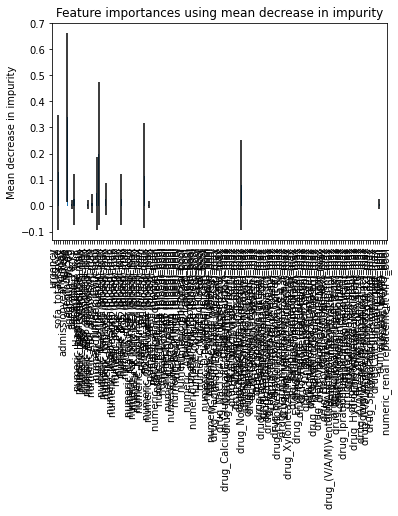

In [463]:
importances = clf.feature_importances_
s_std = np.std([
    tree.feature_importances_ for tree in clf.estimators_], axis=0)

s_feature_names = train_df.columns
s_forest_importances = pd.Series(importances, index=s_feature_names)

fig, ax = plt.subplots()
s_forest_importances.plot.bar(yerr=s_std, ax=ax)
ax.set_title("Feature importances using mean decrease in impurity")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

12

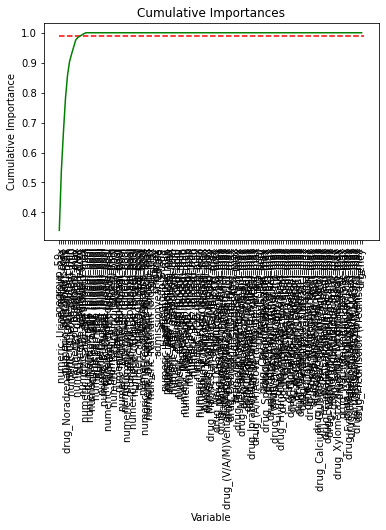

In [464]:
cutoff = 0.99
# List of features sorted from most to least important
# Cumulative importances
cumulative_importances = np.cumsum(s_forest_importances.sort_values(ascending=False))
# Make a line graph
plt.plot(range(cumulative_importances.shape[0]), cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = cutoff, xmin=0, xmax=cumulative_importances.shape[0], color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(range(cumulative_importances.shape[0]), cumulative_importances.index, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances')

np.where(cumulative_importances > cutoff)[0][0] + 1

In [465]:
print('\n'.join(cumulative_importances.index[:(np.where(cumulative_importances > cutoff)[0][0] + 1)]))

agegroup_59-
numeric_Urine output_max
sofa_total_score
numeric_pH (bloed)_max
drug_Noradrenaline (Norepinefrine)_max
numeric_Urine output_min
numeric_Glucose (bloed)_min
agegroup_80+
numeric_B.E. (bloed)_max
numeric_ABP diastolisch_max
numeric_ventilation_bool
agegroup_70-79


In [466]:
s_fpr, s_tpr, s_thresholds = roc_curve(test_outcome, clf.predict_proba(test_df)[:,1])
s_roc_auc = roc_auc_score(test_outcome, clf.predict_proba(test_df)[:,1])
def roc_auc_ci_fun(roc_auc, n1, n2):
  q0 = roc_auc * (1 - roc_auc)
  q1 = roc_auc / (2 - roc_auc) - roc_auc ** 2
  q2 = 2 * roc_auc ** 2 / (1 + roc_auc) - roc_auc ** 2
  se = np.sqrt(((q0 + (n1 - 1) * q1 + (n2 - 1) * q2)) / (n1 * n2))
  ci = roc_auc + np.array([-1, 1]) * 1.959964 * se
  return roc_auc, ci[0], ci[1]
roc_auc_ci_fun(s_roc_auc, (test_outcome == 1).sum(), (test_outcome == 0).sum())

(0.7368627450980392, 0.6678492789863706, 0.8058762112097078)

Sepsis RF: reduced model

In [467]:
s_reduced_variables = cumulative_importances.index[:(np.where(cumulative_importances > cutoff)[0][0] + 1)]

reduced_train_df = train_df[s_reduced_variables]
reduced_test_df = test_df[s_reduced_variables]

reduced_train_df.shape

(1091, 12)

In [231]:
for ii in hyperparameter_search_df.index:
  hyperparameter_search_df.iloc[ii, 3:], _ = rf_compute(reduced_train_df, train_outcome, \
      max_depth = hyperparameter_search_df.loc[ii, 'max_depth'], \
      min_samples_leaf = hyperparameter_search_df.loc[ii, 'min_samples_leaf'], \
      ccp_alpha = hyperparameter_search_df.loc[ii, 'ccp_alpha'])

In [232]:
hyperparameter_search_df.sort_values(by = 'val_roc_auc', ascending=False).head(10)

max_depth  min_samples_leaf  ... val_accuracy val_roc_auc
41         12                 5  ...     0.695698    0.758718
21          8                 5  ...     0.693871    0.755553
17          4                25  ...     0.685614    0.755315
25          8                10  ...     0.686561    0.755094
48         12                15  ...     0.707633    0.754863
45         12                10  ...     0.683805    0.754473
0           4                 5  ...     0.713121    0.754447
36          8                25  ...     0.698463    0.754018
33          8                20  ...     0.687466    0.753963
5           4                10  ...     0.684714    0.753904

[10 rows x 11 columns]

In [468]:
sr_max_depth, sr_min_samples_leaf, sr_ccp_alpha = 4, 25, 0.02 ## has among the best validation ROC AUC, plus good sensitivity

_, performance_df = rf_compute(reduced_train_df, train_outcome, \
      max_depth = sr_max_depth, min_samples_leaf = sr_min_samples_leaf, \
      ccp_alpha = sr_ccp_alpha)

print(performance_df)

sr_summary = ['%0.3f' % x + ' (' + '%0.3f' % y + ')' for x, y in zip(performance_df.mean(axis = 0), performance_df.std(axis = 0))]
print('\n'.join(sr_summary))

  train_specificity train_sensitivity  ... val_accuracy val_roc_auc
0          0.734375          0.755952  ...     0.680365    0.727737
1          0.678014          0.797619  ...     0.697248    0.744859
2          0.680851          0.785714  ...     0.711009    0.811147
3          0.723404          0.767857  ...     0.655963    0.702787
4          0.686525          0.785714  ...     0.683486    0.790043

[5 rows x 8 columns]
0.701 (0.026)
0.779 (0.017)
0.716 (0.018)
0.803 (0.009)
0.681 (0.020)
0.705 (0.102)
0.686 (0.021)
0.755 (0.045)


In [469]:
clf = RandomForestClassifier(n_estimators=100, random_state=0, \
        max_depth=sr_max_depth, min_samples_leaf=sr_min_samples_leaf, ccp_alpha=sr_ccp_alpha, \
        max_features='sqrt', criterion='entropy', class_weight='balanced')

clf.fit(reduced_train_df, train_outcome)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.02, class_weight='balanced',
                       criterion='entropy', max_depth=4, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=25, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

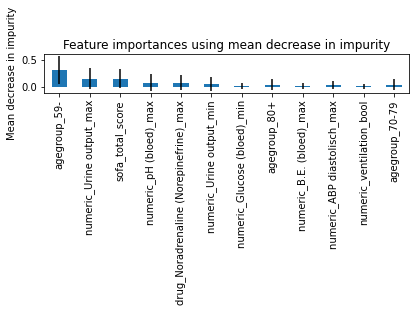

In [470]:
importances = clf.feature_importances_
sr_std = np.std([
    tree.feature_importances_ for tree in clf.estimators_], axis=0)

sr_feature_names = reduced_train_df.columns
sr_forest_importances = pd.Series(importances, index=sr_feature_names)

fig, ax = plt.subplots()
sr_forest_importances.plot.bar(yerr=sr_std, ax=ax)
ax.set_title("Feature importances using mean decrease in impurity")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [471]:
sr_fpr, sr_tpr, sr_thresholds = roc_curve(test_outcome, clf.predict_proba(reduced_test_df)[:,1])
sr_roc_auc = roc_auc_score(test_outcome, clf.predict_proba(reduced_test_df)[:,1])
sr_roc_auc
roc_auc_ci_fun(sr_roc_auc, (test_outcome == 1).sum(), (test_outcome == 0).sum())

(0.7588235294117648, 0.6915257169931447, 0.8261213418303849)

**CABG/valve surgery**

In [472]:
cardiosurg_df = model_df.loc[model_df['is_cardiosurg'] == 1, :].drop(columns = ['is_cardiosurg', 'is_sepsis'])
cardiosurg_df.columns

cardiosurg_df = cardiosurg_df.loc[cardiosurg_df.drop(columns = ['afib_time']).isna().sum(axis = 1) == 0, :]

In [473]:
train_df, test_df, train_outcome, test_outcome = \
  train_test_split(cardiosurg_df.drop(columns = ['admissionid', 'afib', 'afib_time', 'outcome_time', 'dischargedat']), \
                   cardiosurg_df['afib'], random_state=0, train_size=0.8)

In [474]:
train_df.shape, test_df.shape, train_outcome.shape, test_outcome.shape

((3517, 148), (880, 148), (3517,), (880,))

In [241]:
for ii in hyperparameter_search_df.index:
  hyperparameter_search_df.iloc[ii, 3:], _ = rf_compute(train_df, train_outcome, \
      max_depth = hyperparameter_search_df.loc[ii, 'max_depth'], \
      min_samples_leaf = hyperparameter_search_df.loc[ii, 'min_samples_leaf'], \
      ccp_alpha = hyperparameter_search_df.loc[ii, 'ccp_alpha'])

In [242]:
hyperparameter_search_df.sort_values(by = 'val_sensitivity', ascending=False).head(10)

max_depth  min_samples_leaf  ... val_accuracy val_roc_auc
57         12                25  ...     0.806938    0.820583
37          8                25  ...     0.807791    0.819761
45         12                10  ...     0.808358    0.817845
53         12                20  ...     0.811484    0.818663
29          8                15  ...     0.808359     0.82084
41         12                 5  ...     0.809211    0.821343
33          8                20  ...     0.810917    0.817941
49         12                15  ...     0.810632    0.822145
17          4                25  ...     0.813762    0.817514
25          8                10  ...     0.808073    0.817768

[10 rows x 11 columns]

In [475]:
c_max_depth, c_min_samples_leaf, c_ccp_alpha = 12, 25, 0.02 ## has among the best validation ROC AUC, plus good sensitivity

_, performance_df = rf_compute(train_df, train_outcome, \
      max_depth = c_max_depth, min_samples_leaf = c_min_samples_leaf, \
      ccp_alpha = c_ccp_alpha)

print(performance_df)

c_summary = ['%0.3f' % x + ' (' + '%0.3f' % y + ')' for x, y in zip(performance_df.mean(axis = 0), performance_df.std(axis = 0))]
print('\n'.join(c_summary))

  train_specificity train_sensitivity  ... val_accuracy val_roc_auc
0          0.832372          0.768868  ...      0.81108    0.764426
1          0.805459          0.754717  ...     0.802557    0.888358
2          0.813989          0.768868  ...     0.823613    0.816372
3          0.817448          0.783019  ...     0.789474     0.78894
4          0.826672          0.759434  ...     0.807966    0.844819

[5 rows x 8 columns]
0.819 (0.011)
0.767 (0.011)
0.815 (0.010)
0.873 (0.013)
0.816 (0.016)
0.691 (0.102)
0.807 (0.012)
0.821 (0.048)


In [476]:
clf = RandomForestClassifier(n_estimators=100, random_state=0, \
        max_depth=c_max_depth, min_samples_leaf=c_min_samples_leaf, ccp_alpha=c_ccp_alpha, \
        max_features='sqrt', criterion='entropy', class_weight='balanced')

clf.fit(train_df, train_outcome)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.02, class_weight='balanced',
                       criterion='entropy', max_depth=12, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=25, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

30

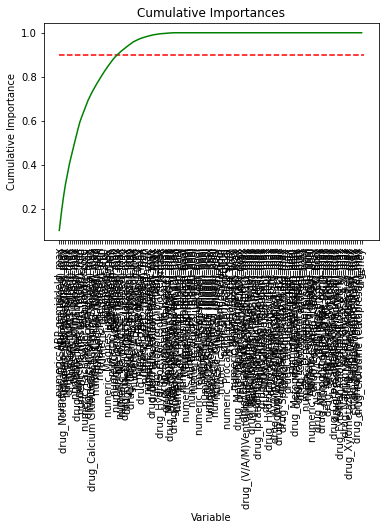

In [477]:
importances = clf.feature_importances_
c_std = np.std([
    tree.feature_importances_ for tree in clf.estimators_], axis=0)

c_feature_names = train_df.columns
c_forest_importances = pd.Series(importances, index=c_feature_names)

cutoff = 0.9
# List of features sorted from most to least important
# Cumulative importances
cumulative_importances = np.cumsum(c_forest_importances.sort_values(ascending=False))
# Make a line graph
plt.plot(range(cumulative_importances.shape[0]), cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = cutoff, xmin=0, xmax=cumulative_importances.shape[0], color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(range(cumulative_importances.shape[0]), cumulative_importances.index, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances')

np.where(cumulative_importances > cutoff)[0][0] + 1

In [478]:
print('\n'.join(cumulative_importances.index[:(np.where(cumulative_importances > cutoff)[0][0] + 1)]))

numeric_ABP gemiddeld_max
numeric_O2-Saturatie (bloed)_min
drug_Noradrenaline (Norepinefrine)_max
numeric_ABP systolisch_max
numeric_ABP diastolisch_max
drug_Enoximon (Perfan)_max
numeric_APTT (bloed)_min
numeric_Urine output_max
numeric_Natrium (bloed)_max
drug_Dobutamine (Dobutrex)_max
numeric_Natrium (bloed)_min
numeric_Magnesium (bloed)_min
sofa_total_score
numeric_Pacemaker Frequentie_bool
drug_Calciumgluconaat 10%_max
numeric_K (onv.ISE) (bloed)_min
drug_Calcium Glubionaat (Calcium Sandoz)_max
numeric_pCO2 (bloed)_max
numeric_Lactaat (bloed)_bool
numeric_pH (bloed)_max
numeric_Urine output_min
numeric_pH (bloed)_min
agegroup_80+
agegroup_59-
numeric_Magnesium (bloed)_max
agegroup_60-69
numeric_PO2 (bloed)_min
numeric_Glucose (bloed)_min
numeric_K (onv.ISE) (bloed)_max
numeric_APTT (bloed)_max


In [479]:
c_fpr, c_tpr, c_thresholds = roc_curve(test_outcome, clf.predict_proba(test_df)[:,1])
c_roc_auc = roc_auc_score(test_outcome, clf.predict_proba(test_df)[:,1])
c_roc_auc
roc_auc_ci_fun(c_roc_auc, (test_outcome == 1).sum(), (test_outcome == 0).sum())

(0.8085075772108192, 0.7490793918797779, 0.8679357625418606)

Cardiothoracic RF: reduced model

In [480]:
c_reduced_variables = cumulative_importances.index[:(np.where(cumulative_importances > cutoff)[0][0] + 1)]

reduced_train_df = train_df[c_reduced_variables]
reduced_test_df = test_df[c_reduced_variables]

In [252]:
for ii in hyperparameter_search_df.index:
  hyperparameter_search_df.iloc[ii, 3:], _ = rf_compute(reduced_train_df, train_outcome, \
      max_depth = hyperparameter_search_df.loc[ii, 'max_depth'], \
      min_samples_leaf = hyperparameter_search_df.loc[ii, 'min_samples_leaf'], \
      ccp_alpha = hyperparameter_search_df.loc[ii, 'ccp_alpha'])

In [255]:
hyperparameter_search_df.sort_values(by = 'val_sensitivity', ascending=False).head(10)

max_depth  min_samples_leaf  ... val_accuracy val_roc_auc
45         12                10  ...     0.791581    0.810894
57         12                25  ...     0.783905    0.812373
37          8                25  ...     0.787035    0.812368
33          8                20  ...     0.782483    0.807754
53         12                20  ...     0.787032    0.808829
49         12                15  ...     0.783616    0.811693
50         12                15  ...     0.787034    0.801108
21          8                 5  ...     0.790443    0.813076
17          4                25  ...     0.796985    0.808163
29          8                15  ...     0.785325    0.809905

[10 rows x 11 columns]

In [481]:
cr_max_depth, cr_min_samples_leaf, cr_ccp_alpha = 12, 10, 0.02 ## has among the best validation ROC AUC, plus good sensitivity

_, performance_df = rf_compute(reduced_train_df, train_outcome, \
      max_depth = cr_max_depth, min_samples_leaf = cr_min_samples_leaf, \
      ccp_alpha = cr_ccp_alpha)

print(performance_df)

cr_summary = ['%0.3f' % x + ' (' + '%0.3f' % y + ')' for x, y in zip(performance_df.mean(axis = 0), performance_df.std(axis = 0))]
print('\n'.join(cr_summary))

  train_specificity train_sensitivity  ... val_accuracy val_roc_auc
0          0.814687          0.773585  ...     0.794034    0.756079
1          0.798539          0.740566  ...     0.798295     0.87575
2          0.789008          0.778302  ...     0.795164     0.80627
3          0.800154          0.801887  ...     0.770982    0.774804
4          0.810915          0.754717  ...     0.799431    0.841567

[5 rows x 8 columns]
0.803 (0.010)
0.770 (0.023)
0.800 (0.009)
0.869 (0.011)
0.800 (0.011)
0.694 (0.117)
0.792 (0.012)
0.811 (0.049)


In [482]:
clf = RandomForestClassifier(n_estimators=100, random_state=0, \
        max_depth=cr_max_depth, min_samples_leaf=cr_min_samples_leaf, ccp_alpha=cr_ccp_alpha, \
        max_features='sqrt', criterion='entropy', class_weight='balanced')

clf.fit(reduced_train_df, train_outcome)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.02, class_weight='balanced',
                       criterion='entropy', max_depth=12, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

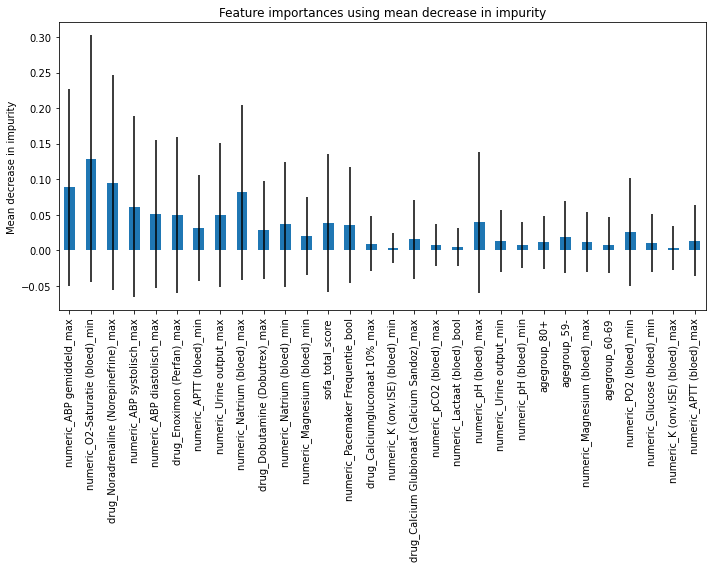

In [483]:
importances = clf.feature_importances_
cr_std = np.std([
    tree.feature_importances_ for tree in clf.estimators_], axis=0)

cr_feature_names = reduced_train_df.columns
cr_forest_importances = pd.Series(importances, index=cr_feature_names)

fig, ax = plt.subplots(figsize = [10,8])
cr_forest_importances.plot.bar(yerr=cr_std, ax=ax)
ax.set_title("Feature importances using mean decrease in impurity")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [484]:
cr_fpr, cr_tpr, cr_thresholds = roc_curve(test_outcome, clf.predict_proba(reduced_test_df)[:,1])
cr_roc_auc = roc_auc_score(test_outcome, clf.predict_proba(reduced_test_df)[:,1])
roc_auc_ci_fun(cr_roc_auc, (test_outcome == 1).sum(), (test_outcome == 0).sum())

(0.8022891489225654, 0.7422330599993021, 0.8623452378458287)

**Mixed aetiology**

In [485]:
mixed_df = model_df.loc[(model_df['is_cardiosurg'] == 0) & (model_df['is_sepsis'] == 0), :].drop(columns = ['is_cardiosurg', 'is_sepsis'])
mixed_df.columns

mixed_df = mixed_df.loc[mixed_df.drop(columns = ['afib_time']).isna().sum(axis = 1) == 0, :]

In [486]:
train_df, test_df, train_outcome, test_outcome = \
  train_test_split(mixed_df.drop(columns = ['admissionid', 'afib', 'afib_time', 'outcome_time', 'dischargedat']), \
                   mixed_df['afib'], random_state=0, train_size=0.8)

In [487]:
train_df.shape, test_df.shape, train_outcome.shape, test_outcome.shape

((7264, 148), (1817, 148), (7264,), (1817,))

In [263]:
for ii in hyperparameter_search_df.index:
  hyperparameter_search_df.iloc[ii, 3:], _ = rf_compute(train_df, train_outcome, \
      max_depth = hyperparameter_search_df.loc[ii, 'max_depth'], \
      min_samples_leaf = hyperparameter_search_df.loc[ii, 'min_samples_leaf'], \
      ccp_alpha = hyperparameter_search_df.loc[ii, 'ccp_alpha'])

In [265]:
hyperparameter_search_df.sort_values(by = 'val_roc_auc', ascending=False).head(10)

max_depth  min_samples_leaf  ... val_accuracy val_roc_auc
48         12                15  ...     0.727011    0.808612
40         12                 5  ...      0.73293    0.808603
44         12                10  ...     0.729901    0.808431
56         12                25  ...     0.729489    0.807866
36          8                25  ...     0.728387     0.80758
20          8                 5  ...     0.729075    0.807368
32          8                20  ...     0.729764     0.80718
24          8                10  ...     0.730038    0.807027
28          8                15  ...     0.727561     0.80618
52         12                20  ...      0.72825    0.805263

[10 rows x 11 columns]

In [488]:
m_max_depth, m_min_samples_leaf, m_ccp_alpha = 12, 15, 0.01 ## has among the best validation ROC AUC, plus good sensitivity

_, performance_df = rf_compute(train_df, train_outcome, \
      max_depth = m_max_depth, min_samples_leaf = m_min_samples_leaf, \
      ccp_alpha = m_ccp_alpha)

print(performance_df)

  train_specificity train_sensitivity  ... val_accuracy val_roc_auc
0          0.739927          0.787456  ...     0.729525    0.813756
1          0.736872          0.783972  ...     0.711631    0.793861
2          0.735204          0.795812  ...      0.73159    0.815985
3          0.720886          0.797557  ...     0.725396    0.806028
4          0.727759          0.789199  ...     0.736915    0.813427

[5 rows x 8 columns]


In [489]:
clf = RandomForestClassifier(n_estimators=100, random_state=0, \
        max_depth=m_max_depth, min_samples_leaf=m_min_samples_leaf, ccp_alpha=m_ccp_alpha, \
        max_features='sqrt', criterion='entropy', class_weight='balanced')

clf.fit(train_df, train_outcome)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.01, class_weight='balanced',
                       criterion='entropy', max_depth=12, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=15, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [490]:
m_summary = ['%0.3f' % x + ' (' + '%0.3f' % y + ')' for x, y in zip(performance_df.mean(axis = 0), performance_df.std(axis = 0))]
print('\n'.join(m_summary))

0.732 (0.008)
0.791 (0.006)
0.738 (0.007)
0.839 (0.001)
0.725 (0.013)
0.742 (0.027)
0.727 (0.010)
0.809 (0.009)


27

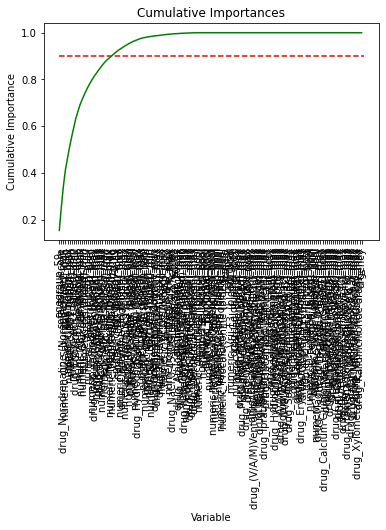

In [491]:
importances = clf.feature_importances_
m_std = np.std([
    tree.feature_importances_ for tree in clf.estimators_], axis=0)

m_feature_names = train_df.columns
m_forest_importances = pd.Series(importances, index=m_feature_names)

cutoff = 0.9
# List of features sorted from most to least important
# Cumulative importances
cumulative_importances = np.cumsum(m_forest_importances.sort_values(ascending=False))
# Make a line graph
plt.plot(range(cumulative_importances.shape[0]), cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = cutoff, xmin=0, xmax=cumulative_importances.shape[0], color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(range(cumulative_importances.shape[0]), cumulative_importances.index, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances')

np.where(cumulative_importances > cutoff)[0][0] + 1

In [492]:
print('\n'.join(cumulative_importances.index[:(np.where(cumulative_importances > cutoff)[0][0] + 1)]))

agegroup_59-
sofa_total_score
drug_Noradrenaline (Norepinefrine)_max
numeric_O2-Saturatie (bloed)_min
numeric_ventilation_bool
numeric_Urine output_max
numeric_PO2 (bloed)_min
numeric_APTT (bloed)_min
drug_Enoximon (Perfan)_max
agegroup_80+
numeric_Urine output_min
numeric_ABP gemiddeld_max
numeric_Glucose (bloed)_min
numeric_pH (bloed)_min
numeric_APTT (bloed)_max
numeric_CVD_bool
numeric_TroponineT (bloed)_bool
drug_Dobutamine (Dobutrex)_max
numeric_Glucose (bloed)_max
drug_Propofol (Diprivan)_max
numeric_ABP systolisch_max
numeric_K (onv.ISE) (bloed)_max
numeric_ABP diastolisch_max
numeric_B.E. (bloed)_min
drug_Dexamethason_max
numeric_Magnesium (bloed)_max
numeric_Magnesium (bloed)_min


In [493]:
m_fpr, m_tpr, m_thresholds = roc_curve(test_outcome, clf.predict_proba(test_df)[:,1])
m_roc_auc = roc_auc_score(test_outcome, clf.predict_proba(test_df)[:,1])
roc_auc_ci_fun(m_roc_auc, (test_outcome == 1).sum(), (test_outcome == 0).sum())

(0.7841578305955499, 0.7418224491456459, 0.8264932120454539)

In [494]:
m_reduced_variables = cumulative_importances.index[:(np.where(cumulative_importances > cutoff)[0][0] + 1)]

reduced_train_df = train_df[m_reduced_variables]
reduced_test_df = test_df[m_reduced_variables]

In [274]:
for ii in hyperparameter_search_df.index:
  hyperparameter_search_df.iloc[ii, 3:], _ = rf_compute(reduced_train_df, train_outcome, \
      max_depth = hyperparameter_search_df.loc[ii, 'max_depth'], \
      min_samples_leaf = hyperparameter_search_df.loc[ii, 'min_samples_leaf'], \
      ccp_alpha = hyperparameter_search_df.loc[ii, 'ccp_alpha'])

In [276]:
hyperparameter_search_df.sort_values(by = 'val_roc_auc', ascending=False).head(10)

max_depth  min_samples_leaf  ... val_accuracy val_roc_auc
56         12                25  ...     0.725222    0.805158
40         12                 5  ...     0.720954    0.804685
48         12                15  ...     0.722192    0.804168
36          8                25  ...     0.723157    0.803956
20          8                 5  ...      0.72233      0.8035
44         12                10  ...     0.725358    0.803492
52         12                20  ...     0.723295     0.80342
32          8                20  ...     0.722193    0.802864
28          8                15  ...     0.725634    0.802734
24          8                10  ...     0.721919    0.802656

[10 rows x 11 columns]

In [495]:
mr_max_depth, mr_min_samples_leaf, mr_ccp_alpha = 12, 25, 0.01 ## has among the best validation ROC AUC, plus good sensitivity

_, performance_df = rf_compute(reduced_train_df, train_outcome, \
      max_depth = mr_max_depth, min_samples_leaf = mr_min_samples_leaf, \
      ccp_alpha = mr_ccp_alpha)

print(performance_df)

mr_summary = ['%0.3f' % x + ' (' + '%0.3f' % y + ')' for x, y in zip(performance_df.mean(axis = 0), performance_df.std(axis = 0))]
print('\n'.join(mr_summary))

  train_specificity train_sensitivity  ... val_accuracy val_roc_auc
0          0.727516          0.777003  ...     0.722643    0.806027
1          0.732289          0.773519  ...      0.70819    0.793509
2          0.740168          0.753927  ...      0.74329    0.818967
3           0.71554          0.787086  ...      0.71576    0.796887
4          0.733868          0.778746  ...     0.736226    0.810398

[5 rows x 8 columns]
0.730 (0.009)
0.774 (0.012)
0.734 (0.007)
0.835 (0.001)
0.726 (0.017)
0.716 (0.032)
0.725 (0.014)
0.805 (0.010)


In [496]:
clf = RandomForestClassifier(n_estimators=100, random_state=0, \
        max_depth=mr_max_depth, min_samples_leaf=mr_min_samples_leaf, ccp_alpha=mr_ccp_alpha, \
        max_features='sqrt', criterion='entropy', class_weight='balanced')

clf.fit(reduced_train_df, train_outcome)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.01, class_weight='balanced',
                       criterion='entropy', max_depth=12, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=25, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

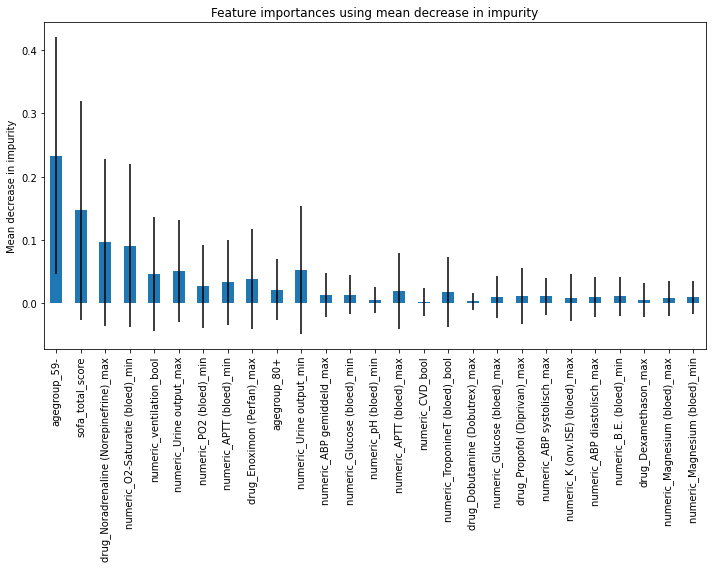

In [497]:
importances = clf.feature_importances_
mr_std = np.std([
    tree.feature_importances_ for tree in clf.estimators_], axis=0)

mr_feature_names = reduced_train_df.columns
mr_forest_importances = pd.Series(importances, index=mr_feature_names)

fig, ax = plt.subplots(figsize = [10,8])
mr_forest_importances.plot.bar(yerr=mr_std, ax=ax)
ax.set_title("Feature importances using mean decrease in impurity")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [498]:
mr_fpr, mr_tpr, mr_thresholds = roc_curve(test_outcome, clf.predict_proba(reduced_test_df)[:,1])
mr_roc_auc = roc_auc_score(test_outcome, clf.predict_proba(reduced_test_df)[:,1])
roc_auc_ci_fun(mr_roc_auc, (test_outcome == 1).sum(), (test_outcome == 0).sum())

(0.7865112783052258, 0.7443175522502674, 0.8287050043601842)

**ROC curve**

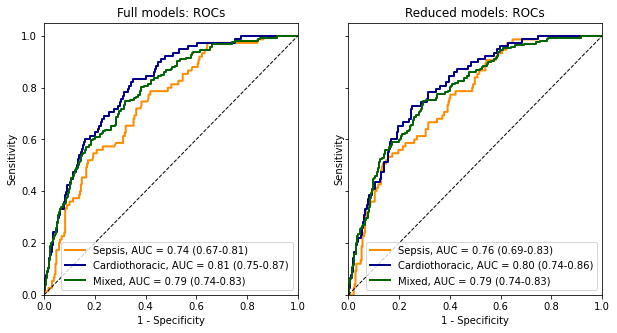

In [499]:
fig, ax = plt.subplots(ncols=2,nrows=1,sharey=True,figsize=[10,5])
# ax[0].plot(s_fpr, s_tpr, color='darkorange',
#          lw=2, label='Sepsis (AUC = ' + '%0.3f' % s_roc_auc + ')')
# ax[0].plot(c_fpr, c_tpr, color='darkblue',
#          lw=2, label='Cardiothoracic (AUC = ' + '%0.3f' % c_roc_auc + ')')
# ax[0].plot(m_fpr, m_tpr, color='darkgreen',
#          lw=2, label='Mixed aetiology (AUC = ' + '%0.3f' % m_roc_auc + ')')
ax[0].plot(s_fpr, s_tpr, color='darkorange',
         lw=2, label='Sepsis, AUC = 0.74 (0.67-0.81)')
ax[0].plot(c_fpr, c_tpr, color='darkblue',
         lw=2, label='Cardiothoracic, AUC = 0.81 (0.75-0.87)')
ax[0].plot(m_fpr, m_tpr, color='darkgreen',
         lw=2, label='Mixed, AUC = 0.79 (0.74-0.83)')
ax[0].set_title('Full models: ROCs')
ax[0].plot([0, 1], [0, 1], color='k', lw=1, linestyle='--')
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel('1 - Specificity')
ax[0].set_ylabel('Sensitivity')
ax[0].legend(loc="lower right")

ax[1].plot(sr_fpr, sr_tpr, color='darkorange',
         lw=2, label='Sepsis, AUC = 0.76 (0.69-0.83)')
ax[1].plot(cr_fpr, cr_tpr, color='darkblue',
         lw=2, label='Cardiothoracic, AUC = 0.80 (0.74-0.86)')
ax[1].plot(mr_fpr, mr_tpr, color='darkgreen',
         lw=2, label='Mixed, AUC = 0.79 (0.74-0.83)')
ax[1].set_title('Reduced models: ROCs')
ax[1].plot([0, 1], [0, 1], color='k', lw=1, linestyle='--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('1 - Specificity')
ax[1].set_ylabel('Sensitivity')
ax[1].legend(loc="lower right")

fig.show()

#Cox model

**Sepsis**

In [528]:
sepsis_cox_df = sepsis_df[['afib', 'outcome_time'] + list(s_reduced_variables)]

In [529]:
# sepsis_cox_df = sepsis_cox_df[(sepsis_cox_df['outcome_time'] < 24*60)]

In [530]:
continuous_predictors = s_reduced_variables[~sepsis_cox_df[s_reduced_variables].isin([0,1]).all()]

# Normalise continuous predictors
sepsis_cox_df[continuous_predictors] = (sepsis_cox_df[continuous_predictors] - \
                                      sepsis_cox_df[continuous_predictors].mean()) / sepsis_cox_df[continuous_predictors].std()
# sepsis_cox_df.std(axis = 0)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [531]:
cph_s = CoxPHFitter(penalizer=0.1)
cph_s.fit(sepsis_cox_df, duration_col='outcome_time', event_col='afib')

cph_s.print_summary()  # access the individual results using cph.summary

<lifelines.CoxPHFitter: fitted with 1455 total observations, 1170 right-censored observations>
             duration col = 'outcome_time'
                event col = 'afib'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1455
number of events observed = 285
   partial log-likelihood = -1874.81
         time fit was run = 2021-05-27 15:27:59 UTC

---
                                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                      
agegroup_59-                            -0.58       0.56       0.12            -0.80            -0.35                 0.45                 0.70
numeric_Urine output_max                -0.24       0.79       0.05            -0.34            -0.13                 0.71                 0.88
sofa_total_score                         0.18       1.20       0.05             0.08             0.28                 1.08                 1.32
numeric_pH (bloed)_max                  -0.10       0.90       0.04            -0.18            -0.02                 0.83                 0.98
drug_Noradrenaline (Norepinefrine)_max   0.04       1.04       0.05            -0.06             0.14                 0.94                 1.15
numeric_Urine output_min                 0.15       1.16       0.05             0.04             0.25                 1.04                 1.28
numeric_Glucose (bloed)_min              0.19       1.20       0.04             0.10             0.27                 1.11                 1.31
agegroup_80+                             0.56       1.75       0.14             0.28             0.84                 1.33                 2.32
numeric_B.E. (bloed)_max                -0.02       0.98       0.05            -0.11             0.07                 0.89                 1.07
numeric_ABP diastolisch_max             -0.17       0.85       0.05            -0.26            -0.07                 0.77                 0.93
numeric_ventilation_bool                 0.16       1.17       0.12            -0.09             0.40                 0.92                 1.49
agegroup_70-79                           0.46       1.58       0.12             0.23             0.69                 1.26                 1.99

                                           z      p   -log2(p)
covariate                                                     
agegroup_59-                           -5.01 <0.005      20.83
numeric_Urine output_max               -4.44 <0.005      16.79
sofa_total_score                        3.45 <0.005      10.80
numeric_pH (bloed)_max                 -2.55   0.01       6.55
drug_Noradrenaline (Norepinefrine)_max  0.76   0.45       1.15
numeric_Urine output_min                2.72   0.01       7.25
numeric_Glucose (bloed)_min             4.45 <0.005      16.81
agegroup_80+                            3.94 <0.005      13.56
numeric_B.E. (bloed)_max               -0.50   0.62       0.70
numeric_ABP diastolisch_max            -3.33 <0.005      10.19
numeric_ventilation_bool                1.26   0.21       2.26
agegroup_70-79                          3.92 <0.005      13.48
---
Concordance = 0.77
Partial AIC = 3773.62
log-likelihood ratio test = 186.21 on 12 df
-log2(p) of ll-ratio test = 108.45

Residuals: Martindale

In [532]:
# r = cph_s.compute_residuals(sepsis_cox_df, 'martingale')
# r.plot.scatter(
#     x='afib_time', y='martingale', c=np.where(r['afib'], '#008fd5', '#fc4f30'),
#     alpha=0.75
# )

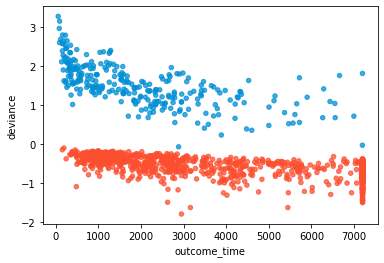

In [533]:
r = cph_s.compute_residuals(sepsis_cox_df, 'deviance')
r.plot.scatter(
    x='outcome_time', y='deviance', c=np.where(r['afib'], '#008fd5', '#fc4f30'),
    alpha=0.75
)

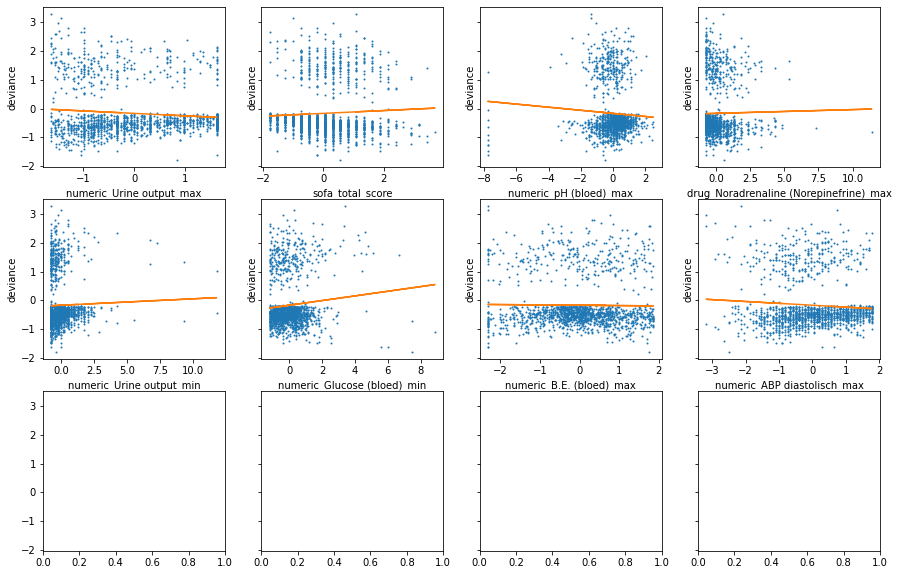

In [534]:
sepsis_with_residuals = pd.merge(sepsis_cox_df, r, left_index=True, right_index=True)
fig, ax = plt.subplots(figsize=(15,10), sharey=True, nrows = 3, ncols = 4)
rowcol = [(x, y) for x in range(5) for y in range(4)]
for ii in range(continuous_predictors.size):
    predictor = continuous_predictors[ii]
    ax_temp = ax[rowcol[ii]]
    ax_temp.plot(sepsis_with_residuals[predictor], sepsis_with_residuals['deviance'], 'o', markersize = 1)
    ax_temp.set_xlabel(predictor)
    ax_temp.set_ylabel('deviance')
    m, b = np.polyfit(sepsis_with_residuals[predictor], sepsis_with_residuals['deviance'], 1)
    ax_temp.plot(sepsis_with_residuals[predictor], m*sepsis_with_residuals[predictor] + b)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 1455 total observations, 1170 right-censored observations>
         test_name = proportional_hazard_test

---
                                             test_statistic      p  -log2(p)
agegroup_59-                           km              0.02   0.90      0.16
                                       rank            0.01   0.93      0.10
agegroup_70-79                         km              1.26   0.26      1.93
                                       rank            1.43   0.23      2.11
agegroup_80+                           km              2.68   0.10      3.30
                                       rank            2.69   0.10      3.31
drug_Noradrenaline (Norepinefrine)_max km              3.32   0.07      3.87
                                       rank            3.89   0.05      4.37
numeric_ABP diastolisch_max            km              7.41   0.01      7.27
                                       rank            7.86   0.01      7.63
numeric_B.E. (bloed)_max               km              0.01   0.92      0.11
                                       rank            0.00   1.00      0.01
numeric_Glucose (bloed)_min            km             20.07 <0.005     17.03
                                       rank           23.57 <0.005     19.66
numeric_Urine output_max               km             17.71 <0.005     15.25
                                       rank           19.40 <0.005     16.53
numeric_Urine output_min               km             15.66 <0.005     13.68
                                       rank           17.20 <0.005     14.86
numeric_pH (bloed)_max                 km              0.39   0.53      0.92
                                       rank            0.45   0.50      1.00
numeric_ventilation_bool               km              0.29   0.59      0.76
                                       rank            0.37   0.54      0.89
sofa_total_score                       km              2.93   0.09      3.52
                                       rank            3.34   0.07      3.88



1. Variable 'numeric_Urine output_max' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'numeric_Urine output_max' might be incorrect. That
is, there may be non-linear terms missing. The proportional hazard test used is very sensitive to
incorrect functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'numeric_Urine output_max' using pd.cut, and then specify it
in `strata=['numeric_Urine output_max', ...]` in the call in `.fit`. See documentation in link [B]
below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


2. Variable 'drug_Noradrenaline (Norepinefrine)_max' failed the non-proportional test: p-value is 0.0485.

   Advice 1: the functional form of the variable 'drug_Noradrenaline (Norepinefrine)_max' might be
incorrect. That is, there may 

[[<matplotlib.axes._subplots.AxesSubplot at 0x7ff9d81ac510>,

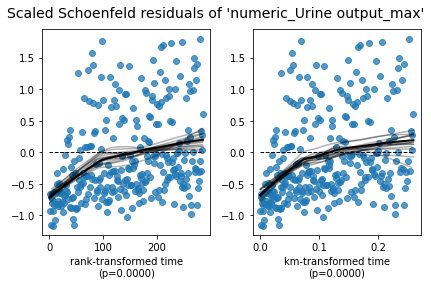

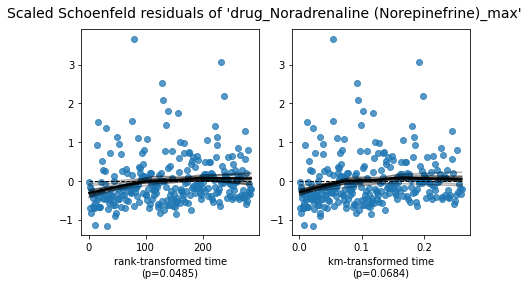

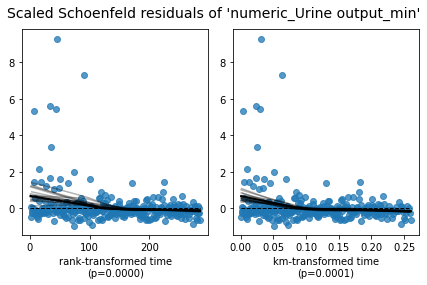

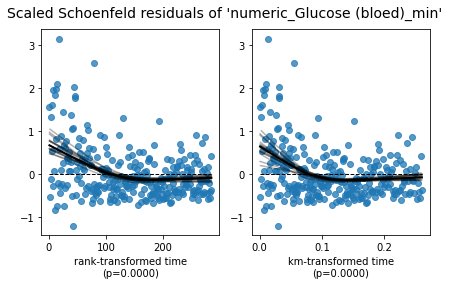

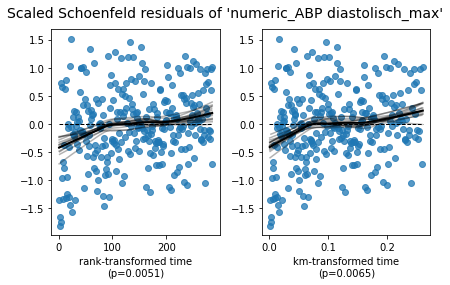

In [535]:
cph_s.check_assumptions(sepsis_cox_df, p_value_threshold=0.05, show_plots=True)

**CABG/valve surgery**

In [536]:
cardiosurg_cox_df = cardiosurg_df[['afib', 'outcome_time'] + list(c_reduced_variables)]

In [537]:
# cardiosurg_cox_df = cardiosurg_cox_df[(cardiosurg_cox_df['outcome_time'] < 24*60)]

In [538]:
continuous_predictors = c_reduced_variables[~cardiosurg_cox_df[c_reduced_variables].isin([0,1]).all()]

# Normalise continuous predictors
cardiosurg_cox_df[continuous_predictors] = (cardiosurg_cox_df[continuous_predictors] - \
                                          cardiosurg_cox_df[continuous_predictors].mean()) / cardiosurg_cox_df[continuous_predictors].std()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [539]:
cph_c = CoxPHFitter(penalizer=0.1)
cph_c.fit(cardiosurg_cox_df, duration_col='outcome_time', event_col='afib', step_size=0.1)

cph_c.print_summary()  # access the individual results using cph.summary

<lifelines.CoxPHFitter: fitted with 4397 total observations, 4054 right-censored observations>
             duration col = 'outcome_time'
                event col = 'afib'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 4397
number of events observed = 343
   partial log-likelihood = -2274.79
         time fit was run = 2021-05-27 15:28:10 UTC

---
                                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                            
numeric_ABP gemiddeld_max                     -0.09       0.91       0.04            -0.17            -0.02                 0.84                 0.98
numeric_O2-Saturatie (bloed)_min              -0.04       0.96       0.04            -0.11             0.04                 0.89                 1.04
drug_Noradrenaline (Norepinefrine)_max        -0.00       1.00       0.03            -0.06             0.05                 0.94                 1.05
numeric_ABP systolisch_max                    -0.11       0.89       0.04            -0.19            -0.04                 0.83                 0.96
numeric_ABP diastolisch_max                   -0.09       0.91       0.04            -0.17            -0.02                 0.85                 0.98
drug_Enoximon (Perfan)_max                     0.03       1.03       0.02            -0.02             0.07                 0.98                 1.07
numeric_APTT (bloed)_min                       0.11       1.11       0.04             0.04             0.17                 1.04                 1.19
numeric_Urine output_max                      -0.13       0.88       0.04            -0.20            -0.05                 0.82                 0.95
numeric_Natrium (bloed)_max                   -0.01       0.99       0.04            -0.08             0.07                 0.92                 1.07
drug_Dobutamine (Dobutrex)_max                 0.01       1.01       0.02            -0.03             0.06                 0.97                 1.07
numeric_Natrium (bloed)_min                    0.02       1.02       0.04            -0.06             0.09                 0.94                 1.10
numeric_Magnesium (bloed)_min                  0.08       1.09       0.04             0.01             0.16                 1.01                 1.17
sofa_total_score                               0.05       1.06       0.04            -0.01             0.12                 0.99                 1.13
numeric_Pacemaker Frequentie_bool              0.17       1.19       0.10            -0.02             0.36                 0.98                 1.44
drug_Calciumgluconaat 10%_max                 -0.02       0.98       0.04            -0.10             0.06                 0.91                 1.06
numeric_K (onv.ISE) (bloed)_min                0.03       1.03       0.04            -0.05             0.10                 0.95                 1.11
drug_Calcium Glubionaat (Calcium Sandoz)_max   0.02       1.02       0.04            -0.05             0.09                 0.95                 1.10
numeric_pCO2 (bloed)_max                       0.02       1.02       0.04            -0.05             0.09                 0.95                 1.10
numeric_Lactaat (bloed)_bool                  -0.09       0.91       0.08            -0.25             0.07                 0.78                 1.07
numeric_pH (bloed)_max                        -0.11       0.89       0.04            -0.19            -0.04                 0.83                 0.96
numeric_Urine output_min                       0.27       1.32       0.04             0.21             0.34                 1.23                 1.41
numeric_pH (bloed)_min                         0.06       1.06       0.04            -0.01             0.13           

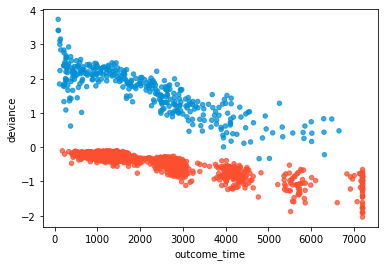

In [540]:
r = cph_c.compute_residuals(cardiosurg_cox_df, 'deviance')
r.plot.scatter(
    x='outcome_time', y='deviance', c=np.where(r['afib'], '#008fd5', '#fc4f30'),
    alpha=0.75
)

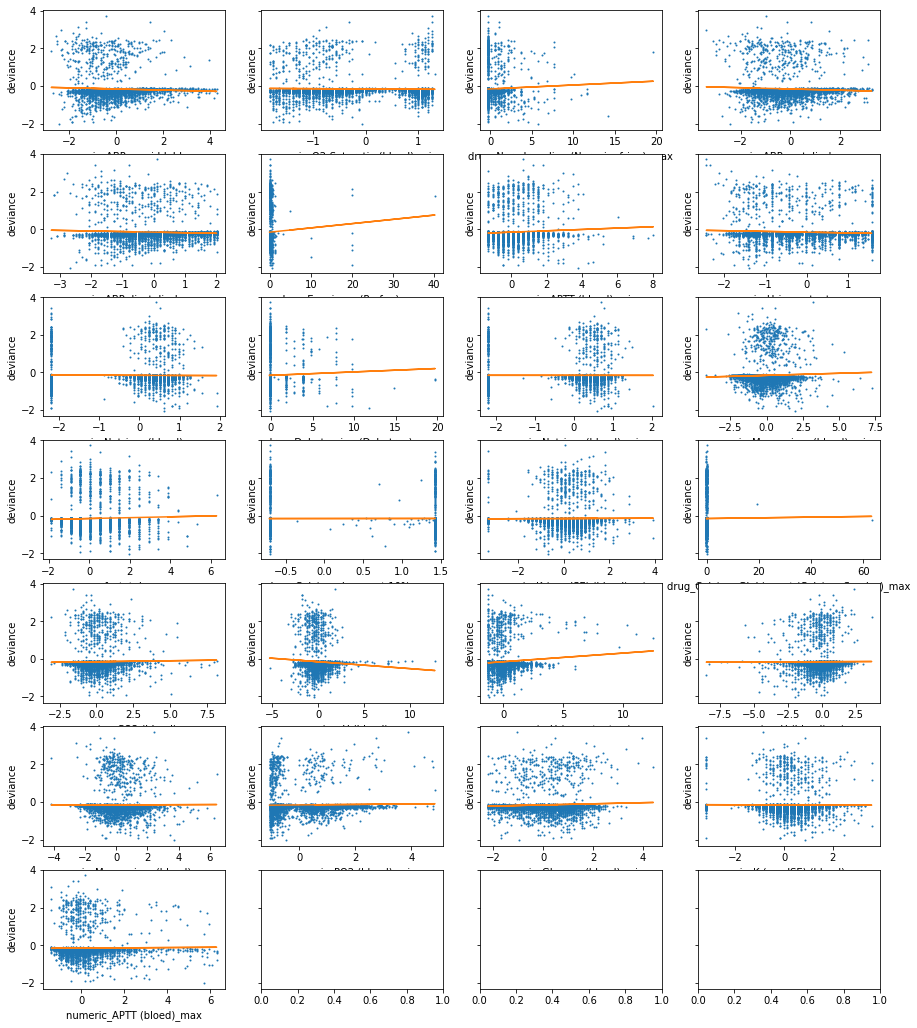

In [541]:
cardiosurg_with_residuals = pd.merge(cardiosurg_cox_df, r, left_index=True, right_index=True)
fig, ax = plt.subplots(figsize=(15,18), sharey=True, nrows = 7, ncols = 4)
rowcol = [(x, y) for x in range(7) for y in range(4)]
for ii in range(continuous_predictors.size):
    predictor = continuous_predictors[ii]
    ax_temp = ax[rowcol[ii]]
    ax_temp.plot(cardiosurg_with_residuals[predictor], cardiosurg_with_residuals['deviance'], 'o', markersize = 1)
    ax_temp.set_xlabel(predictor)
    ax_temp.set_ylabel('deviance')
    m, b = np.polyfit(cardiosurg_with_residuals[predictor], cardiosurg_with_residuals['deviance'], 1)
    ax_temp.plot(cardiosurg_with_residuals[predictor], m*cardiosurg_with_residuals[predictor] + b)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 4397 total observations, 4054 right-censored observations>
         test_name = proportional_hazard_test

---
                                                   test_statistic      p  -log2(p)
agegroup_59-                                 km              0.65   0.42      1.25
                                             rank            0.39   0.53      0.91
agegroup_60-69                               km              2.00   0.16      2.67
                                             rank            1.87   0.17      2.54
agegroup_80+                                 km              1.75   0.19      2.43
                                             rank            1.54   0.21      2.22
drug_Calcium Glubionaat (Calcium Sandoz)_max km              1.51   0.22      2.19
                                             rank            0.25   0.62      0.70
drug_Calciumgluconaat 10%_max                km              0.17   0.68      0.56
                                             rank            0.24   0.62      0.69
drug_Dobutamine (Dobutrex)_max               km              0.13   0.72      0.48
                                             rank            0.01   0.90      0.15
drug_Enoximon (Perfan)_max                   km              5.09   0.02      5.38
                                             rank            3.87   0.05      4.34
drug_Noradrenaline (Norepinefrine)_max       km              0.67   0.41      1.27
                                             rank            0.10   0.76      0.40
numeric_ABP diastolisch_max                  km              5.11   0.02      5.40
                                             rank            8.39 <0.005      8.05
numeric_ABP gemiddeld_max                    km              2.52   0.11      3.15
                                             rank            4.92   0.03      5.24
numeric_ABP systolisch_max                   km              4.12   0.04      4.56
                                             rank           10.52 <0.005      9.73
numeric_APTT (bloed)_max                     km              1.35   0.25      2.03
                                             rank            0.01   0.91      0.13
numeric_APTT (bloed)_min                     km              4.74   0.03      5.08
                                             rank            8.40 <0.005      8.06
numeric_Glucose (bloed)_min                  km              6.78   0.01      6.76
                                             rank           15.65 <0.005     13.68
numeric_K (onv.ISE) (bloed)_max              km              0.09   0.77      0.38
                                             rank            0.13   0.71      0.49
numeric_K (onv.ISE) (bloed)_min              km              0.81   0.37      1.44
                                             rank            0.42   0.52      0.95
numeric_Lactaat (bloed)_bool                 km              0.04   0.83      0.26
                                             rank            0.04   0.84      0.26
numeric_Magnesium (bloed)_max                km              0.84   0.36      1.48
                                             rank            1.22   0.27      1.89
numeric_Magnesium (bloed)_min                km              0.41   0.52      0.93
                                             rank            2.10   0.15      2.76
numeric_Natrium (bloed)_max                  km              0.32   0.57      0.81
                                             rank            0.50   0.48      1.07
numeric_Natrium (bloed)_min                  km              0.06   0.81      0.30
                                             rank            0.03   0.87      0.20
numeric_O2-Saturatie (bloed)_min             km              0.57   0.45      1.15
                                             rank            0.66   0



1. Variable 'numeric_ABP gemiddeld_max' failed the non-proportional test: p-value is 0.0265.

   Advice 1: the functional form of the variable 'numeric_ABP gemiddeld_max' might be incorrect.
That is, there may be non-linear terms missing. The proportional hazard test used is very sensitive
to incorrect functional forms. See documentation in link [D] below on how to specify a functional
form.

   Advice 2: try binning the variable 'numeric_ABP gemiddeld_max' using pd.cut, and then specify it
in `strata=['numeric_ABP gemiddeld_max', ...]` in the call in `.fit`. See documentation in link [B]
below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


2. Variable 'numeric_ABP systolisch_max' failed the non-proportional test: p-value is 0.0012.

   Advice 1: the functional form of the variable 'numeric_ABP systolisch_max' might be incorrect.
That is, there may be non-linear terms 

[[<matplotlib.axes._subplots.AxesSubplot at 0x7ff98a305d90>,

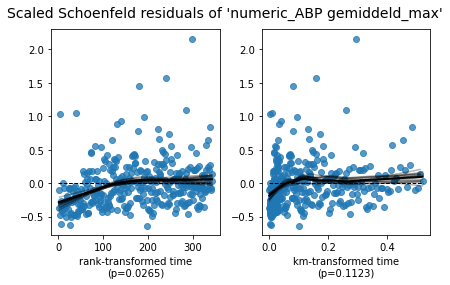

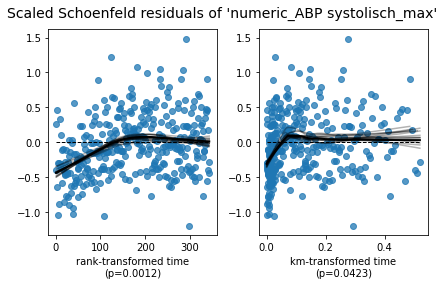

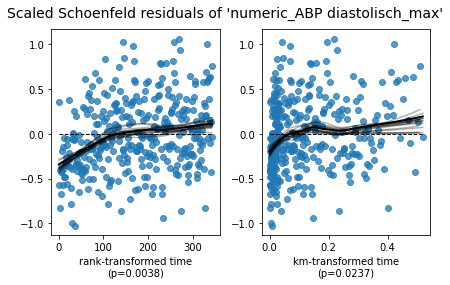

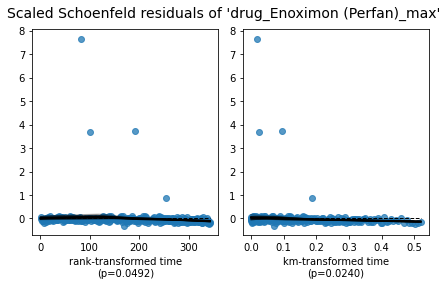

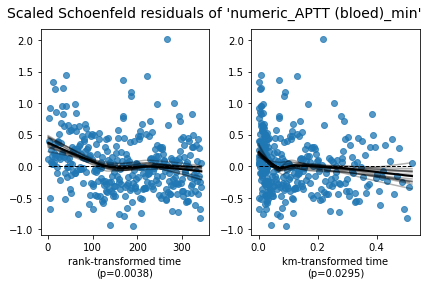

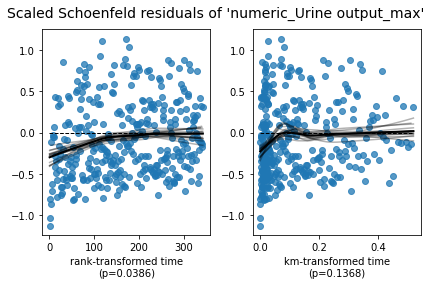

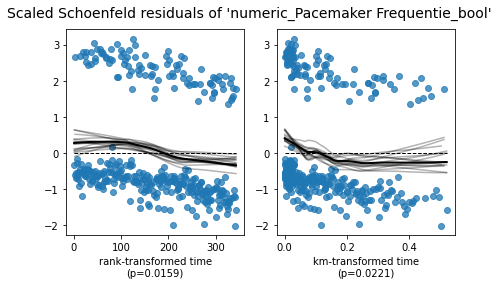

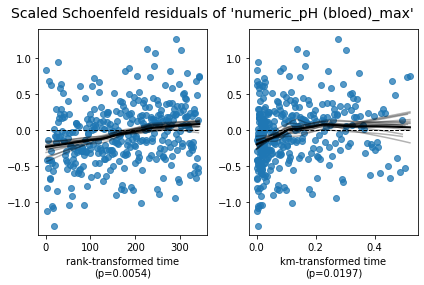

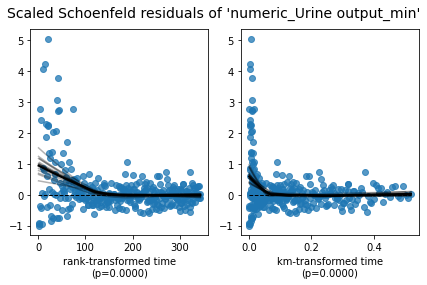

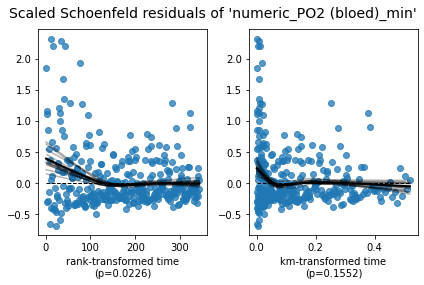

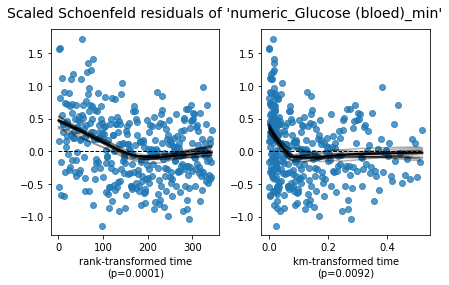

In [542]:
cph_c.check_assumptions(cardiosurg_cox_df, p_value_threshold=0.05, show_plots=True)

**Mixed aetiology**

In [543]:
mixed_cox_df = mixed_df[['afib', 'outcome_time'] + list(m_reduced_variables)]

In [544]:
# mixed_cox_df = mixed_cox_df[(mixed_cox_df['outcome_time'] < 24*60)]

In [545]:
continuous_predictors = m_reduced_variables[~mixed_cox_df[m_reduced_variables].isin([0,1]).all()]

# Normalise continuous predictors
mixed_cox_df[continuous_predictors] = (mixed_cox_df[continuous_predictors] - \
                                          mixed_cox_df[continuous_predictors].mean()) / mixed_cox_df[continuous_predictors].std()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [546]:
cph_m = CoxPHFitter(penalizer=0.1)
cph_m.fit(mixed_cox_df, duration_col='outcome_time', event_col='afib', step_size=0.1)

cph_m.print_summary()  # access the individual results using cph.summary

<lifelines.CoxPHFitter: fitted with 9081 total observations, 8198 right-censored observations>
             duration col = 'outcome_time'
                event col = 'afib'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 9081
number of events observed = 883
   partial log-likelihood = -7087.92
         time fit was run = 2021-05-27 15:28:39 UTC

---
                                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                      
agegroup_59-                            -0.52       0.59       0.05            -0.62            -0.42                 0.54                 0.66
sofa_total_score                         0.11       1.12       0.03             0.06             0.16                 1.06                 1.17
drug_Noradrenaline (Norepinefrine)_max   0.01       1.01       0.02            -0.04             0.05                 0.96                 1.05
numeric_O2-Saturatie (bloed)_min        -0.11       0.90       0.02            -0.16            -0.06                 0.85                 0.94
numeric_ventilation_bool                 0.15       1.16       0.06             0.03             0.26                 1.03                 1.30
numeric_Urine output_max                -0.12       0.89       0.02            -0.17            -0.07                 0.85                 0.93
numeric_PO2 (bloed)_min                 -0.02       0.98       0.03            -0.07             0.04                 0.93                 1.04
numeric_APTT (bloed)_min                 0.06       1.06       0.02             0.02             0.10                 1.02                 1.11
drug_Enoximon (Perfan)_max               0.03       1.03       0.01             0.00             0.06                 1.00                 1.06
agegroup_80+                             0.54       1.72       0.07             0.40             0.69                 1.49                 1.99
numeric_Urine output_min                 0.13       1.14       0.03             0.08             0.19                 1.08                 1.20
numeric_ABP gemiddeld_max               -0.08       0.93       0.03            -0.13            -0.02                 0.88                 0.98
numeric_Glucose (bloed)_min              0.15       1.16       0.02             0.11             0.19                 1.12                 1.20
numeric_pH (bloed)_min                   0.00       1.00       0.03            -0.05             0.05                 0.95                 1.06
numeric_APTT (bloed)_max                -0.00       1.00       0.02            -0.05             0.05                 0.95                 1.05
numeric_CVD_bool                         0.08       1.08       0.05            -0.03             0.18                 0.98                 1.20
numeric_TroponineT (bloed)_bool          0.07       1.07       0.05            -0.04             0.17                 0.96                 1.19
drug_Dobutamine (Dobutrex)_max           0.01       1.02       0.02            -0.02             0.05                 0.98                 1.05
numeric_Glucose (bloed)_max             -0.04       0.96       0.02            -0.08             0.01                 0.92                 1.01
drug_Propofol (Diprivan)_max            -0.03       0.97       0.02            -0.08             0.01                 0.92                 1.01
numeric_ABP systolisch_max              -0.07       0.93       0.03            -0.12            -0.02                 0.88                 0.98
numeric_K (onv.ISE) (bloed)_max         -0.01       0.99       0.03            -0.06             0.05                 0.95                 1.05
numeric_ABP diastolisch_max             -0.08       0.92       0.03            -0.13            -0.03           

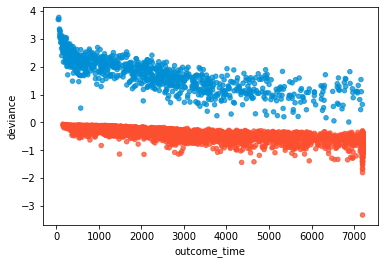

In [547]:
r = cph_m.compute_residuals(mixed_cox_df, 'deviance')
r.plot.scatter(
    x='outcome_time', y='deviance', c=np.where(r['afib'], '#008fd5', '#fc4f30'),
    alpha=0.75
)

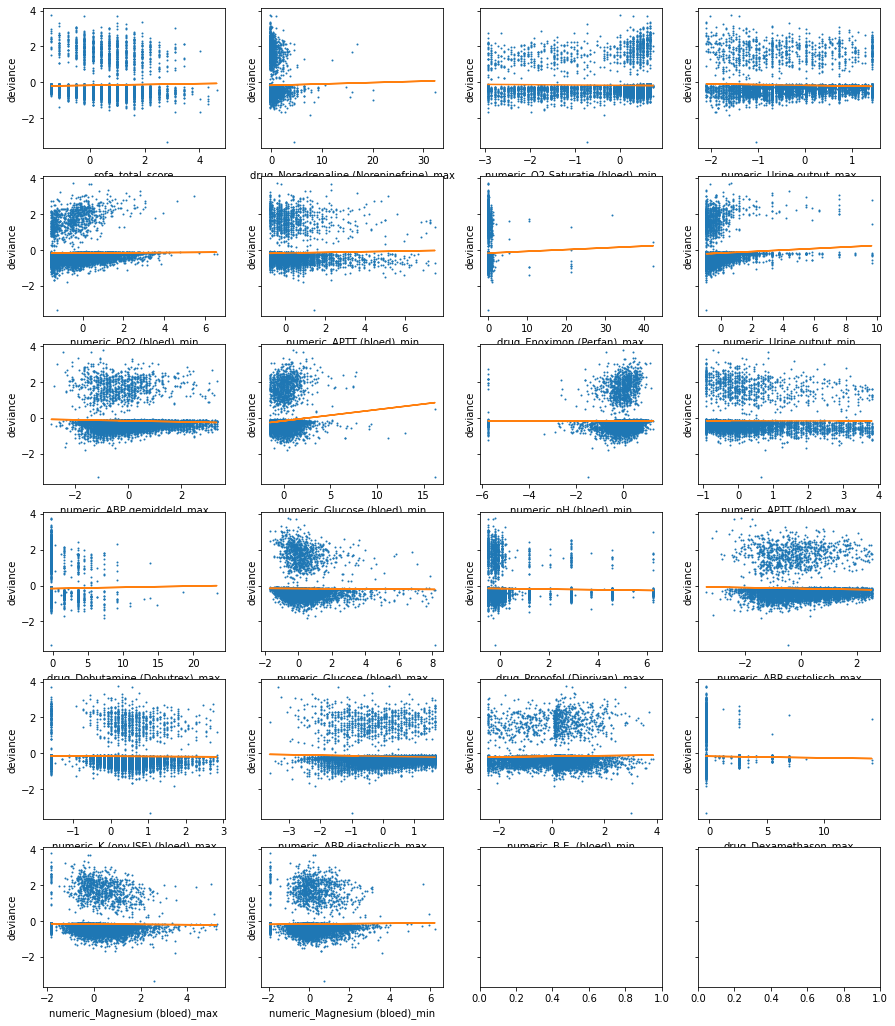

In [548]:
mixed_with_residuals = pd.merge(mixed_cox_df, r, left_index=True, right_index=True)
fig, ax = plt.subplots(figsize=(15,18), sharey=True, nrows = 6, ncols = 4)
rowcol = [(x, y) for x in range(7) for y in range(4)]
for ii in range(continuous_predictors.size):
    predictor = continuous_predictors[ii]
    ax_temp = ax[rowcol[ii]]
    ax_temp.plot(mixed_with_residuals[predictor], mixed_with_residuals['deviance'], 'o', markersize = 1)
    ax_temp.set_xlabel(predictor)
    ax_temp.set_ylabel('deviance')
    m, b = np.polyfit(mixed_with_residuals[predictor], mixed_with_residuals['deviance'], 1)
    ax_temp.plot(mixed_with_residuals[predictor], m*mixed_with_residuals[predictor] + b)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 9081 total observations, 8198 right-censored observations>
         test_name = proportional_hazard_test

---
                                             test_statistic      p  -log2(p)
agegroup_59-                           km              0.00   0.99      0.02
                                       rank            0.00   0.97      0.04
agegroup_80+                           km              1.21   0.27      1.88
                                       rank            2.24   0.13      2.89
drug_Dexamethason_max                  km              0.68   0.41      1.28
                                       rank            1.06   0.30      1.72
drug_Dobutamine (Dobutrex)_max         km              5.21   0.02      5.47
                                       rank            5.34   0.02      5.58
drug_Enoximon (Perfan)_max             km              0.02   0.88      0.19
                                       rank            0.27   0.60      0.73
drug_Noradrenaline (Norepinefrine)_max km              0.02   0.90      0.16
                                       rank            0.07   0.80      0.33
drug_Propofol (Diprivan)_max           km              0.26   0.61      0.71
                                       rank            0.14   0.70      0.51
numeric_ABP diastolisch_max            km              4.01   0.05      4.46
                                       rank            5.97   0.01      6.10
numeric_ABP gemiddeld_max              km              4.00   0.05      4.46
                                       rank            4.94   0.03      5.25
numeric_ABP systolisch_max             km              4.32   0.04      4.73
                                       rank            6.94   0.01      6.89
numeric_APTT (bloed)_max               km              1.23   0.27      1.90
                                       rank            1.57   0.21      2.25
numeric_APTT (bloed)_min               km              6.87   0.01      6.83
                                       rank           10.30 <0.005      9.56
numeric_B.E. (bloed)_min               km              4.12   0.04      4.56
                                       rank            4.95   0.03      5.26
numeric_CVD_bool                       km              2.28   0.13      2.93
                                       rank            3.85   0.05      4.33
numeric_Glucose (bloed)_max            km              6.03   0.01      6.15
                                       rank            8.42 <0.005      8.07
numeric_Glucose (bloed)_min            km             26.06 <0.005     21.52
                                       rank           35.63 <0.005     28.65
numeric_K (onv.ISE) (bloed)_max        km              2.13   0.14      2.79
                                       rank            3.00   0.08      3.59
numeric_Magnesium (bloed)_max          km              3.31   0.07      3.86
                                       rank            4.16   0.04      4.60
numeric_Magnesium (bloed)_min          km              0.26   0.61      0.71
                                       rank            0.09   0.76      0.40
numeric_O2-Saturatie (bloed)_min       km              7.60   0.01      7.42
                                       rank            8.32 <0.005      8.00
numeric_PO2 (bloed)_min                km              9.48 <0.005      8.91
                                       rank           12.68 <0.005     11.40
numeric_TroponineT (bloed)_bool        km              0.15   0.70      0.51
                                       rank            0.31   0.58      0.79
numeric_Urine output_max               km             21.35 <0.005     17.99
                                       rank           27.22 <0.005     22.39
numeric_Urine output_min               km             46.37 <0.005     36.57
                         



1. Variable 'sofa_total_score' failed the non-proportional test: p-value is 0.0117.

   Advice 1: the functional form of the variable 'sofa_total_score' might be incorrect. That is,
there may be non-linear terms missing. The proportional hazard test used is very sensitive to
incorrect functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'sofa_total_score' using pd.cut, and then specify it in
`strata=['sofa_total_score', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


2. Variable 'numeric_O2-Saturatie (bloed)_min' failed the non-proportional test: p-value is 0.0039.

   Advice 1: the functional form of the variable 'numeric_O2-Saturatie (bloed)_min' might be
incorrect. That is, there may be non-linear terms missing. The proportiona

[[<matplotlib.axes._subplots.AxesSubplot at 0x7ff9a578d310>,

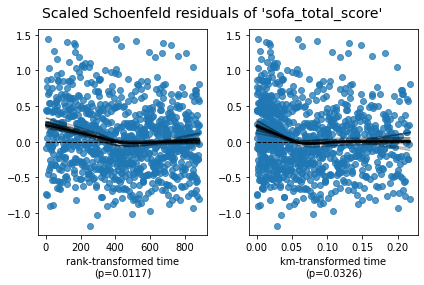

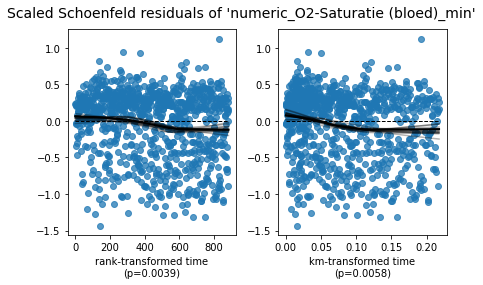

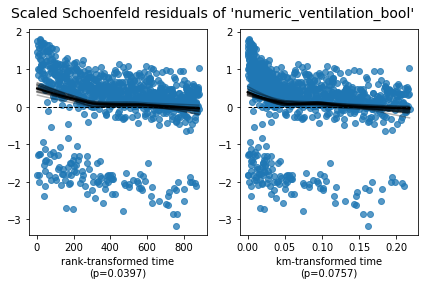

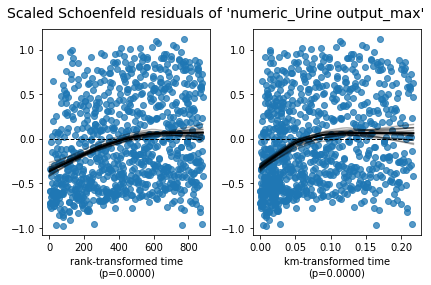

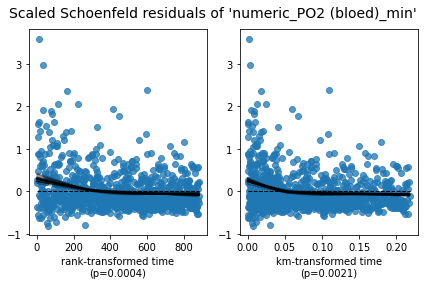

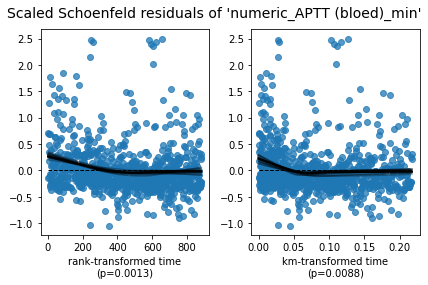

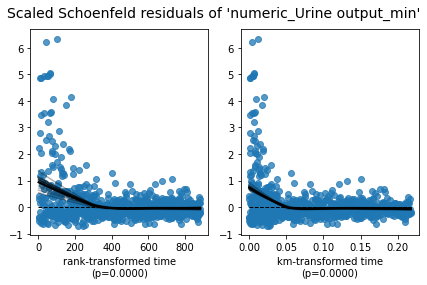

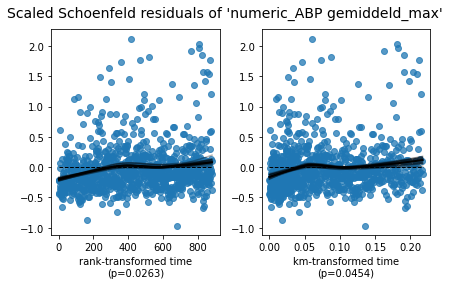

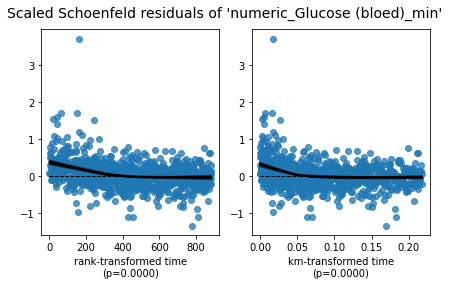

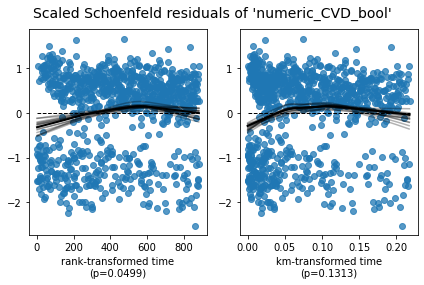

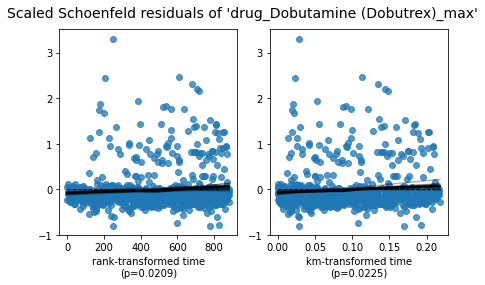

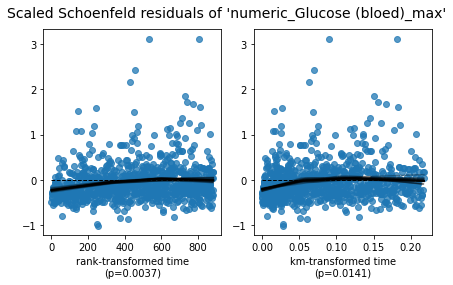

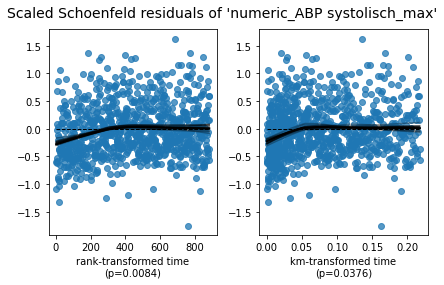

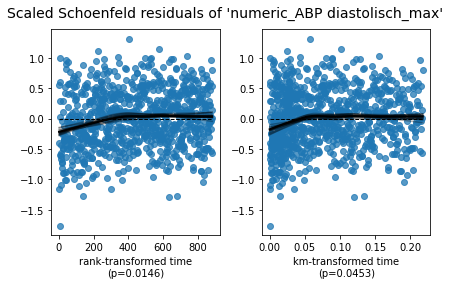

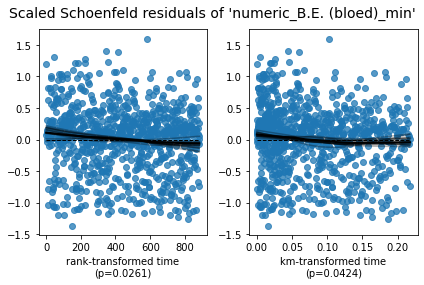

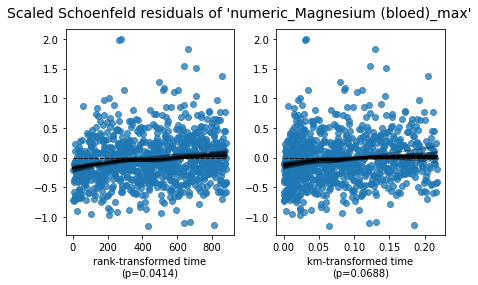

In [549]:
cph_m.check_assumptions(mixed_cox_df, p_value_threshold=0.05, show_plots=True)

**A few plots**

Text(0.5, 1.0, 'Mixed aetiology')

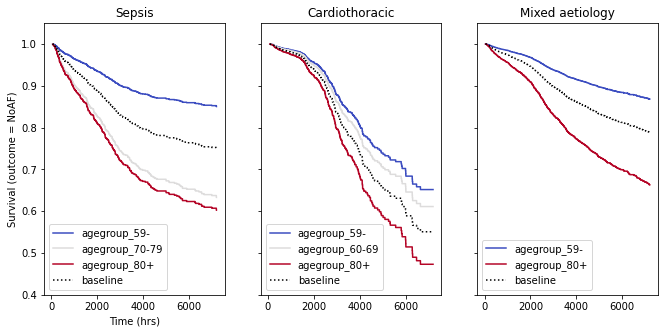

In [584]:
fig, ax = plt.subplots(ncols=3,nrows=1,figsize=[11,5], sharex = True, sharey = True)

cph_s.plot_partial_effects_on_outcome(['agegroup_80+', 'agegroup_70-79', 'agegroup_59-'], values=[
 [0, 0, 1],
 [0, 1, 0],
 [1, 0, 0]
], cmap='coolwarm', ax = ax[0])
ax[0].legend(labels = ['agegroup_59-', 'agegroup_70-79', 'agegroup_80+', 'baseline'])
ax[0].set_xlabel('Time (hrs)')
ax[0].set_ylim([0.4, 1.05])
ax[0].set_title('Sepsis')
ax[0].set_ylabel('Survival (outcome = NoAF)')

cph_c.plot_partial_effects_on_outcome(['agegroup_80+', 'agegroup_60-69', 'agegroup_59-'], values=[
 [0, 0, 1],
 [0, 1, 0],
 [1, 0, 0]
], cmap='coolwarm', ax = ax[1])
ax[1].legend(labels = ['agegroup_59-', 'agegroup_60-69', 'agegroup_80+', 'baseline'])
ax[1].set_title('Cardiothoracic')

cph_m.plot_partial_effects_on_outcome(['agegroup_80+', 'agegroup_59-'], values=[
 [0, 1],
 [1, 0]
], cmap='coolwarm', ax = ax[2])
ax[2].legend(labels = ['agegroup_59-', 'agegroup_80+', 'baseline'])
ax[2].set_title('Mixed aetiology')

In [572]:
list(set(m_reduced_variables).intersection(c_reduced_variables).intersection(s_reduced_variables))

['agegroup_80+',
 'numeric_Urine output_max',
 'numeric_Urine output_min',
 'agegroup_59-',
 'numeric_ABP diastolisch_max',
 'drug_Noradrenaline (Norepinefrine)_max',
 'numeric_Glucose (bloed)_min',
 'sofa_total_score']

In [523]:
all_predictors = list(set(m_reduced_variables).union(c_reduced_variables).union(s_reduced_variables))

importance_sum = [0] * len(all_predictors)
for ii in range(len(all_predictors)):
  predictor = all_predictors[ii]
  if np.any(predictor == s_reduced_variables):
    importance_sum[ii] += s_forest_importances[predictor]
  if np.any(predictor == c_reduced_variables):
    importance_sum[ii] += c_forest_importances[predictor]
  if np.any(predictor == m_reduced_variables):
    importance_sum[ii] += m_forest_importances[predictor]
  
all_predictors = [x for _, x in sorted(zip(importance_sum, all_predictors))]

In [524]:
# fig, ax = plt.subplots(ncols=3,nrows=2,sharey=True,figsize=[15,25])

# y = np.arange(len(all_predictors))
# ## Sepsis HR
# x = cph_s.summary['exp(coef)']
# x_min = cph_s.summary['exp(coef) lower 95%']
# x_max = cph_s.summary['exp(coef) upper 95%']
# for n in y:
#   predictor = all_predictors[n]
#   ## As the list of predictors was very slightly different
#   if np.any(predictor == s_reduced_variables):
#     m = np.where(s_reduced_variables == predictor)[0][0]
#     ax[0,0].plot([x_min[m], x_max[m]], [n, n], color='k')
#     ax[0,0].plot(x[m], n, marker='o', color='k')
# ax[0,0].plot([1, 1], [y[0], y[-1]], linestyle='--', color='k')
# ax[0,0].set_xlabel('HR')
# ax[0,0].set_title('Sepsis, hazard ratios')
# ax[0,0].set_yticks(y)
# ax[0,0].set_yticklabels(pd.Series(all_predictors).str.replace('_', ' '))

# x = s_forest_importances
# x_min = s_forest_importances - s_std
# x_max = s_forest_importances + s_std
# for n in y:
#   predictor = all_predictors[n]
#   if np.any(predictor == s_reduced_variables):
#     m = np.where(s_reduced_variables == predictor)[0][0]
#     ax[1,0].plot([x_min[m], x_max[m]], [n, n], color='b')
#     ax[1,0].plot(x[m], n, marker='o', color='b')
# ax[1,0].plot([0, 0], [y[0], y[-1]], linestyle='--', color='k')
# ax[1,0].set_xlabel('Mean decrease in impurity')
# ax[1,0].set_title('Sepsis, random forest importances')

# x = cph_c.summary['exp(coef)']
# x_min = cph_c.summary['exp(coef) lower 95%']
# x_max = cph_c.summary['exp(coef) upper 95%']
# for n in y:
#   predictor = all_predictors[n]
#   if np.any(predictor == c_reduced_variables):
#     m = np.where(c_reduced_variables == predictor)[0][0]
#     ax[0,1].plot([x_min[m], x_max[m]], [n, n], color='k')
#     ax[0,1].plot(x[m], n, marker='o', color='k')
#   m += 1
# ax[0,1].plot([1, 1], [y[0], y[-1]], linestyle='--', color='k')
# ax[0,1].set_xlabel('HR')
# ax[0,1].set_title('Cardiothoracic, hazard ratios')

# x = c_forest_importances
# x_min = c_forest_importances - c_std
# x_max = c_forest_importances + c_std
# for n in y:
#   predictor = all_predictors[n]
#   if np.any(predictor == c_reduced_variables):
#     m = np.where(c_reduced_variables == predictor)[0][0]
#     ax[1,1].plot([x_min[m], x_max[m]], [n, n], color='b')
#     ax[1,1].plot(x[m], n, marker='o', color='b')
# ax[1,1].plot([0, 0], [y[0], y[-1]], linestyle='--', color='k')
# ax[1,1].set_xlabel('Mean decrease in impurity')
# ax[1,1].set_title('Cardiothoracic, random forest importances')

# x = cph_m.summary['exp(coef)']
# x_min = cph_m.summary['exp(coef) lower 95%']
# x_max = cph_m.summary['exp(coef) upper 95%']
# for n in y:
#   predictor = all_predictors[n]
#   if np.any(predictor == m_reduced_variables):
#     m = np.where(m_reduced_variables == predictor)[0][0]
#     ax[0,2].plot([x_min[m], x_max[m]], [n, n], color='k')
#     ax[0,2].plot(x[m], n, marker='o', color='k')
# ax[0,2].plot([1, 1], [y[0], y[-1]], linestyle='--', color='k')
# ax[0,2].set_xlabel('HR')
# ax[0,2].set_title('Mixed aetiology, hazard ratios')

# x = m_forest_importances
# x_min = m_forest_importances - m_std
# x_max = m_forest_importances + m_std
# for n in y:
#   predictor = all_predictors[n]
#   if np.any(predictor == m_reduced_variables):
#     m = np.where(m_reduced_variables == predictor)[0][0]
#     ax[1,2].plot([x_min[m], x_max[m]], [n, n], color='b')
#     ax[1,2].plot(x[m], n, marker='o', color='b')
# ax[1,2].plot([0, 0], [y[0], y[-1]], linestyle='--', color='k')
# ax[1,2].set_xlabel('Mean decrease in impurity')
# ax[1,2].set_title('Mixed aetiology, random forest importances')

[]

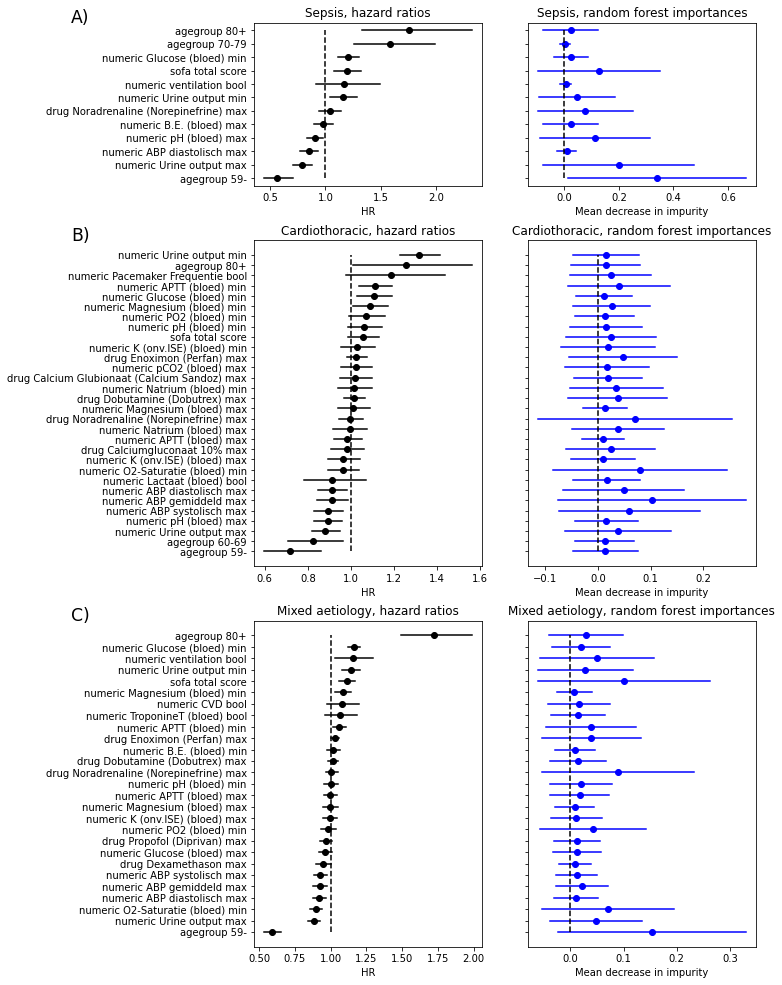

In [571]:
fig, ax = plt.subplots(ncols=2,nrows=3,figsize=[9,17], gridspec_kw={'height_ratios':[5,10,10]})

left, width = -0.8, 1.8
bottom, height = 0, 1
right = left + width
top = bottom + height

# # axes coordinates: (0, 0) is bottom left and (1, 1) is upper right
# p = patches.Rectangle(
#     (left, bottom), width, height,
#     fill=False, transform=ax.transAxes, clip_on=False
#     )

y = np.arange(s_reduced_variables.size)
## Sepsis HR
x = cph_s.summary['exp(coef)']
sort = [x for _, x in sorted(zip(x, s_reduced_variables))]
yticklabels = pd.Series(sort).str.replace('_', ' ')
x = x[sort]
x_min = cph_s.summary['exp(coef) lower 95%'][sort]
x_max = cph_s.summary['exp(coef) upper 95%'][sort]
for n in y:
  ## As the list of predictors was very slightly different
  ax[0,0].plot([x_min[n], x_max[n]], [n, n], color='k')
  ax[0,0].plot(x[n], n, marker='o', color='k')
ax[0,0].plot([1, 1], [y[0], y[-1]], linestyle='--', color='k')
ax[0,0].set_xlabel('HR')
ax[0,0].set_title('Sepsis, hazard ratios')
ax[0,0].set_yticks(y)
ax[0,0].set_yticklabels(yticklabels)
# ax[0,0].add_patch(p)
ax[0,0].text(left, top, 'A)', transform=ax[0,0].transAxes, fontsize='xx-large')

x = s_forest_importances[sort]
x_min = s_forest_importances - s_std
x_min = x_min[sort]
x_max = s_forest_importances + s_std
x_max = x_max[sort]
for n in y:
  ax[0,1].plot([x_min[n], x_max[n]], [n, n], color='b')
  ax[0,1].plot(x[n], n, marker='o', color='b')
ax[0,1].plot([0, 0], [y[0], y[-1]], linestyle='--', color='k')
ax[0,1].set_xlabel('Mean decrease in impurity')
ax[0,1].set_title('Sepsis, random forest importances')
ax[0,1].set_yticks(y)
ax[0,1].set_yticklabels([])

y = np.arange(c_reduced_variables.size)
## Sepsis HR
x = cph_c.summary['exp(coef)']
sort = [x for _, x in sorted(zip(x, c_reduced_variables))]
yticklabels = pd.Series(sort).str.replace('_', ' ')
x = x[sort]
x_min = cph_c.summary['exp(coef) lower 95%'][sort]
x_max = cph_c.summary['exp(coef) upper 95%'][sort]
for n in y:
  ## As the list of predictors was very slightly different
  ax[1,0].plot([x_min[n], x_max[n]], [n, n], color='k')
  ax[1,0].plot(x[n], n, marker='o', color='k')
ax[1,0].plot([1, 1], [y[0], y[-1]], linestyle='--', color='k')
ax[1,0].set_xlabel('HR')
ax[1,0].set_title('Cardiothoracic, hazard ratios')
ax[1,0].set_yticks(y)
ax[1,0].set_yticklabels(yticklabels)
ax[1,0].text(left, top, 'B)', transform=ax[1,0].transAxes, fontsize='xx-large')

x = c_forest_importances[sort]
x_min = c_forest_importances - c_std
x_min = x_min[sort]
x_max = c_forest_importances + c_std
x_max = x_max[sort]
for n in y:
  ax[1,1].plot([x_min[n], x_max[n]], [n, n], color='b')
  ax[1,1].plot(x[n], n, marker='o', color='b')
ax[1,1].plot([0, 0], [y[0], y[-1]], linestyle='--', color='k')
ax[1,1].set_xlabel('Mean decrease in impurity')
ax[1,1].set_title('Cardiothoracic, random forest importances')
ax[1,1].set_yticks(y)
ax[1,1].set_yticklabels([])

y = np.arange(m_reduced_variables.size)
## Sepsis HR
x = cph_m.summary['exp(coef)']
sort = [x for _, x in sorted(zip(x, m_reduced_variables))]
yticklabels = pd.Series(sort).str.replace('_', ' ')
x = x[sort]
x_min = cph_m.summary['exp(coef) lower 95%'][sort]
x_max = cph_m.summary['exp(coef) upper 95%'][sort]
for n in y:
  ## As the list of predictors was very slightly different
  ax[2,0].plot([x_min[n], x_max[n]], [n, n], color='k')
  ax[2,0].plot(x[n], n, marker='o', color='k')
ax[2,0].plot([1, 1], [y[0], y[-1]], linestyle='--', color='k')
ax[2,0].set_xlabel('HR')
ax[2,0].set_title('Mixed aetiology, hazard ratios')
ax[2,0].set_yticks(y)
ax[2,0].set_yticklabels(yticklabels)
ax[2,0].text(left, top, 'C)', transform=ax[2,0].transAxes, fontsize='xx-large')

x = m_forest_importances[sort]
x_min = m_forest_importances - m_std
x_min = x_min[sort]
x_max = m_forest_importances + m_std
x_max = x_max[sort]
for n in y:
  ax[2,1].plot([x_min[n], x_max[n]], [n, n], color='b')
  ax[2,1].plot(x[n], n, marker='o', color='b')
ax[2,1].plot([0, 0], [y[0], y[-1]], linestyle='--', color='k')
ax[2,1].set_xlabel('Mean decrease in impurity')
ax[2,1].set_title('Mixed aetiology, random forest importances')
ax[2,1].set_yticks(y)
ax[2,1].set_yticklabels([])

Text(0.5, 1.0, 'Sepsis, random forest importances')

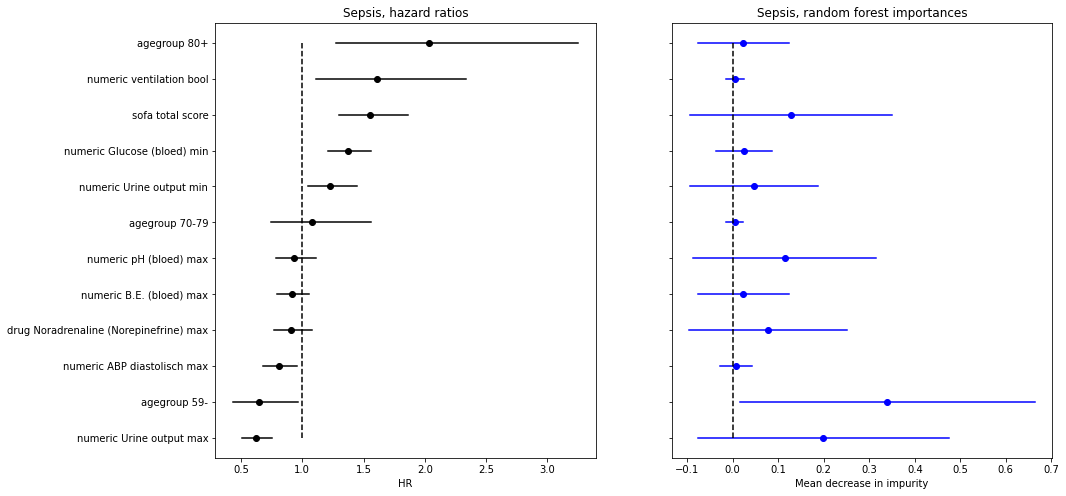

In [525]:
fig, ax = plt.subplots(ncols=2,nrows=1,sharey=True,figsize=[15,8])

y = np.arange(s_reduced_variables.size)
## Sepsis HR
x = cph_s.summary['exp(coef)']
sort = [x for _, x in sorted(zip(x, s_reduced_variables))]
yticklabels = pd.Series(sort).str.replace('_', ' ')
x = x[sort]
x_min = cph_s.summary['exp(coef) lower 95%'][sort]
x_max = cph_s.summary['exp(coef) upper 95%'][sort]
for n in y:
  ## As the list of predictors was very slightly different
  ax[0].plot([x_min[n], x_max[n]], [n, n], color='k')
  ax[0].plot(x[n], n, marker='o', color='k')
ax[0].plot([1, 1], [y[0], y[-1]], linestyle='--', color='k')
ax[0].set_xlabel('HR')
ax[0].set_title('Sepsis, hazard ratios')
ax[0].set_yticks(y)
ax[0].set_yticklabels(yticklabels)

x = s_forest_importances[sort]
x_min = s_forest_importances - s_std
x_min = x_min[sort]
x_max = s_forest_importances + s_std
x_max = x_max[sort]
for n in y:
  ax[1].plot([x_min[n], x_max[n]], [n, n], color='b')
  ax[1].plot(x[n], n, marker='o', color='b')
ax[1].plot([0, 0], [y[0], y[-1]], linestyle='--', color='k')
ax[1].set_xlabel('Mean decrease in impurity')
ax[1].set_title('Sepsis, random forest importances')

Text(0.5, 1.0, 'Cardiothoracic, random forest importances')

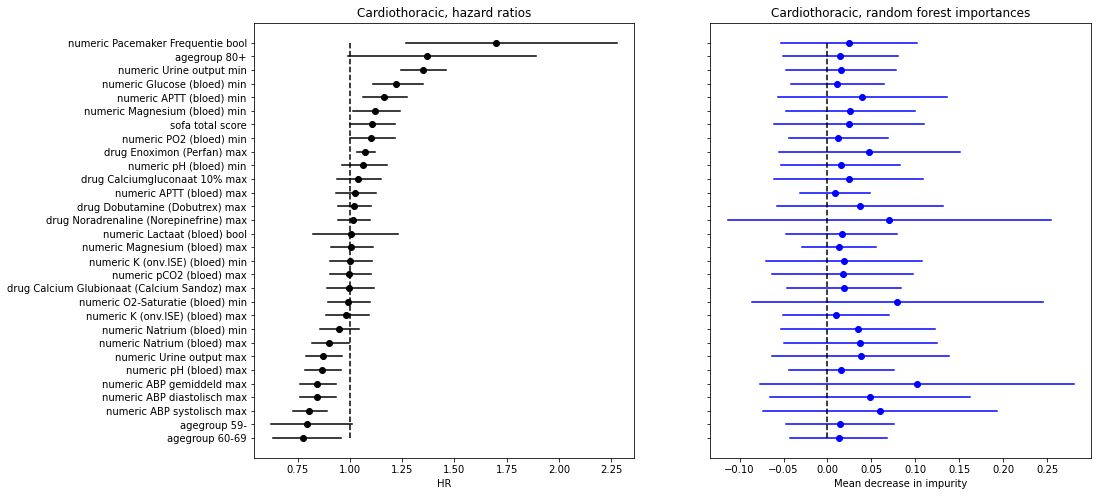

In [526]:
fig, ax = plt.subplots(ncols=2,nrows=1,sharey=True,figsize=[15,8])

y = np.arange(c_reduced_variables.size)
## Sepsis HR
x = cph_c.summary['exp(coef)']
sort = [x for _, x in sorted(zip(x, c_reduced_variables))]
yticklabels = pd.Series(sort).str.replace('_', ' ')
x = x[sort]
x_min = cph_c.summary['exp(coef) lower 95%'][sort]
x_max = cph_c.summary['exp(coef) upper 95%'][sort]
for n in y:
  ## As the list of predictors was very slightly different
  ax[0].plot([x_min[n], x_max[n]], [n, n], color='k')
  ax[0].plot(x[n], n, marker='o', color='k')
ax[0].plot([1, 1], [y[0], y[-1]], linestyle='--', color='k')
ax[0].set_xlabel('HR')
ax[0].set_title('Cardiothoracic, hazard ratios')
ax[0].set_yticks(y)
ax[0].set_yticklabels(yticklabels)

x = c_forest_importances[sort]
x_min = c_forest_importances - c_std
x_min = x_min[sort]
x_max = c_forest_importances + c_std
x_max = x_max[sort]
for n in y:
  ax[1].plot([x_min[n], x_max[n]], [n, n], color='b')
  ax[1].plot(x[n], n, marker='o', color='b')
ax[1].plot([0, 0], [y[0], y[-1]], linestyle='--', color='k')
ax[1].set_xlabel('Mean decrease in impurity')
ax[1].set_title('Cardiothoracic, random forest importances')

Text(0.5, 1.0, 'Mixed aetiology, random forest importances')

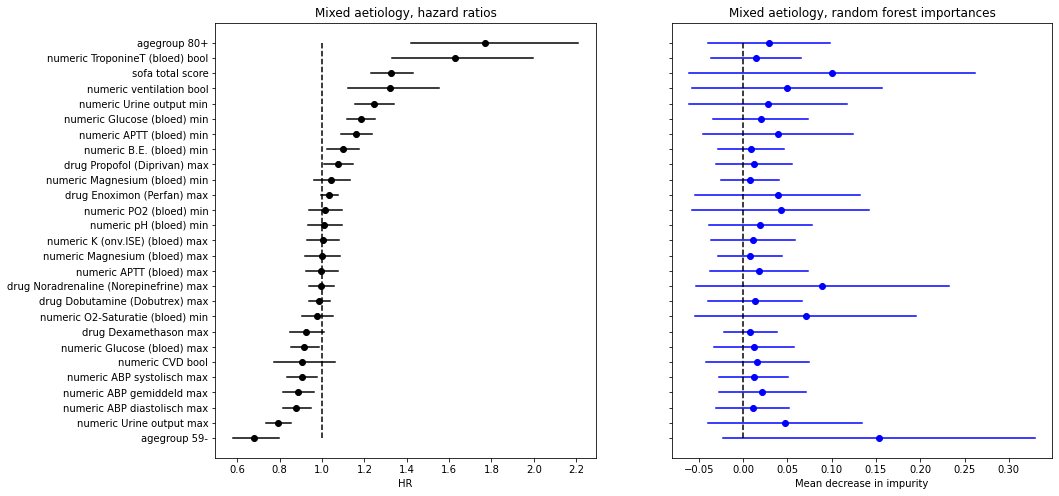

In [527]:
fig, ax = plt.subplots(ncols=2,nrows=1,sharey=True,figsize=[15,8])

y = np.arange(m_reduced_variables.size)
## Sepsis HR
x = cph_m.summary['exp(coef)']
sort = [x for _, x in sorted(zip(x, m_reduced_variables))]
yticklabels = pd.Series(sort).str.replace('_', ' ')
x = x[sort]
x_min = cph_m.summary['exp(coef) lower 95%'][sort]
x_max = cph_m.summary['exp(coef) upper 95%'][sort]
for n in y:
  ## As the list of predictors was very slightly different
  ax[0].plot([x_min[n], x_max[n]], [n, n], color='k')
  ax[0].plot(x[n], n, marker='o', color='k')
ax[0].plot([1, 1], [y[0], y[-1]], linestyle='--', color='k')
ax[0].set_xlabel('HR')
ax[0].set_title('Mixed aetiology, hazard ratios')
ax[0].set_yticks(y)
ax[0].set_yticklabels(yticklabels)

x = m_forest_importances[sort]
x_min = m_forest_importances - m_std
x_min = x_min[sort]
x_max = m_forest_importances + m_std
x_max = x_max[sort]
for n in y:
  ax[1].plot([x_min[n], x_max[n]], [n, n], color='b')
  ax[1].plot(x[n], n, marker='o', color='b')
ax[1].plot([0, 0], [y[0], y[-1]], linestyle='--', color='k')
ax[1].set_xlabel('Mean decrease in impurity')
ax[1].set_title('Mixed aetiology, random forest importances')

#Descriptive stats

In [125]:
ds_rows = ['No. patients']
ds_rows += ['Age: ' + agegroup + ' %' for agegroup in admissions_df['agegroup'].unique()]
ds_rows += ['Female %', 'Largest case BMI (mean)']
ds_rows += ['Admission SOFA (mean)', 'Admission SOFA cardiovascular (mean)']
ds_rows += ['Erythromycin in <24hr/AF: n', 'Antiarrythmics in <24hr/AF: n']
ds_rows += ['Magnesium in <24hr/AF: n']
# ds_rows += ['Lowest MABP in <24hr/AF (mean)']
# ds_rows += ['Highest MABP in <24hr/AF (mean)', 'Lowest HR in <24hr/AF (mean)']
# ds_rows += ['Highest HR in <24hr/AF (mean)', 'Lowest PH in <24hr/AF (mean)']
# ds_rows += ['Highest PH in <24hr/AF (mean)', 'Lowest O2-sat in <24hr/AF (mean)']
# ds_rows += ['Highest O2-sat in <24hr/AF (mean)', 'Lowest NA in <24hr/AF (mean)']
# ds_rows += ['Highest NA in <24hr/AF (mean)', 'Lowest K in <24hr/AF (mean)']
# ds_rows += ['Highest K in <24hr/AF (mean)']
ds_rows += ['Urgency %', 'From surgery %', 'ICU length of stay (days)']
ds_rows += ['Mortality %']

ds_columns = ['All', 'Sepsis subset', 'CABG/valve surgery subset']
ds_columns += ['AF subset', 'AF+Sepsis', 'AF+CABG/valve surgery']

table = pd.DataFrame(None, columns = ds_columns, index = ds_rows)


In [126]:
all_ind = main_df['admissionid'].isin(main_df['admissionid'])
conditions = [all_ind, main_df['is_sepsis'], main_df['is_cardiosurg'], \
              main_df['afib'], main_df['is_sepsis'] & main_df['afib'], \
              main_df['is_cardiosurg'] & main_df['afib']]
for ii in range(6):
  col = ds_columns[ii]
  subset = main_df.loc[conditions[ii], :]
  table.loc['No. patients', col] = subset['patientid'].nunique()
  for agegroup in main_df['agegroup'].unique():
    table.loc['Age: ' + agegroup + ' %', col] = (subset['agegroup'] == agegroup).mean() * 100
  table.loc['Female %', col] = (subset['gender'] == 'Vrouw').mean() * 100
  table.loc['Urgency %', col] = (subset['urgency'] == 1).mean() * 100
  table.loc['Largest case BMI (mean)', col] = (subset['bmi_max']).mean()
  table.loc['From surgery %', col] = (subset['surgical'] == 1).mean()
  table.loc['ICU length of stay (days)', col] = subset['lengthofstay'].mean() / 24
  table.loc['Mortality %', col] = (~subset['dateofdeath'].isna()).mean() * 100
  table.loc['Admission SOFA (mean)', col] = subset['sofa_total_score'].mean()
  table.loc['Admission SOFA cardiovascular (mean)', col] = subset['sofa_cardiovascular_score'].mean()
  table.loc['Erythromycin in <24hr/AF: n', col] = subset['erythromycin'].sum()
  table.loc['Antiarrythmics in <24hr/AF: n', col] = subset['antiarrythmics'].sum()
  table.loc['Magnesium in <24hr/AF: n', col] = subset['magnesium'].sum()
table

All  ... AF+CABG/valve surgery
No. patients                             19495  ...                   429
Age: 70-79 %                           25.9708  ...               50.5828
Age: 60-69 %                           26.4016  ...                 23.31
Age: 50-59 %                           17.2762  ...               6.06061
Age: 18-39 %                           11.2388  ...                0.4662
Age: 80+ %                             9.40241  ...               18.8811
Age: 40-49 %                           9.71018  ...              0.699301
Female %                               34.0344  ...                34.965
Largest case BMI (mean)                28.8539  ...                30.034
Admission SOFA (mean)                  4.65848  ...               5.10256
Admission SOFA cardiovascular (mean)   1.93578  ...               2.55944
Erythromycin in <24hr/AF: n                324  ...                     2
Antiarrythmics in <24hr/AF: n              619  ...                    25
Magnesium in <24hr/AF: n                 12797  ...                   374
Urgency %                              28.0072  ...               5.82751
From surgery %                        0.509156  ...                     1
ICU length of stay (days)              4.13345  ...               4.96698
Mortality %                            30.3052  ...               19.5804

[18 rows x 6 columns]

#Dictionary and miscellaneous

In [127]:
#get the amsterdamumcdb package from PiPy repository for use in Colab
!pip install amsterdamumcdb
import amsterdamumcdb as adb
dictionary = adb.get_dictionary()

In [128]:
dictionary[dictionary['item'].str.contains('magn', na=False, flags=re.IGNORECASE)]

itemid                        item  ...   count count_validated
2802    6839                   Magnesium  ...    4633          4633.0
2917    9952           Magnesium (bloed)  ...  127345        127345.0
3029    9953          Magnesium (overig)  ...      24            24.0
3085   18862       Magnesium (dialysaat)  ...      10            10.0
3122   10294           Magnesium (urine)  ...      62            62.0
3152   10295    Magnesium  (verz. urine)  ...       7             7.0
3172   12232     Magnesium (verz. urine)  ...       7             7.0
4785    7148    Magnesiumsulfaat (MgSO4)  ...    8866             NaN
4786    7148    Magnesiumsulfaat (MgSO4)  ...   32602             NaN
4965    9002            Magnesiumsulfaat  ...     497             NaN
5115    9543              Magnesiumoxide  ...   14429             NaN
5292   14775  Research Magnesium/Placebo  ...      81             NaN

[12 rows x 19 columns]

In [129]:
dictionary[dictionary['item'].str.contains('eryt', na=False, flags=re.IGNORECASE)]

itemid                          item  ...  count count_validated
2823    6774                  Erythrocyten  ...    251           251.0
3470   11490            ERYTHROBL. (bloed)  ...   2719          2719.0
3472   11539        Erythroblasten (bloed)  ...   2028          2028.0
3650   17286  Erytrocyten cilinder (urine)  ...     10            10.0
4827    7208   Erythromycine (Erythrocine)  ...    589             NaN
4828    7208   Erythromycine (Erythrocine)  ...  22577             NaN

[6 rows x 19 columns]

In [130]:
dictionary[dictionary['item'].str.contains('atenolol|digoxin|sotalol|amiodaron', na=False, flags=re.IGNORECASE)]

itemid  ... count_validated
2862    7205  ...             5.0
3835    9696  ...            26.0
3836    9697  ...            26.0
3851    9721  ...           165.0
3930   18323  ...            78.0
3941   18558  ...            10.0
4663    6844  ...             NaN
4667    6862  ...             NaN
4668    6862  ...             NaN
4748    7006  ...             NaN
4749    7006  ...             NaN
4803    7173  ...             NaN
4804    7173  ...             NaN
4805    7173  ...             NaN
4980    9015  ...             NaN
4981    9015  ...             NaN
4982    9015  ...             NaN
5048    9087  ...             NaN
5305   16113  ...             NaN
5306   16113  ...             NaN
6905    8101  ...             NaN

[21 rows x 19 columns]

In [131]:
ds_rows = ['No. patients']
for item in drugs_all_meds['item'].unique():
  ds_rows += [item]

ds_columns = ['All', 'Sepsis subset', 'CABG/valve surgery subset']
ds_columns += ['AF subset', 'AF+Sepsis', 'AF+CABG/valve surgery']

table = pd.DataFrame(None, columns = ds_columns, index = ds_rows)
table.shape

(79, 6)

In [132]:
# all_ind = drugs_df['admissionid'].isin(drugs_df['admissionid'])
ind_all = (admissions_df['admissioncount'] == 1) & (admissions_df['previous_afib'] == 0)
conditions = [ind_all, ind_all & drugs_df['is_sepsis'], ind_all & drugs_df['is_cardiosurg'], \
              ind_all & drugs_df['afib'], ind_all & drugs_df['is_sepsis'] & drugs_df['afib'], \
              ind_all & drugs_df['is_cardiosurg'] & drugs_df['afib']]
for ii in range(6):
  col = ds_columns[ii]
  subset = drugs_df.loc[conditions[ii], :]
  table.loc['No. patients', col] = subset['patientid'].nunique()
  for item in drugs_all_meds['item'].unique():
    table.loc[item, col] = (subset[item] == 1).sum()
table

All  ... AF+CABG/valve surgery
No. patients                             19495  ...                   429
Magnesiumsulfaat (MgSO4)                 12757  ...                   374
Losartan (Cozaar)                           89  ...                     1
Gelofusine                                8319  ...                   134
NaCl 0,45%/Glucose 2,5%                  15140  ...                   379
NaCl 0,9 %                                9573  ...                   105
Calcium Glubionaat (Calcium Sandoz)       6484  ...                   191
Nitroglycerine (Nitro-pohl)               3840  ...                    85
Propofol (Diprivan)                      12818  ...                   376
Kaliumchloride (KCL)                      5201  ...                    58
NaCL 0,9% spuit                          13563  ...                   368
Dopamine (Inotropin)                      6283  ...                   307
Nicardipine (Cardene)                     1480  ...                    38
Noradrenaline (Norepinefrine)             5946  ...                   135
Fresh Frozen Plasma                       1824  ...                    69
Amlodipine (Norvasc)                       764  ...                     9
Nitroprusside (Nipride)                    288  ...                     5
Metoprolol (Selokeen )                    1724  ...                    26
Captopril (Capoten)                        993  ...                    37
Sotalol (Sotacor)                          310  ...                    24
Enoximon (Perfan)                         1508  ...                   104
Ri-Lac (Ringers lactaat)                  4469  ...                   195
Carbasalaatcalcium (Ascal)                2052  ...                    71
Calciumgluconaat 10%                      1719  ...                   182
Prednisolon (Prednison)                    709  ...                     5
(V/A)Ventolin:Atrovent 1:1                1255  ...                    24
Digoxine (Lanoxin)                          44  ...                     0
Kaliumchloride drank                       730  ...                     4
(V/A/M)Ventolin:Atrovent:Mucomyst 1:1:1    708  ...                    11
Osmolite HP 1.0                            115  ...                     0
Esomeprazol (Nexium)                       815  ...                    15
Furosemide (Lasix)                        1729  ...                    34
Hydrocortison (Solu Cortef)               1864  ...                    39
Fytomenadion (Konakion/Vit. K)             830  ...                    15
Glucose 5 %                                755  ...                     2
Natrium bicarbonaat 8,4 %                  577  ...                     2
Natrium-kalium-fosfaat                    2488  ...                    19
NaCl 0,9% injecties                         95  ...                     0
Ondansetron (Zofran)                      1461  ...                    18
Xylometazoline (Otrivin) neusspray         519  ...                     2
Dexamethason                              1075  ...                     2
Clopidogrel (Plavix)                       544  ...                    10
Erythromycine (Erythrocine)                324  ...                     2
Clonidine (Catapresan)                     296  ...                     9
Haloperidol (Haldol)                       653  ...                    16
Amiodaron Onderhoudsdosis                  308  ...                    12
Water 150ml                               3384  ...                    52
Labetalol (Trandate)                       355  ...                     0
Metronidazol (Flagyl)                     1173  ...                     0
Metoprolol (ZOC Selokeen)                  209  ...                     1
Metoclopram (Primperan)                    823  ...                     4
Amiodaron Oplaaddosis                      186  ...                    10
Natrium bicarbonaat 1.4%                   114  ...                     1
Voriconazol(VFEND)                         113 

In [147]:
ds_rows = []
for item in drugs_all_meds['item'].unique():
  ds_rows += [item]

ds_quantiles = [0, 0.1, 0.5, 0.9, 1]
ds_columns = ['Max dose, percentile ' + str(int(x * 100)) for x in ds_quantiles] 

table = pd.DataFrame(None, columns = ds_columns, index = ds_rows)
table.shape

(78, 5)

In [152]:
# all_ind = drugs_df['admissionid'].isin(drugs_df['admissionid'])
subset = drugs_df.loc[ind_all, :]
for item in drugs_all_meds['item'].unique():
    table.loc[item, :] = subset[item + ': max_dose'].quantile(ds_quantiles).values
table

Max dose, percentile 0  ... Max dose, percentile 100
Magnesiumsulfaat (MgSO4)                                  0.05  ...                     2000
Losartan (Cozaar)                                           25  ...                      100
Gelofusine                                                   1  ...                    30000
NaCl 0,45%/Glucose 2,5%                                      2  ...                    15000
NaCl 0,9 %                                                   3  ...                    30000
Calcium Glubionaat (Calcium Sandoz)                       0.07  ...                  82500.2
Nitroglycerine (Nitro-pohl)                               0.01  ...                     1500
Propofol (Diprivan)                                        0.2  ...                    59800
Kaliumchloride (KCL)                                      0.13  ...                      600
NaCL 0,9% spuit                                           0.18  ...                  3191.49
Dopamine (Inotropin)                                       0.4  ...                    12000
Nicardipine (Cardene)                                     0.25  ...                    93.75
Noradrenaline (Norepinefrine)                                0  ...                       84
Fresh Frozen Plasma                                       9.89  ...                    15000
Amlodipine (Norvasc)                                       2.5  ...                       20
Nitroprusside (Nipride)                                   0.03  ...                     4000
Metoprolol (Selokeen )                                       1  ...                      200
Captopril (Capoten)                                          3  ...                      625
Sotalol (Sotacor)                                            5  ...                      160
Enoximon (Perfan)                                            0  ...                     6000
Ri-Lac (Ringers lactaat)                                     3  ...                    15000
Carbasalaatcalcium (Ascal)                                  30  ...                      500
Calciumgluconaat 10%                                      0.04  ...                    60000
Prednisolon (Prednison)                                    2.5  ...                      120
(V/A)Ventolin:Atrovent 1:1                                   1  ...                        8
Digoxine (Lanoxin)                                        0.06  ...                      125
Kaliumchloride drank                                        10  ...                       60
(V/A/M)Ventolin:Atrovent:Mucomyst 1:1:1                      1  ...                        6
Osmolite HP 1.0                                             10  ...                       85
Esomeprazol (Nexium)                                        10  ...                       80
Furosemide (Lasix)                                           1  ...                    15000
Hydrocortison (Solu Cortef)                                  8  ...                      500
Fytomenadion (Konakion/Vit. K)                               1  ...                       20
Glucose 5 %                                               0.85  ...                     2000
Natrium bicarbonaat 8,4 %                                  8.8  ...                     2000
Natrium-kalium-fosfaat                                    0.06  ...                     1200
NaCl 0,9% injecties                                          3  ...                      500
Ondansetron (Zofran)                                         2  ...                       10
Xylometazoline (Otrivin) neusspray                           1  ...                        2
Dexamethason                                               0.5  ...                      100
Clopidogrel (Plavix)                                        60  ...                      600
Erythromycine (Erythrocine)                                0.5  ...                     2500
Clonidine (Catapresan)                   

In [135]:
# admissions_df.loc[(admissions_df['dischargedat'] > admissions_df['dateofdeath']), :].head()
# np.argmax(admissions_df.loc[admissions_df['dateofdeath'] > 0, 'dischargedat'] - admissions_df.loc[admissions_df['dateofdeath'] > 0, 'dateofdeath'])
# admissions_df.loc[admissions_df['dateofdeath'] > 0, :].iloc[7057]
# admissions_df.loc[admissions_df['dateofdeath'] > 0, 'dischargedat'].iloc[7057] -\
#   admissions_df.loc[admissions_df['dateofdeath'] > 0, 'dateofdeath'].iloc[7057]

In [136]:
# admissions_df['dateofdeath'].iloc[1] / (1000*60*60)

In [138]:
dictionary.loc[dictionary['item'].str.contains('Koffie', flags=re.IGNORECASE), 'itemid']

8697     8962
8708    15024
8709    15025
8710    15026
8711    15027
8712    15028
Name: itemid, dtype: int64

In [139]:
# sql_coffee = """
# WITH dosing AS (
#     SELECT  
#         drugitems.admissionid, 
#         itemid,
#         item,
#         (start - admissions.admittedat)/(1000*60) AS start_time, 
#         (stop - admissions.admittedat)/(1000*60) AS stop_time, 
#         duration,
#         rate,
#         rateunit,
#         dose,
#         doseunit,
#         doseunitid,
#         doserateperkg,
#         doserateunitid,
#         doserateunit,
#         CASE
#             WHEN weightgroup LIKE '59' THEN 55
#             WHEN weightgroup LIKE '60' THEN 65
#             WHEN weightgroup LIKE '70' THEN 75
#             WHEN weightgroup LIKE '80' THEN 85
#             WHEN weightgroup LIKE '90' THEN 95
#             WHEN weightgroup LIKE '100' THEN 105
#             WHEN weightgroup LIKE '110' THEN 115
#             ELSE 80 --mean weight for all years
#         END as patientweight
#     FROM drugitems 
#     LEFT JOIN admissions 
#     ON drugitems.admissionid = admissions.admissionid
#     WHERE itemid IN (
#           8962,
#           15024,
#           15025,
#           15026,
#           15027,
#           15028
#         )
# )
# SELECT 
#     admissionid,
#     itemid,
#     item,
#     duration,
#     rate,
#     rateunit,
#     start_time,
#     stop_time,
#     patientweight,
#     dose,
#     doserateperkg,
#     doseunitid,
#     doserateunitid
#     # CASE 
#     # --recalculate the dose to µg/kg/min ('gamma')
#     # WHEN doserateperkg = B'0' AND doseunitid = 11 AND doserateunitid = 4 --unit: µg/min -> µg/kg/min
#     #     THEN CASE 
#     #         WHEN patientweight > 0
#     #         THEN dose/patientweight
#     #         ELSE dose/80 --mean weight
#     #     END
#     # WHEN doserateperkg = B'0' AND doseunitid = 10 AND
#     # doserateunitid = 4 --unit: mg/min  -> µg/kg/min
#     #     THEN CASE 
#     #         WHEN patientweight > 0
#     #         THEN dose*1000/patientweight
#     #         ELSE dose*1000/80 --mean weight
#     #     END
#     # WHEN doserateperkg = B'0' AND doseunitid = 10 AND doserateunitid = 5 --unit: mg/uur  -> µg/kg/min
#     #     THEN CASE
#     #         WHEN patientweight > 0
#     #         THEN dose*1000/patientweight/60
#     #         ELSE dose*1000/80/60 --mean weight
#     #     END
#     # WHEN doserateperkg = B'1' AND doseunitid = 11 AND doserateunitid = 4 --unit: µg/kg/min (no conversion needed)
#     #     THEN dose
#     # WHEN doserateperkg = B'1' AND doseunitid = 11 AND doserateunitid = 5 --unit: µg/kg/uur -> µg/kg/min
#     #     THEN dose/60 
#     # END AS gamma
#     FROM dosing
#     WHERE
#     -- medication given within 24 hours of ICU stay:
#     start_time <= 24*60 AND stop_time >= 0
#     ORDER BY admissionid, start_time
# """
# coffee = pd.read_gbq(sql_coffee, configuration = config_gbq)
# coffee.head()

In [140]:
# coffee['gamma'] = coffee['dose'] / 80
# coffee.loc[coffee['patientweight'] > 0, 'gamma'] = \
#   coffee['dose'] / coffee.loc[coffee['patientweight'] > 0, 'patientweight']
# coffee.loc[coffee['doserateperkg'] == 1, 'gamma'] = \
#   coffee.loc[coffee['doserateperkg'] == 1, 'dose']
# coffee.loc[coffee['doseunitid'] == 10, 'gamma'] *= 1000
# coffee.loc[coffee['doserateunitid'] == 5, 'gamma'] /= 60

# coffee_meds = coffee.groupby(['admissionid','itemid', 'item']).agg(
#         total_duration=pd.NamedAgg(column='duration', aggfunc='sum'), 
#         max_gamma=pd.NamedAgg(column='gamma', aggfunc='max'),
#         first_start_time=pd.NamedAgg(column='start_time', aggfunc='min'),
#         last_stop_time=pd.NamedAgg(column='stop_time', aggfunc='max')
#     ).reset_index()
    
# coffee_meds.head()

In [141]:
# ## Drugs dataframe

# coffee = admissions_df[['patientid', 'admissionid', 'is_sepsis', 'is_cardiosurg', 'afib', 'afib_time']]

# # We want to a binary variable that indicates whether a patient received the drugs in the first 24hr or before AF
# for itemid in coffee_meds['itemid'].unique():
#   item = coffee_meds.loc[coffee_meds['itemid'] == itemid, 'item'].iloc[0]
#   temp_df = coffee_meds.loc[coffee_meds['itemid'] == itemid, ['admissionid', 'first_start_time', 'max_gamma']]
#   temp_df.rename(columns = {'first_start_time': item + ': start_time'}, inplace = True)
#   temp_df.rename(columns = {'max_gamma': item + ': max_gamma'}, inplace = True)
#   temp_df[item] = 1
#   #
#   coffee = pd.merge(coffee, temp_df, on='admissionid', how='left')
#   # The second part of this (after the '&') returns true if the start time is before the AF time (same thing below)
#   coffee[item] = (coffee[item] == 1) & ((coffee[item + ': start_time'] < coffee['afib_time']) | (coffee['afib'] == 0))

In [142]:
# ds_rows = ['No. patients']
# for item in coffee_meds['item'].unique():
#   ds_rows += [item]

# ds_columns = ['All', 'Sepsis subset', 'CABG/valve surgery subset']
# ds_columns += ['AF subset', 'AF+Sepsis', 'AF+CABG/valve surgery']

# coffee_table = pd.DataFrame(None, columns = ds_columns, index = ds_rows)
# coffee_table.shape

In [143]:
# conditions = [ind_all, ind_all & coffee['is_sepsis'], ind_all & coffee['is_cardiosurg'], \
#               ind_all & coffee['afib'], ind_all & coffee['is_sepsis'] & coffee['afib'], \
#               ind_all & coffee['is_cardiosurg'] & coffee['afib']]
# for ii in range(6):
#   col = ds_columns[ii]
#   subset = coffee.loc[conditions[ii], :]
#   coffee_table.loc['No. patients', col] = subset['patientid'].nunique()
#   for item in coffee_meds['item'].unique():
#     coffee_table.loc[item, col] = (subset[item] == 1).sum()
# coffee_table